In [11]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce
import datetime


In [12]:
L = 5 #system size
l=1 #spin length
M = -0.35
m_epsilon = 0
N=2
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [13]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
       0.         |2 2 2 2 2>           242  
       1.         |2 2 2 2 1>           241  
       2.         |2 2 2 2 0>           240  
       3.         |2 2 2 1 2>           239  
       4.         |2 2 2 1 1>           238  
       5.         |2 2 2 1 0>           237  
       6.         |2 2 2 0 2>           236  
       7.         |2 2 2 0 1>           235  
       8.         |2 2 2 0 0>           234  
       9.         |2 2 1 2 2>           233  
      10.         |2 2 1 2 1>           232  
      11.         |2 2 1 2 0>           231  
      12.         |2 2 1 1 2>           230  
      13.         |2 2 1 1 1>           229  
      14.         |2 2 1 1 0>           228  
      15.         |2 2 1 0 2>           227  
      16.         |2 2 1 0 1>           226  
      17.         |2 2 1 0 0>           225  
      18.         |2 2 0 2 2>           224  
      19.         |2 2 0 2 1>           223  
      20.  

In [14]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [15]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [16]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [17]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [18]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [19]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [20]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [21]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [22]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [23]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-2.00142096 -1.46230785 -1.1410947 ]


In [24]:
#s_xy = [[1.,i,i+1] for i in range(L-1)]
#s_z = [[0.47,i] for i in range(L)]

#ham_map = [
    
#    ["xx",s_xy],
#    ["yy",s_xy],
#    ["z",s_z],


#]

#XYZ = hamiltonian(ham_map,dynamic_list=[],basis=basis,**no_checks)


In [25]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [26]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [27]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [28]:
def R(i,theta):
    
    if i%10 == 0:
        return(ms_gate_global(theta))

    if i%10 == 1:
        return(rot_sigma_e(0,1,0,theta).toarray())


    if i%10 == 2:
        return(rot_sigma_e(0,2,0,theta).toarray())

    
    if i%10 == 3:
        return(rot_sigma_e(1,2,np.pi/2,theta).toarray())
    
    
    if i%10 == 4:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%10 == 5:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%10 == 6:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%10 == 7:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%10 == 8:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%10 == 9:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
    
def S(i):
    
    if i%10 == 0:
        return(-1j*matrix_part)


    if i%10 == 1:
        return(-1j*sigma_e(0,1,0).toarray())

    
    if i%10 == 2:
        return(-1j*sigma_e(0,2,0).toarray())

    
    if i%10 == 3:
        return(-1j*sigma_e(1,2,np.pi/2).toarray())


     
    if i%10 == 4:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%10 == 5:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%10 == 6:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%10 == 7:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%10 == 8:
        return(-1j*sigma_r(0,2,0).toarray())

    
    if i%10 == 9:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())


In [29]:
coeff = 10

In [30]:
matr = full_ham_matrix.toarray()
ones = np.ones(coeff*N)
ID = np.identity(coeff*N)
psi_0_conj = np.conj(psi_0)
A = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
dd = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]

In [31]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)

    print(datetime.datetime.now())
    for k in range(coeff*N):
        A[k] = S(k)@R(k,theta[k])
        B[k] = R(k,theta[k])
    print(datetime.datetime.now())

    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)
    print(datetime.datetime.now())

    AA = np.einsum("ijk,il->iljk",A,ID)
    print(datetime.datetime.now())

    BB = np.einsum("ijk,il->iljk",B,ID)
    print(datetime.datetime.now())

    DD = CC-BB+AA
    print(datetime.datetime.now())

    for i in range(coeff*N):
        dd[i] = reduce(np.dot,DD[i])
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)
    print(datetime.datetime.now())

    BBB = reduce(np.dot,B)
    print(datetime.datetime.now())

    DD_d = np.einsum("kij->kji",DD.conj())
        
    X_0p5_dagger = np.einsum("m,imn->in",psi_0_conj,DD_d)
    X_0p5 = np.einsum("jnl,l->jn",DD,psi_0)

    X = np.einsum("in,jn->ij",X_0p5_dagger,X_0p5)
    print(datetime.datetime.now())


    Y_0p5_dagger = np.einsum("m,iml->il",psi_0_conj,DD_d)
    
    Y_0p5 = np.einsum("lk,k->l",BBB,psi_0)

    Y = np.einsum("il,ln,n->i",Y_0p5_dagger,matr,Y_0p5)
    
    XX = np.einsum("il,l->i",Y_0p5_dagger,Y_0p5)
    
    BBB_dagger = BBB.conj().T
        
    print(datetime.datetime.now())
    
    YY_1_0p5_dagger = np.einsum("m,mn->n",psi_0_conj,BBB_dagger)

    YY_1 = np.einsum("n,in->i",YY_1_0p5_dagger,X_0p5)
    
    YY_2_0p5 = np.einsum("mn,n->m",matr,Y_0p5)
    
    YY_2 = np.einsum("i,i",YY_1_0p5_dagger,YY_2_0p5)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [32]:
stepp = 1000

In [33]:
time_domain = np.linspace(0, 10, stepp)
Y = []

In [34]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [35]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
rk4(0,0.001*np.ones(coeff*N),10,stepp)


2022-07-21 17:16:04.484568
2022-07-21 17:16:04.743469
2022-07-21 17:16:05.043685
2022-07-21 17:16:05.251259
2022-07-21 17:16:05.506537
2022-07-21 17:16:05.764639
2022-07-21 17:16:06.107344
2022-07-21 17:16:06.120225
2022-07-21 17:16:06.365957
2022-07-21 17:16:06.370788
2022-07-21 17:16:06.375649
0
2022-07-21 17:16:06.411877
2022-07-21 17:16:06.657468
2022-07-21 17:16:07.512295
2022-07-21 17:16:08.109985
2022-07-21 17:16:08.759427
2022-07-21 17:16:09.475659
2022-07-21 17:16:09.756721
2022-07-21 17:16:09.769272
2022-07-21 17:16:09.779620
2022-07-21 17:16:09.785057
2022-07-21 17:16:09.785613
0.005
2022-07-21 17:16:09.813821
2022-07-21 17:16:10.061607
2022-07-21 17:16:10.698425
2022-07-21 17:16:11.448162
2022-07-21 17:16:12.139126
2022-07-21 17:16:12.750556
2022-07-21 17:16:13.011146
2022-07-21 17:16:13.023534
2022-07-21 17:16:13.033371
2022-07-21 17:16:13.038715
2022-07-21 17:16:13.039430
0.005
2022-07-21 17:16:13.066556
2022-07-21 17:16:13.304735
2022-07-21 17:16:13.728906
2022-07-21 17:

2022-07-21 17:17:47.151148
2022-07-21 17:17:47.255680
2022-07-21 17:17:47.939656
2022-07-21 17:17:49.481203
2022-07-21 17:17:50.904753
2022-07-21 17:17:51.172474
2022-07-21 17:17:51.185095
2022-07-21 17:17:51.195243
2022-07-21 17:17:51.200442
2022-07-21 17:17:51.201004
0.07
2022-07-21 17:17:51.218562
2022-07-21 17:17:51.461931
2022-07-21 17:17:51.567378
2022-07-21 17:17:52.192404
2022-07-21 17:17:53.710632
2022-07-21 17:17:55.181013
2022-07-21 17:17:55.441341
2022-07-21 17:17:55.453822
2022-07-21 17:17:55.463726
2022-07-21 17:17:55.468955
2022-07-21 17:17:55.469428
0.07
2022-07-21 17:17:55.486837
2022-07-21 17:17:55.731044
2022-07-21 17:17:55.836829
2022-07-21 17:17:56.656159
2022-07-21 17:17:57.794212
2022-07-21 17:17:59.307675
2022-07-21 17:17:59.569686
2022-07-21 17:17:59.582417
2022-07-21 17:17:59.592608
2022-07-21 17:17:59.597907
2022-07-21 17:17:59.598361
0.07500000000000001
2022-07-21 17:17:59.615855
2022-07-21 17:17:59.860073
2022-07-21 17:17:59.964970
2022-07-21 17:18:00.66687

2022-07-21 17:19:41.476339
2022-07-21 17:19:41.488755
2022-07-21 17:19:41.742334
2022-07-21 17:19:41.747189
2022-07-21 17:19:41.747675
0.13499999999999998
2022-07-21 17:19:41.763508
2022-07-21 17:19:42.008686
2022-07-21 17:19:42.113818
2022-07-21 17:19:42.213795
2022-07-21 17:19:44.148509
2022-07-21 17:19:46.030406
2022-07-21 17:19:46.292200
2022-07-21 17:19:46.304664
2022-07-21 17:19:46.314552
2022-07-21 17:19:46.319854
2022-07-21 17:19:46.320515
0.13499999999999998
2022-07-21 17:19:46.336783
2022-07-21 17:19:46.591185
2022-07-21 17:19:46.696096
2022-07-21 17:19:46.796607
2022-07-21 17:19:48.293277
2022-07-21 17:19:50.344637
2022-07-21 17:19:50.642595
2022-07-21 17:19:50.655357
2022-07-21 17:19:50.664953
2022-07-21 17:19:50.670245
2022-07-21 17:19:50.670713
0.13999999999999999
2022-07-21 17:19:50.687375
2022-07-21 17:19:50.930931
2022-07-21 17:19:51.035867
2022-07-21 17:19:51.135478
2022-07-21 17:19:52.584677
2022-07-21 17:19:54.434260
2022-07-21 17:19:54.703258
2022-07-21 17:19:54.71

2022-07-21 17:21:44.167842
2022-07-21 17:21:44.272794
2022-07-21 17:21:44.374198
2022-07-21 17:21:46.208576
2022-07-21 17:21:48.355086
2022-07-21 17:21:48.616939
2022-07-21 17:21:48.629663
2022-07-21 17:21:48.765556
2022-07-21 17:21:48.770818
2022-07-21 17:21:48.771415
0.20000000000000004
2022-07-21 17:21:48.789900
2022-07-21 17:21:49.033836
2022-07-21 17:21:49.139646
2022-07-21 17:21:49.244971
2022-07-21 17:21:51.492532
2022-07-21 17:21:53.691442
2022-07-21 17:21:53.953573
2022-07-21 17:21:53.969303
2022-07-21 17:21:53.979163
2022-07-21 17:21:53.984601
2022-07-21 17:21:53.985061
0.20500000000000004
2022-07-21 17:21:54.002953
2022-07-21 17:21:54.246383
2022-07-21 17:21:54.351761
2022-07-21 17:21:54.451772
2022-07-21 17:21:56.381387
2022-07-21 17:21:58.181490
2022-07-21 17:21:58.443955
2022-07-21 17:21:58.456368
2022-07-21 17:21:58.466014
2022-07-21 17:21:58.471221
2022-07-21 17:21:58.471781
0.20500000000000004
2022-07-21 17:21:58.490624
2022-07-21 17:21:58.736792
2022-07-21 17:21:58.84

2022-07-21 17:24:05.930794
2022-07-21 17:24:06.036398
2022-07-21 17:24:06.136599
2022-07-21 17:24:08.968863
2022-07-21 17:24:11.546840
2022-07-21 17:24:11.811087
2022-07-21 17:24:11.823807
2022-07-21 17:24:11.833771
2022-07-21 17:24:11.839151
2022-07-21 17:24:11.839734
0.26500000000000007
2022-07-21 17:24:11.857109
2022-07-21 17:24:12.102051
2022-07-21 17:24:12.207043
2022-07-21 17:24:12.308502
2022-07-21 17:24:14.859510
2022-07-21 17:24:17.235828
2022-07-21 17:24:17.498693
2022-07-21 17:24:17.511393
2022-07-21 17:24:17.521686
2022-07-21 17:24:17.526869
2022-07-21 17:24:17.527440
0.2700000000000001
2022-07-21 17:24:17.546184
2022-07-21 17:24:17.789337
2022-07-21 17:24:17.894845
2022-07-21 17:24:17.995237
2022-07-21 17:24:19.503403
2022-07-21 17:24:21.710514
2022-07-21 17:24:21.998640
2022-07-21 17:24:22.011446
2022-07-21 17:24:22.386634
2022-07-21 17:24:22.391395
2022-07-21 17:24:22.391830
0.2700000000000001
2022-07-21 17:24:22.410528
2022-07-21 17:24:22.657165
2022-07-21 17:24:22.7619

2022-07-21 17:25:44.805447
2022-07-21 17:25:44.932743
2022-07-21 17:25:45.048545
2022-07-21 17:25:45.152160
2022-07-21 17:25:46.368861
2022-07-21 17:25:46.637200
2022-07-21 17:25:46.651590
2022-07-21 17:25:46.659941
2022-07-21 17:25:46.666991
2022-07-21 17:25:46.667592
0.3300000000000001
2022-07-21 17:25:46.670204
2022-07-21 17:25:46.981354
2022-07-21 17:25:47.104283
2022-07-21 17:25:47.220465
2022-07-21 17:25:47.324151
2022-07-21 17:25:49.020917
2022-07-21 17:25:49.294918
2022-07-21 17:25:49.309203
2022-07-21 17:25:49.317700
2022-07-21 17:25:49.324707
2022-07-21 17:25:49.325369
0.33500000000000013
2022-07-21 17:25:49.328708
2022-07-21 17:25:49.652786
2022-07-21 17:25:49.778483
2022-07-21 17:25:49.895252
2022-07-21 17:25:49.998279
2022-07-21 17:25:51.267462
2022-07-21 17:25:51.533650
2022-07-21 17:25:51.547979
2022-07-21 17:25:51.556599
2022-07-21 17:25:51.563905
2022-07-21 17:25:51.564569
0.33500000000000013
2022-07-21 17:25:51.567413
2022-07-21 17:25:51.880953
2022-07-21 17:25:52.005

2022-07-21 17:26:46.568460
2022-07-21 17:26:46.693328
2022-07-21 17:26:46.808563
2022-07-21 17:26:46.911596
2022-07-21 17:26:48.319455
2022-07-21 17:26:48.582488
2022-07-21 17:26:48.597239
2022-07-21 17:26:48.605738
2022-07-21 17:26:48.612930
2022-07-21 17:26:48.613671
0.3950000000000002
2022-07-21 17:26:48.616371
2022-07-21 17:26:48.934192
2022-07-21 17:26:49.058740
2022-07-21 17:26:49.176447
2022-07-21 17:26:49.279488
2022-07-21 17:26:50.329274
2022-07-21 17:26:50.593501
2022-07-21 17:26:50.607741
2022-07-21 17:26:50.615999
2022-07-21 17:26:50.623185
2022-07-21 17:26:50.623829
0.4000000000000002
2022-07-21 17:26:50.626435
2022-07-21 17:26:50.940510
2022-07-21 17:26:51.065762
2022-07-21 17:26:51.181883
2022-07-21 17:26:51.284997
2022-07-21 17:26:52.713402
2022-07-21 17:26:52.977926
2022-07-21 17:26:52.992173
2022-07-21 17:26:53.000562
2022-07-21 17:26:53.007859
2022-07-21 17:26:53.008479
0.4000000000000002
2022-07-21 17:26:53.011005
2022-07-21 17:26:53.325434
2022-07-21 17:26:53.45245

2022-07-21 17:27:46.028781
2022-07-21 17:27:46.154012
2022-07-21 17:27:46.270526
2022-07-21 17:27:46.374161
2022-07-21 17:27:47.686354
2022-07-21 17:27:47.952013
2022-07-21 17:27:47.966595
2022-07-21 17:27:47.975158
2022-07-21 17:27:47.982673
2022-07-21 17:27:47.983403
0.46000000000000024
2022-07-21 17:27:47.986014
2022-07-21 17:27:48.302175
2022-07-21 17:27:48.427631
2022-07-21 17:27:48.546088
2022-07-21 17:27:48.649599
2022-07-21 17:27:49.968201
2022-07-21 17:27:50.233566
2022-07-21 17:27:50.248121
2022-07-21 17:27:50.257007
2022-07-21 17:27:50.264328
2022-07-21 17:27:50.265047
0.46500000000000025
2022-07-21 17:27:50.267894
2022-07-21 17:27:50.584231
2022-07-21 17:27:50.709905
2022-07-21 17:27:50.826056
2022-07-21 17:27:50.929788
2022-07-21 17:27:52.248975
2022-07-21 17:27:52.513815
2022-07-21 17:27:52.527988
2022-07-21 17:27:52.536676
2022-07-21 17:27:52.543841
2022-07-21 17:27:52.544598
0.46500000000000025
2022-07-21 17:27:52.547380
2022-07-21 17:27:52.861970
2022-07-21 17:27:52.98

2022-07-21 17:28:38.355543
2022-07-21 17:28:38.481327
2022-07-21 17:28:38.596947
2022-07-21 17:28:38.700503
2022-07-21 17:28:39.175987
2022-07-21 17:28:39.466254
2022-07-21 17:28:39.481476
2022-07-21 17:28:39.490368
2022-07-21 17:28:39.497946
2022-07-21 17:28:39.498676
0.5250000000000002
2022-07-21 17:28:39.501588
2022-07-21 17:28:39.837705
2022-07-21 17:28:39.968884
2022-07-21 17:28:40.088761
2022-07-21 17:28:40.193735
2022-07-21 17:28:41.020630
2022-07-21 17:28:41.310098
2022-07-21 17:28:41.325362
2022-07-21 17:28:41.334225
2022-07-21 17:28:41.341922
2022-07-21 17:28:41.342714
0.5300000000000002
2022-07-21 17:28:41.345704
2022-07-21 17:28:41.671307
2022-07-21 17:28:41.794246
2022-07-21 17:28:41.910444
2022-07-21 17:28:42.014443
2022-07-21 17:28:42.950770
2022-07-21 17:28:43.212322
2022-07-21 17:28:43.226501
2022-07-21 17:28:43.234848
2022-07-21 17:28:43.242017
2022-07-21 17:28:43.242775
0.5300000000000002
2022-07-21 17:28:43.245692
2022-07-21 17:28:43.563111
2022-07-21 17:28:43.68917

2022-07-21 17:29:23.363156
2022-07-21 17:29:23.486418
2022-07-21 17:29:23.603049
2022-07-21 17:29:23.707016
2022-07-21 17:29:24.776940
2022-07-21 17:29:25.037208
2022-07-21 17:29:25.051986
2022-07-21 17:29:25.060505
2022-07-21 17:29:25.068056
2022-07-21 17:29:25.068792
0.5900000000000003
2022-07-21 17:29:25.071582
2022-07-21 17:29:25.391131
2022-07-21 17:29:25.517706
2022-07-21 17:29:25.633364
2022-07-21 17:29:25.736398
2022-07-21 17:29:26.345745
2022-07-21 17:29:26.613835
2022-07-21 17:29:26.629011
2022-07-21 17:29:26.637950
2022-07-21 17:29:26.645730
2022-07-21 17:29:26.646439
0.5950000000000003
2022-07-21 17:29:26.649123
2022-07-21 17:29:26.977261
2022-07-21 17:29:27.105025
2022-07-21 17:29:27.223052
2022-07-21 17:29:27.326723
2022-07-21 17:29:28.051504
2022-07-21 17:29:28.313058
2022-07-21 17:29:28.327649
2022-07-21 17:29:28.336431
2022-07-21 17:29:28.343694
2022-07-21 17:29:28.344510
0.5950000000000003
2022-07-21 17:29:28.347209
2022-07-21 17:29:28.666141
2022-07-21 17:29:28.79134

2022-07-21 17:30:04.908155
2022-07-21 17:30:05.033642
2022-07-21 17:30:05.148932
2022-07-21 17:30:05.252252
2022-07-21 17:30:05.996176
2022-07-21 17:30:06.253830
2022-07-21 17:30:06.268146
2022-07-21 17:30:06.276678
2022-07-21 17:30:06.283872
2022-07-21 17:30:06.284604
0.6550000000000004
2022-07-21 17:30:06.287250
2022-07-21 17:30:06.606316
2022-07-21 17:30:06.731371
2022-07-21 17:30:06.849190
2022-07-21 17:30:06.951895
2022-07-21 17:30:07.505907
2022-07-21 17:30:07.765819
2022-07-21 17:30:07.780665
2022-07-21 17:30:07.789313
2022-07-21 17:30:07.796596
2022-07-21 17:30:07.797425
0.6600000000000004
2022-07-21 17:30:07.800140
2022-07-21 17:30:08.120308
2022-07-21 17:30:08.247106
2022-07-21 17:30:08.362885
2022-07-21 17:30:08.465757
2022-07-21 17:30:08.799481
2022-07-21 17:30:09.066183
2022-07-21 17:30:09.081408
2022-07-21 17:30:09.090313
2022-07-21 17:30:09.098109
2022-07-21 17:30:09.098943
0.6600000000000004
2022-07-21 17:30:09.101740
2022-07-21 17:30:09.427587
2022-07-21 17:30:09.55266

2022-07-21 17:30:43.360920
2022-07-21 17:30:43.485810
2022-07-21 17:30:43.602286
2022-07-21 17:30:43.705207
2022-07-21 17:30:44.405628
2022-07-21 17:30:44.662918
2022-07-21 17:30:44.677340
2022-07-21 17:30:44.685964
2022-07-21 17:30:44.693198
2022-07-21 17:30:44.693969
0.7200000000000004
2022-07-21 17:30:44.696924
2022-07-21 17:30:45.018142
2022-07-21 17:30:45.142023
2022-07-21 17:30:45.258879
2022-07-21 17:30:45.362566
2022-07-21 17:30:45.636832
2022-07-21 17:30:45.923259
2022-07-21 17:30:45.938438
2022-07-21 17:30:45.947262
2022-07-21 17:30:45.954783
2022-07-21 17:30:45.955479
0.7250000000000004
2022-07-21 17:30:45.958711
2022-07-21 17:30:46.307511
2022-07-21 17:30:46.437734
2022-07-21 17:30:46.555473
2022-07-21 17:30:46.660149
2022-07-21 17:30:47.115685
2022-07-21 17:30:47.577325
2022-07-21 17:30:47.592483
2022-07-21 17:30:47.601341
2022-07-21 17:30:47.609365
2022-07-21 17:30:47.610303
0.7250000000000004
2022-07-21 17:30:47.613229
2022-07-21 17:30:47.936955
2022-07-21 17:30:48.06265

2022-07-21 17:31:22.048269
2022-07-21 17:31:22.176179
2022-07-21 17:31:22.292782
2022-07-21 17:31:22.396742
2022-07-21 17:31:22.789035
2022-07-21 17:31:23.052836
2022-07-21 17:31:23.067638
2022-07-21 17:31:23.076700
2022-07-21 17:31:23.084783
2022-07-21 17:31:23.085539
0.7850000000000005
2022-07-21 17:31:23.088480
2022-07-21 17:31:23.417662
2022-07-21 17:31:23.544467
2022-07-21 17:31:23.660570
2022-07-21 17:31:23.765165
2022-07-21 17:31:24.374202
2022-07-21 17:31:24.639753
2022-07-21 17:31:24.654040
2022-07-21 17:31:24.662766
2022-07-21 17:31:24.670232
2022-07-21 17:31:24.671005
0.7900000000000005
2022-07-21 17:31:24.673771
2022-07-21 17:31:24.990734
2022-07-21 17:31:25.117930
2022-07-21 17:31:25.236936
2022-07-21 17:31:25.340599
2022-07-21 17:31:26.057354
2022-07-21 17:31:26.315822
2022-07-21 17:31:26.329987
2022-07-21 17:31:26.338549
2022-07-21 17:31:26.345720
2022-07-21 17:31:26.346451
0.7900000000000005
2022-07-21 17:31:26.349219
2022-07-21 17:31:26.680761
2022-07-21 17:31:26.81041

2022-07-21 17:31:59.112252
2022-07-21 17:31:59.242600
2022-07-21 17:31:59.358590
2022-07-21 17:31:59.463545
2022-07-21 17:31:59.794358
2022-07-21 17:32:00.068127
2022-07-21 17:32:00.083614
2022-07-21 17:32:00.092528
2022-07-21 17:32:00.100368
2022-07-21 17:32:00.101186
0.8500000000000005
2022-07-21 17:32:00.104038
2022-07-21 17:32:00.432360
2022-07-21 17:32:00.561195
2022-07-21 17:32:00.677676
2022-07-21 17:32:00.781098
2022-07-21 17:32:01.063673
2022-07-21 17:32:01.333119
2022-07-21 17:32:01.348264
2022-07-21 17:32:01.357116
2022-07-21 17:32:01.364921
2022-07-21 17:32:01.365881
0.8550000000000005
2022-07-21 17:32:01.368635
2022-07-21 17:32:01.705697
2022-07-21 17:32:01.834206
2022-07-21 17:32:01.950447
2022-07-21 17:32:02.054682
2022-07-21 17:32:02.378372
2022-07-21 17:32:02.645347
2022-07-21 17:32:02.660716
2022-07-21 17:32:02.669686
2022-07-21 17:32:02.677570
2022-07-21 17:32:02.678446
0.8550000000000005
2022-07-21 17:32:02.681492
2022-07-21 17:32:03.013143
2022-07-21 17:32:03.14105

2022-07-21 17:32:33.595277
2022-07-21 17:32:33.725476
2022-07-21 17:32:33.844248
2022-07-21 17:32:33.948966
2022-07-21 17:32:34.359327
2022-07-21 17:32:34.621653
2022-07-21 17:32:34.636336
2022-07-21 17:32:34.645297
2022-07-21 17:32:34.652888
2022-07-21 17:32:34.653739
0.9150000000000006
2022-07-21 17:32:34.656529
2022-07-21 17:32:34.982206
2022-07-21 17:32:35.108831
2022-07-21 17:32:35.227400
2022-07-21 17:32:35.331187
2022-07-21 17:32:35.766729
2022-07-21 17:32:36.028871
2022-07-21 17:32:36.043749
2022-07-21 17:32:36.052706
2022-07-21 17:32:36.060581
2022-07-21 17:32:36.061462
0.9200000000000006
2022-07-21 17:32:36.064444
2022-07-21 17:32:36.390971
2022-07-21 17:32:36.519679
2022-07-21 17:32:36.637803
2022-07-21 17:32:36.741423
2022-07-21 17:32:37.156452
2022-07-21 17:32:37.419005
2022-07-21 17:32:37.433874
2022-07-21 17:32:37.442750
2022-07-21 17:32:37.450360
2022-07-21 17:32:37.451116
0.9200000000000006
2022-07-21 17:32:37.454202
2022-07-21 17:32:37.780224
2022-07-21 17:32:37.90718

2022-07-21 17:33:08.420131
2022-07-21 17:33:08.552492
2022-07-21 17:33:08.670411
2022-07-21 17:33:08.774995
2022-07-21 17:33:08.904845
2022-07-21 17:33:09.187114
2022-07-21 17:33:09.202356
2022-07-21 17:33:09.211459
2022-07-21 17:33:09.219016
2022-07-21 17:33:09.219783
0.9800000000000006
2022-07-21 17:33:09.222705
2022-07-21 17:33:09.566755
2022-07-21 17:33:09.701678
2022-07-21 17:33:09.820836
2022-07-21 17:33:09.926869
2022-07-21 17:33:10.667830
2022-07-21 17:33:10.932887
2022-07-21 17:33:10.947133
2022-07-21 17:33:10.956024
2022-07-21 17:33:10.963320
2022-07-21 17:33:10.964144
0.9850000000000007
2022-07-21 17:33:10.966890
2022-07-21 17:33:11.288093
2022-07-21 17:33:11.416024
2022-07-21 17:33:11.534752
2022-07-21 17:33:11.638786
2022-07-21 17:33:11.862350
2022-07-21 17:33:12.135653
2022-07-21 17:33:12.150845
2022-07-21 17:33:12.159697
2022-07-21 17:33:12.167231
2022-07-21 17:33:12.168003
0.9850000000000007
2022-07-21 17:33:12.170676
2022-07-21 17:33:12.505633
2022-07-21 17:33:12.63730

2022-07-21 17:33:42.086387
2022-07-21 17:33:42.215901
2022-07-21 17:33:42.335753
2022-07-21 17:33:42.440437
2022-07-21 17:33:42.842600
2022-07-21 17:33:43.105163
2022-07-21 17:33:43.120182
2022-07-21 17:33:43.129386
2022-07-21 17:33:43.136911
2022-07-21 17:33:43.137796
1.0450000000000006
2022-07-21 17:33:43.140545
2022-07-21 17:33:43.469726
2022-07-21 17:33:43.598593
2022-07-21 17:33:43.715677
2022-07-21 17:33:43.820591
2022-07-21 17:33:44.185549
2022-07-21 17:33:44.451151
2022-07-21 17:33:44.466356
2022-07-21 17:33:44.475235
2022-07-21 17:33:44.483122
2022-07-21 17:33:44.483869
1.0500000000000007
2022-07-21 17:33:44.486848
2022-07-21 17:33:44.820405
2022-07-21 17:33:44.950729
2022-07-21 17:33:45.068446
2022-07-21 17:33:45.173369
2022-07-21 17:33:45.299081
2022-07-21 17:33:45.579673
2022-07-21 17:33:45.595052
2022-07-21 17:33:45.603865
2022-07-21 17:33:45.611684
2022-07-21 17:33:45.612474
1.0500000000000007
2022-07-21 17:33:45.615365
2022-07-21 17:33:45.960722
2022-07-21 17:33:46.09437

2022-07-21 17:34:15.679487
2022-07-21 17:34:15.810821
2022-07-21 17:34:15.932050
2022-07-21 17:34:16.036041
2022-07-21 17:34:16.368280
2022-07-21 17:34:16.632837
2022-07-21 17:34:16.648059
2022-07-21 17:34:16.656903
2022-07-21 17:34:16.664759
2022-07-21 17:34:16.665511
1.1100000000000008
2022-07-21 17:34:16.668482
2022-07-21 17:34:17.001347
2022-07-21 17:34:17.132568
2022-07-21 17:34:17.251085
2022-07-21 17:34:17.355707
2022-07-21 17:34:17.482700
2022-07-21 17:34:17.760573
2022-07-21 17:34:17.775996
2022-07-21 17:34:17.785188
2022-07-21 17:34:17.794681
2022-07-21 17:34:17.795532
1.1150000000000007
2022-07-21 17:34:17.798501
2022-07-21 17:34:18.139953
2022-07-21 17:34:18.270710
2022-07-21 17:34:18.388627
2022-07-21 17:34:18.494252
2022-07-21 17:34:18.835260
2022-07-21 17:34:19.101143
2022-07-21 17:34:19.116452
2022-07-21 17:34:19.125348
2022-07-21 17:34:19.133178
2022-07-21 17:34:19.133955
1.1150000000000007
2022-07-21 17:34:19.137055
2022-07-21 17:34:19.466761
2022-07-21 17:34:19.59624

2022-07-21 17:34:49.351643
2022-07-21 17:34:49.482187
2022-07-21 17:34:49.601874
2022-07-21 17:34:49.706969
2022-07-21 17:34:50.139214
2022-07-21 17:34:50.407228
2022-07-21 17:34:50.422078
2022-07-21 17:34:50.430891
2022-07-21 17:34:50.438350
2022-07-21 17:34:50.438992
1.1750000000000007
2022-07-21 17:34:50.441639
2022-07-21 17:34:50.769192
2022-07-21 17:34:50.898334
2022-07-21 17:34:51.015462
2022-07-21 17:34:51.120019
2022-07-21 17:34:51.247919
2022-07-21 17:34:51.527266
2022-07-21 17:34:51.542383
2022-07-21 17:34:51.551133
2022-07-21 17:34:51.558740
2022-07-21 17:34:51.559549
1.1800000000000008
2022-07-21 17:34:51.562500
2022-07-21 17:34:51.908514
2022-07-21 17:34:52.041429
2022-07-21 17:34:52.159087
2022-07-21 17:34:52.264392
2022-07-21 17:34:52.683019
2022-07-21 17:34:52.944568
2022-07-21 17:34:52.959229
2022-07-21 17:34:52.968131
2022-07-21 17:34:52.975676
2022-07-21 17:34:52.976423
1.1800000000000008
2022-07-21 17:34:52.979297
2022-07-21 17:34:53.307871
2022-07-21 17:34:53.43786

2022-07-21 17:35:23.434346
2022-07-21 17:35:23.561789
2022-07-21 17:35:23.682024
2022-07-21 17:35:23.786562
2022-07-21 17:35:24.245876
2022-07-21 17:35:24.524499
2022-07-21 17:35:24.539779
2022-07-21 17:35:24.548616
2022-07-21 17:35:24.556449
2022-07-21 17:35:24.557155
1.2400000000000009
2022-07-21 17:35:24.559872
2022-07-21 17:35:24.912040
2022-07-21 17:35:25.043762
2022-07-21 17:35:25.160922
2022-07-21 17:35:25.265819
2022-07-21 17:35:25.393097
2022-07-21 17:35:25.680503
2022-07-21 17:35:25.695687
2022-07-21 17:35:25.704766
2022-07-21 17:35:25.712656
2022-07-21 17:35:25.713377
1.2450000000000008
2022-07-21 17:35:25.716120
2022-07-21 17:35:26.062261
2022-07-21 17:35:26.193310
2022-07-21 17:35:26.310809
2022-07-21 17:35:26.415694
2022-07-21 17:35:26.847690
2022-07-21 17:35:27.127607
2022-07-21 17:35:27.142901
2022-07-21 17:35:27.151746
2022-07-21 17:35:27.159359
2022-07-21 17:35:27.160078
1.2450000000000008
2022-07-21 17:35:27.162827
2022-07-21 17:35:27.511188
2022-07-21 17:35:27.64075

2022-07-21 17:35:57.271926
2022-07-21 17:35:57.400066
2022-07-21 17:35:57.516607
2022-07-21 17:35:57.621052
2022-07-21 17:35:57.747426
2022-07-21 17:35:58.025578
2022-07-21 17:35:58.040755
2022-07-21 17:35:58.049612
2022-07-21 17:35:58.057133
2022-07-21 17:35:58.057810
1.3050000000000008
2022-07-21 17:35:58.060512
2022-07-21 17:35:58.404183
2022-07-21 17:35:58.533322
2022-07-21 17:35:58.650028
2022-07-21 17:35:58.754263
2022-07-21 17:35:59.141563
2022-07-21 17:35:59.403610
2022-07-21 17:35:59.418679
2022-07-21 17:35:59.427545
2022-07-21 17:35:59.435051
2022-07-21 17:35:59.435880
1.310000000000001
2022-07-21 17:35:59.438845
2022-07-21 17:35:59.770739
2022-07-21 17:35:59.897129
2022-07-21 17:36:00.016134
2022-07-21 17:36:00.120422
2022-07-21 17:36:00.526273
2022-07-21 17:36:00.786444
2022-07-21 17:36:00.801384
2022-07-21 17:36:00.810295
2022-07-21 17:36:00.818262
2022-07-21 17:36:00.819120
1.310000000000001
2022-07-21 17:36:00.822034
2022-07-21 17:36:01.153280
2022-07-21 17:36:01.279616


2022-07-21 17:36:30.953474
2022-07-21 17:36:31.081964
2022-07-21 17:36:31.197842
2022-07-21 17:36:31.303136
2022-07-21 17:36:31.429503
2022-07-21 17:36:31.714253
2022-07-21 17:36:31.729731
2022-07-21 17:36:31.738592
2022-07-21 17:36:31.746110
2022-07-21 17:36:31.746856
1.370000000000001
2022-07-21 17:36:31.749557
2022-07-21 17:36:32.093784
2022-07-21 17:36:32.224432
2022-07-21 17:36:32.341417
2022-07-21 17:36:32.446092
2022-07-21 17:36:32.702428
2022-07-21 17:36:32.972784
2022-07-21 17:36:32.988026
2022-07-21 17:36:32.996795
2022-07-21 17:36:33.004608
2022-07-21 17:36:33.005355
1.3750000000000009
2022-07-21 17:36:33.008440
2022-07-21 17:36:33.346539
2022-07-21 17:36:33.474492
2022-07-21 17:36:33.591762
2022-07-21 17:36:33.696369
2022-07-21 17:36:34.142032
2022-07-21 17:36:34.400913
2022-07-21 17:36:34.415732
2022-07-21 17:36:34.424286
2022-07-21 17:36:34.431608
2022-07-21 17:36:34.432431
1.3750000000000009
2022-07-21 17:36:34.434996
2022-07-21 17:36:34.767221
2022-07-21 17:36:34.895621

2022-07-21 17:37:05.167287
2022-07-21 17:37:05.271358
2022-07-21 17:37:05.400055
2022-07-21 17:37:05.678503
2022-07-21 17:37:05.693978
2022-07-21 17:37:05.702845
2022-07-21 17:37:05.710535
2022-07-21 17:37:05.711265
1.435000000000001
2022-07-21 17:37:05.714017
2022-07-21 17:37:06.061213
2022-07-21 17:37:06.193593
2022-07-21 17:37:06.311088
2022-07-21 17:37:06.416039
2022-07-21 17:37:06.779818
2022-07-21 17:37:07.043058
2022-07-21 17:37:07.058195
2022-07-21 17:37:07.066932
2022-07-21 17:37:07.074695
2022-07-21 17:37:07.075431
1.440000000000001
2022-07-21 17:37:07.078126
2022-07-21 17:37:07.412158
2022-07-21 17:37:07.542405
2022-07-21 17:37:07.659009
2022-07-21 17:37:07.763292
2022-07-21 17:37:08.127264
2022-07-21 17:37:08.389977
2022-07-21 17:37:08.405347
2022-07-21 17:37:08.414303
2022-07-21 17:37:08.421948
2022-07-21 17:37:08.422804
1.440000000000001
2022-07-21 17:37:08.425566
2022-07-21 17:37:08.759928
2022-07-21 17:37:08.887491
2022-07-21 17:37:09.005040
2022-07-21 17:37:09.110014
2

2022-07-21 17:37:39.036786
2022-07-21 17:37:39.296881
2022-07-21 17:37:39.311568
2022-07-21 17:37:39.320245
2022-07-21 17:37:39.327704
2022-07-21 17:37:39.328463
1.500000000000001
2022-07-21 17:37:39.331215
2022-07-21 17:37:39.663959
2022-07-21 17:37:39.792952
2022-07-21 17:37:39.914175
2022-07-21 17:37:40.018580
2022-07-21 17:37:40.381266
2022-07-21 17:37:40.731567
2022-07-21 17:37:40.746769
2022-07-21 17:37:40.755691
2022-07-21 17:37:40.763319
2022-07-21 17:37:40.764221
1.505000000000001
2022-07-21 17:37:40.766957
2022-07-21 17:37:41.104727
2022-07-21 17:37:41.235882
2022-07-21 17:37:41.352990
2022-07-21 17:37:41.457697
2022-07-21 17:37:41.584012
2022-07-21 17:37:41.863526
2022-07-21 17:37:41.878945
2022-07-21 17:37:41.887762
2022-07-21 17:37:41.895499
2022-07-21 17:37:41.896265
1.505000000000001
2022-07-21 17:37:41.899110
2022-07-21 17:37:42.251585
2022-07-21 17:37:42.383202
2022-07-21 17:37:42.501268
2022-07-21 17:37:42.607628
2022-07-21 17:37:42.954714
2022-07-21 17:37:43.219985
2

2022-07-21 17:38:12.551114
2022-07-21 17:38:12.831558
2022-07-21 17:38:12.847670
2022-07-21 17:38:12.856950
2022-07-21 17:38:12.864596
2022-07-21 17:38:12.865441
1.565000000000001
2022-07-21 17:38:12.868305
2022-07-21 17:38:13.226779
2022-07-21 17:38:13.359195
2022-07-21 17:38:13.479094
2022-07-21 17:38:13.583983
2022-07-21 17:38:13.809948
2022-07-21 17:38:14.085957
2022-07-21 17:38:14.101215
2022-07-21 17:38:14.110040
2022-07-21 17:38:14.117698
2022-07-21 17:38:14.118456
1.5700000000000012
2022-07-21 17:38:14.121497
2022-07-21 17:38:14.473035
2022-07-21 17:38:14.605575
2022-07-21 17:38:14.722736
2022-07-21 17:38:14.828204
2022-07-21 17:38:14.954935
2022-07-21 17:38:15.234656
2022-07-21 17:38:15.249923
2022-07-21 17:38:15.258813
2022-07-21 17:38:15.266516
2022-07-21 17:38:15.267391
1.5700000000000012
2022-07-21 17:38:15.270331
2022-07-21 17:38:15.626907
2022-07-21 17:38:15.759794
2022-07-21 17:38:15.877598
2022-07-21 17:38:15.983071
2022-07-21 17:38:16.170137
2022-07-21 17:38:16.447418

2022-07-21 17:38:45.393403
2022-07-21 17:38:45.672407
2022-07-21 17:38:45.687625
2022-07-21 17:38:45.696519
2022-07-21 17:38:45.704136
2022-07-21 17:38:45.704889
1.6300000000000012
2022-07-21 17:38:45.707880
2022-07-21 17:38:46.059831
2022-07-21 17:38:46.190518
2022-07-21 17:38:46.309032
2022-07-21 17:38:46.414146
2022-07-21 17:38:46.786437
2022-07-21 17:38:47.048441
2022-07-21 17:38:47.063535
2022-07-21 17:38:47.072333
2022-07-21 17:38:47.080005
2022-07-21 17:38:47.080785
1.6350000000000011
2022-07-21 17:38:47.083553
2022-07-21 17:38:47.422435
2022-07-21 17:38:47.548833
2022-07-21 17:38:47.667564
2022-07-21 17:38:47.771944
2022-07-21 17:38:47.896004
2022-07-21 17:38:48.208181
2022-07-21 17:38:48.223334
2022-07-21 17:38:48.232239
2022-07-21 17:38:48.239844
2022-07-21 17:38:48.240612
1.6350000000000011
2022-07-21 17:38:48.243400
2022-07-21 17:38:48.593804
2022-07-21 17:38:48.726116
2022-07-21 17:38:48.842761
2022-07-21 17:38:48.948229
2022-07-21 17:38:49.337459
2022-07-21 17:38:49.59827

2022-07-21 17:39:18.570892
2022-07-21 17:39:18.849639
2022-07-21 17:39:18.864818
2022-07-21 17:39:18.873840
2022-07-21 17:39:18.881472
2022-07-21 17:39:18.882101
1.6950000000000012
2022-07-21 17:39:18.884722
2022-07-21 17:39:19.239876
2022-07-21 17:39:19.370510
2022-07-21 17:39:19.488898
2022-07-21 17:39:19.594494
2022-07-21 17:39:20.031058
2022-07-21 17:39:20.289515
2022-07-21 17:39:20.304157
2022-07-21 17:39:20.312873
2022-07-21 17:39:20.320339
2022-07-21 17:39:20.321073
1.7000000000000013
2022-07-21 17:39:20.323816
2022-07-21 17:39:20.661227
2022-07-21 17:39:20.790035
2022-07-21 17:39:20.906952
2022-07-21 17:39:21.010899
2022-07-21 17:39:21.472448
2022-07-21 17:39:21.733762
2022-07-21 17:39:21.748729
2022-07-21 17:39:21.757800
2022-07-21 17:39:21.765314
2022-07-21 17:39:21.766079
1.7000000000000013
2022-07-21 17:39:21.768966
2022-07-21 17:39:22.108221
2022-07-21 17:39:22.235060
2022-07-21 17:39:22.351908
2022-07-21 17:39:22.456215
2022-07-21 17:39:22.581347
2022-07-21 17:39:22.85945

2022-07-21 17:39:52.556504
2022-07-21 17:39:52.835419
2022-07-21 17:39:52.850614
2022-07-21 17:39:52.859631
2022-07-21 17:39:52.867437
2022-07-21 17:39:52.868294
1.7600000000000013
2022-07-21 17:39:52.871268
2022-07-21 17:39:53.230498
2022-07-21 17:39:53.362434
2022-07-21 17:39:53.479873
2022-07-21 17:39:53.585663
2022-07-21 17:39:53.711159
2022-07-21 17:39:53.989974
2022-07-21 17:39:54.005183
2022-07-21 17:39:54.014060
2022-07-21 17:39:54.021669
2022-07-21 17:39:54.022450
1.7650000000000012
2022-07-21 17:39:54.025391
2022-07-21 17:39:54.386144
2022-07-21 17:39:54.517276
2022-07-21 17:39:54.635634
2022-07-21 17:39:54.741281
2022-07-21 17:39:55.174544
2022-07-21 17:39:55.455155
2022-07-21 17:39:55.470323
2022-07-21 17:39:55.479173
2022-07-21 17:39:55.486707
2022-07-21 17:39:55.487370
1.7650000000000012
2022-07-21 17:39:55.490347
2022-07-21 17:39:55.851487
2022-07-21 17:39:55.984516
2022-07-21 17:39:56.102773
2022-07-21 17:39:56.207919
2022-07-21 17:39:56.335995
2022-07-21 17:39:56.61721

2022-07-21 17:40:26.450783
2022-07-21 17:40:26.718811
2022-07-21 17:40:26.733488
2022-07-21 17:40:26.742297
2022-07-21 17:40:26.749831
2022-07-21 17:40:26.750583
1.8250000000000013
2022-07-21 17:40:26.753220
2022-07-21 17:40:27.093994
2022-07-21 17:40:27.224409
2022-07-21 17:40:27.340296
2022-07-21 17:40:27.443734
2022-07-21 17:40:27.569301
2022-07-21 17:40:27.856506
2022-07-21 17:40:27.871612
2022-07-21 17:40:27.880469
2022-07-21 17:40:27.888391
2022-07-21 17:40:27.889178
1.8300000000000014
2022-07-21 17:40:27.892067
2022-07-21 17:40:28.252749
2022-07-21 17:40:28.385203
2022-07-21 17:40:28.502236
2022-07-21 17:40:28.606847
2022-07-21 17:40:29.046411
2022-07-21 17:40:29.305651
2022-07-21 17:40:29.320425
2022-07-21 17:40:29.329366
2022-07-21 17:40:29.336628
2022-07-21 17:40:29.337474
1.8300000000000014
2022-07-21 17:40:29.340187
2022-07-21 17:40:29.681442
2022-07-21 17:40:29.808623
2022-07-21 17:40:29.927666
2022-07-21 17:40:30.031844
2022-07-21 17:40:30.157311
2022-07-21 17:40:30.43414

2022-07-21 17:40:59.641727
2022-07-21 17:40:59.911553
2022-07-21 17:40:59.926865
2022-07-21 17:40:59.935761
2022-07-21 17:40:59.943393
2022-07-21 17:40:59.944143
1.8900000000000015
2022-07-21 17:40:59.947014
2022-07-21 17:41:00.301623
2022-07-21 17:41:00.430624
2022-07-21 17:41:00.548290
2022-07-21 17:41:00.653070
2022-07-21 17:41:00.779694
2022-07-21 17:41:01.065278
2022-07-21 17:41:01.080638
2022-07-21 17:41:01.089585
2022-07-21 17:41:01.097401
2022-07-21 17:41:01.098195
1.8950000000000014
2022-07-21 17:41:01.101021
2022-07-21 17:41:01.457061
2022-07-21 17:41:01.586754
2022-07-21 17:41:01.705055
2022-07-21 17:41:01.809739
2022-07-21 17:41:02.262833
2022-07-21 17:41:02.520537
2022-07-21 17:41:02.535394
2022-07-21 17:41:02.544317
2022-07-21 17:41:02.551759
2022-07-21 17:41:02.552580
1.8950000000000014
2022-07-21 17:41:02.555302
2022-07-21 17:41:02.900415
2022-07-21 17:41:03.027875
2022-07-21 17:41:03.144696
2022-07-21 17:41:03.249422
2022-07-21 17:41:03.375860
2022-07-21 17:41:03.65382

2022-07-21 17:41:33.388399
2022-07-21 17:41:33.651489
2022-07-21 17:41:33.666464
2022-07-21 17:41:33.675499
2022-07-21 17:41:33.683309
2022-07-21 17:41:33.684126
1.9550000000000014
2022-07-21 17:41:33.686962
2022-07-21 17:41:34.028115
2022-07-21 17:41:34.159077
2022-07-21 17:41:34.275619
2022-07-21 17:41:34.380806
2022-07-21 17:41:34.661273
2022-07-21 17:41:34.932400
2022-07-21 17:41:34.947788
2022-07-21 17:41:34.956746
2022-07-21 17:41:34.964491
2022-07-21 17:41:34.965242
1.9600000000000015
2022-07-21 17:41:34.968293
2022-07-21 17:41:35.317162
2022-07-21 17:41:35.447838
2022-07-21 17:41:35.567953
2022-07-21 17:41:35.673483
2022-07-21 17:41:35.799734
2022-07-21 17:41:36.078300
2022-07-21 17:41:36.093550
2022-07-21 17:41:36.102386
2022-07-21 17:41:36.109870
2022-07-21 17:41:36.110610
1.9600000000000015
2022-07-21 17:41:36.113579
2022-07-21 17:41:36.468557
2022-07-21 17:41:36.601363
2022-07-21 17:41:36.720804
2022-07-21 17:41:36.828616
2022-07-21 17:41:37.018289
2022-07-21 17:41:37.29320

2022-07-21 17:42:07.489193
2022-07-21 17:42:07.750381
2022-07-21 17:42:07.765177
2022-07-21 17:42:07.774446
2022-07-21 17:42:07.782032
2022-07-21 17:42:07.782795
2.020000000000001
2022-07-21 17:42:07.785709
2022-07-21 17:42:08.129191
2022-07-21 17:42:08.261005
2022-07-21 17:42:08.376773
2022-07-21 17:42:08.481339
2022-07-21 17:42:08.606686
2022-07-21 17:42:08.886778
2022-07-21 17:42:08.902228
2022-07-21 17:42:08.911059
2022-07-21 17:42:08.919044
2022-07-21 17:42:08.919836
2.025000000000001
2022-07-21 17:42:08.922817
2022-07-21 17:42:09.282332
2022-07-21 17:42:09.414783
2022-07-21 17:42:09.535226
2022-07-21 17:42:09.640155
2022-07-21 17:42:10.046912
2022-07-21 17:42:10.311388
2022-07-21 17:42:10.326541
2022-07-21 17:42:10.335351
2022-07-21 17:42:10.342923
2022-07-21 17:42:10.343614
2.025000000000001
2022-07-21 17:42:10.346614
2022-07-21 17:42:10.693349
2022-07-21 17:42:10.822350
2022-07-21 17:42:10.940233
2022-07-21 17:42:11.045831
2022-07-21 17:42:11.387765
2022-07-21 17:42:11.658887
2

2022-07-21 17:42:43.368388
2022-07-21 17:42:43.496973
2022-07-21 17:42:43.614947
2022-07-21 17:42:43.719887
2022-07-21 17:42:44.104360
2022-07-21 17:42:44.395645
2022-07-21 17:42:44.410898
2022-07-21 17:42:44.419781
2022-07-21 17:42:44.427400
2022-07-21 17:42:44.428173
2.0899999999999994
2022-07-21 17:42:44.431101
2022-07-21 17:42:44.777217
2022-07-21 17:42:44.909547
2022-07-21 17:42:45.027937
2022-07-21 17:42:45.132660
2022-07-21 17:42:45.580938
2022-07-21 17:42:45.842226
2022-07-21 17:42:45.856863
2022-07-21 17:42:45.865571
2022-07-21 17:42:45.873251
2022-07-21 17:42:45.873986
2.0899999999999994
2022-07-21 17:42:45.876871
2022-07-21 17:42:46.219342
2022-07-21 17:42:46.349487
2022-07-21 17:42:46.467442
2022-07-21 17:42:46.572148
2022-07-21 17:42:46.954967
2022-07-21 17:42:47.219206
2022-07-21 17:42:47.234763
2022-07-21 17:42:47.243810
2022-07-21 17:42:47.251378
2022-07-21 17:42:47.252140
2.0949999999999993
2022-07-21 17:42:47.254963
2022-07-21 17:42:47.600782
2022-07-21 17:42:47.73088

2022-07-21 17:43:21.237175
2022-07-21 17:43:21.362479
2022-07-21 17:43:21.477035
2022-07-21 17:43:21.582645
2022-07-21 17:43:21.791341
2022-07-21 17:43:22.094464
2022-07-21 17:43:22.110028
2022-07-21 17:43:22.118898
2022-07-21 17:43:22.126576
2022-07-21 17:43:22.127298
2.154999999999998
2022-07-21 17:43:22.130099
2022-07-21 17:43:22.501764
2022-07-21 17:43:22.636957
2022-07-21 17:43:22.756009
2022-07-21 17:43:22.862271
2022-07-21 17:43:23.311074
2022-07-21 17:43:23.597139
2022-07-21 17:43:23.612321
2022-07-21 17:43:23.621240
2022-07-21 17:43:23.628749
2022-07-21 17:43:23.629539
2.154999999999998
2022-07-21 17:43:23.632598
2022-07-21 17:43:23.998303
2022-07-21 17:43:24.130514
2022-07-21 17:43:24.250836
2022-07-21 17:43:24.355931
2022-07-21 17:43:24.615688
2022-07-21 17:43:24.894703
2022-07-21 17:43:24.909911
2022-07-21 17:43:24.918925
2022-07-21 17:43:24.926466
2022-07-21 17:43:24.927401
2.159999999999998
2022-07-21 17:43:24.930078
2022-07-21 17:43:25.292006
2022-07-21 17:43:25.421015
2

2022-07-21 17:44:00.518714
2022-07-21 17:44:00.646777
2022-07-21 17:44:00.763569
2022-07-21 17:44:00.868241
2022-07-21 17:44:01.568766
2022-07-21 17:44:01.827816
2022-07-21 17:44:01.842418
2022-07-21 17:44:01.851130
2022-07-21 17:44:01.858516
2022-07-21 17:44:01.859366
2.2199999999999966
2022-07-21 17:44:01.862031
2022-07-21 17:44:02.198692
2022-07-21 17:44:02.326688
2022-07-21 17:44:02.442537
2022-07-21 17:44:02.546447
2022-07-21 17:44:02.993590
2022-07-21 17:44:03.254815
2022-07-21 17:44:03.269513
2022-07-21 17:44:03.278448
2022-07-21 17:44:03.285811
2022-07-21 17:44:03.286568
2.2199999999999966
2022-07-21 17:44:03.289380
2022-07-21 17:44:03.629881
2022-07-21 17:44:03.757597
2022-07-21 17:44:03.874105
2022-07-21 17:44:03.977620
2022-07-21 17:44:04.486309
2022-07-21 17:44:04.821361
2022-07-21 17:44:04.836024
2022-07-21 17:44:04.844587
2022-07-21 17:44:04.852015
2022-07-21 17:44:04.852748
2.2249999999999965
2022-07-21 17:44:04.855478
2022-07-21 17:44:05.190807
2022-07-21 17:44:05.31859

2022-07-21 17:44:40.443547
2022-07-21 17:44:40.570354
2022-07-21 17:44:40.687111
2022-07-21 17:44:40.791378
2022-07-21 17:44:41.469538
2022-07-21 17:44:41.733749
2022-07-21 17:44:41.748723
2022-07-21 17:44:41.757855
2022-07-21 17:44:41.765449
2022-07-21 17:44:41.766218
2.2849999999999953
2022-07-21 17:44:41.769082
2022-07-21 17:44:42.117489
2022-07-21 17:44:42.248497
2022-07-21 17:44:42.367644
2022-07-21 17:44:42.472039
2022-07-21 17:44:42.889038
2022-07-21 17:44:43.155760
2022-07-21 17:44:43.171089
2022-07-21 17:44:43.179776
2022-07-21 17:44:43.187421
2022-07-21 17:44:43.188169
2.2849999999999953
2022-07-21 17:44:43.191034
2022-07-21 17:44:43.534463
2022-07-21 17:44:43.662631
2022-07-21 17:44:43.780745
2022-07-21 17:44:43.884926
2022-07-21 17:44:44.368934
2022-07-21 17:44:44.632240
2022-07-21 17:44:44.646924
2022-07-21 17:44:44.655812
2022-07-21 17:44:44.663502
2022-07-21 17:44:44.664240
2.289999999999995
2022-07-21 17:44:44.666823
2022-07-21 17:44:45.014979
2022-07-21 17:44:45.142859

2022-07-21 17:45:21.949319
2022-07-21 17:45:22.077677
2022-07-21 17:45:22.195187
2022-07-21 17:45:22.299805
2022-07-21 17:45:22.904021
2022-07-21 17:45:23.165696
2022-07-21 17:45:23.180434
2022-07-21 17:45:23.189427
2022-07-21 17:45:23.197023
2022-07-21 17:45:23.197946
2.349999999999994
2022-07-21 17:45:23.200837
2022-07-21 17:45:23.549399
2022-07-21 17:45:23.678061
2022-07-21 17:45:23.793879
2022-07-21 17:45:23.898063
2022-07-21 17:45:24.404280
2022-07-21 17:45:24.699766
2022-07-21 17:45:24.714965
2022-07-21 17:45:24.723913
2022-07-21 17:45:24.731656
2022-07-21 17:45:24.732427
2.349999999999994
2022-07-21 17:45:24.735397
2022-07-21 17:45:25.093208
2022-07-21 17:45:25.224823
2022-07-21 17:45:25.342692
2022-07-21 17:45:25.447382
2022-07-21 17:45:25.895063
2022-07-21 17:45:26.158463
2022-07-21 17:45:26.173418
2022-07-21 17:45:26.182759
2022-07-21 17:45:26.190232
2022-07-21 17:45:26.190957
2.3549999999999938
2022-07-21 17:45:26.193685
2022-07-21 17:45:26.535319
2022-07-21 17:45:26.659569


2022-07-21 17:46:03.385190
2022-07-21 17:46:03.510355
2022-07-21 17:46:03.626954
2022-07-21 17:46:03.731041
2022-07-21 17:46:04.246448
2022-07-21 17:46:04.506910
2022-07-21 17:46:04.521545
2022-07-21 17:46:04.530078
2022-07-21 17:46:04.537555
2022-07-21 17:46:04.538303
2.4149999999999925
2022-07-21 17:46:04.541292
2022-07-21 17:46:04.874962
2022-07-21 17:46:05.002535
2022-07-21 17:46:05.118395
2022-07-21 17:46:05.224035
2022-07-21 17:46:05.864448
2022-07-21 17:46:06.125625
2022-07-21 17:46:06.140261
2022-07-21 17:46:06.148838
2022-07-21 17:46:06.156387
2022-07-21 17:46:06.157237
2.4149999999999925
2022-07-21 17:46:06.160180
2022-07-21 17:46:06.492809
2022-07-21 17:46:06.619580
2022-07-21 17:46:06.736020
2022-07-21 17:46:06.840271
2022-07-21 17:46:07.279759
2022-07-21 17:46:07.543340
2022-07-21 17:46:07.558280
2022-07-21 17:46:07.567152
2022-07-21 17:46:07.574810
2022-07-21 17:46:07.575612
2.4199999999999924
2022-07-21 17:46:07.578298
2022-07-21 17:46:07.916263
2022-07-21 17:46:08.04540

2022-07-21 17:46:45.250005
2022-07-21 17:46:45.376001
2022-07-21 17:46:45.495222
2022-07-21 17:46:45.599619
2022-07-21 17:46:46.279994
2022-07-21 17:46:46.547512
2022-07-21 17:46:46.562274
2022-07-21 17:46:46.570729
2022-07-21 17:46:46.578057
2022-07-21 17:46:46.578810
2.479999999999991
2022-07-21 17:46:46.581670
2022-07-21 17:46:46.915534
2022-07-21 17:46:47.040587
2022-07-21 17:46:47.157914
2022-07-21 17:46:47.261743
2022-07-21 17:46:47.999433
2022-07-21 17:46:48.259206
2022-07-21 17:46:48.273478
2022-07-21 17:46:48.282069
2022-07-21 17:46:48.289585
2022-07-21 17:46:48.290363
2.479999999999991
2022-07-21 17:46:48.293150
2022-07-21 17:46:48.627015
2022-07-21 17:46:48.750992
2022-07-21 17:46:48.868641
2022-07-21 17:46:48.972186
2022-07-21 17:46:49.419433
2022-07-21 17:46:49.755235
2022-07-21 17:46:49.770688
2022-07-21 17:46:49.779465
2022-07-21 17:46:49.787150
2022-07-21 17:46:49.787913
2.484999999999991
2022-07-21 17:46:49.790981
2022-07-21 17:46:50.129457
2022-07-21 17:46:50.257466
2

2022-07-21 17:47:26.808489
2022-07-21 17:47:26.912466
2022-07-21 17:47:27.436259
2022-07-21 17:47:27.694861
2022-07-21 17:47:27.709769
2022-07-21 17:47:27.718459
2022-07-21 17:47:27.725795
2022-07-21 17:47:27.726546
2.5449999999999897
2022-07-21 17:47:27.729306
2022-07-21 17:47:28.061375
2022-07-21 17:47:28.190111
2022-07-21 17:47:28.306899
2022-07-21 17:47:28.411536
2022-07-21 17:47:28.829600
2022-07-21 17:47:29.101200
2022-07-21 17:47:29.116307
2022-07-21 17:47:29.125257
2022-07-21 17:47:29.133045
2022-07-21 17:47:29.133799
2.5449999999999897
2022-07-21 17:47:29.136743
2022-07-21 17:47:29.496433
2022-07-21 17:47:29.632360
2022-07-21 17:47:29.757881
2022-07-21 17:47:29.868297
2022-07-21 17:47:30.518306
2022-07-21 17:47:30.775656
2022-07-21 17:47:30.790109
2022-07-21 17:47:30.798872
2022-07-21 17:47:30.806450
2022-07-21 17:47:30.807259
2.5499999999999896
2022-07-21 17:47:30.810067
2022-07-21 17:47:31.140761
2022-07-21 17:47:31.269098
2022-07-21 17:47:31.387110
2022-07-21 17:47:31.49138

2022-07-21 17:48:06.031439
2022-07-21 17:48:06.137032
2022-07-21 17:48:06.849232
2022-07-21 17:48:07.109381
2022-07-21 17:48:07.123998
2022-07-21 17:48:07.132941
2022-07-21 17:48:07.140479
2022-07-21 17:48:07.141351
2.6099999999999883
2022-07-21 17:48:07.144285
2022-07-21 17:48:07.473176
2022-07-21 17:48:07.602661
2022-07-21 17:48:07.720303
2022-07-21 17:48:07.824797
2022-07-21 17:48:08.220003
2022-07-21 17:48:08.536112
2022-07-21 17:48:08.552295
2022-07-21 17:48:08.561296
2022-07-21 17:48:08.568857
2022-07-21 17:48:08.569614
2.6099999999999883
2022-07-21 17:48:08.572542
2022-07-21 17:48:08.912537
2022-07-21 17:48:09.042080
2022-07-21 17:48:09.161408
2022-07-21 17:48:09.265994
2022-07-21 17:48:09.776592
2022-07-21 17:48:10.039082
2022-07-21 17:48:10.053724
2022-07-21 17:48:10.062720
2022-07-21 17:48:10.070166
2022-07-21 17:48:10.071045
2.6149999999999882
2022-07-21 17:48:10.073868
2022-07-21 17:48:10.407245
2022-07-21 17:48:10.536838
2022-07-21 17:48:10.654085
2022-07-21 17:48:10.75885

2022-07-21 17:48:44.731146
2022-07-21 17:48:44.836279
2022-07-21 17:48:45.206308
2022-07-21 17:48:45.472769
2022-07-21 17:48:45.487931
2022-07-21 17:48:45.497018
2022-07-21 17:48:45.507647
2022-07-21 17:48:45.508619
2.674999999999987
2022-07-21 17:48:45.511917
2022-07-21 17:48:45.860941
2022-07-21 17:48:45.991630
2022-07-21 17:48:46.110533
2022-07-21 17:48:46.215247
2022-07-21 17:48:46.581782
2022-07-21 17:48:46.847056
2022-07-21 17:48:46.862066
2022-07-21 17:48:46.871166
2022-07-21 17:48:46.878875
2022-07-21 17:48:46.879647
2.674999999999987
2022-07-21 17:48:46.882622
2022-07-21 17:48:47.222177
2022-07-21 17:48:47.352240
2022-07-21 17:48:47.469329
2022-07-21 17:48:47.574222
2022-07-21 17:48:48.104168
2022-07-21 17:48:48.365847
2022-07-21 17:48:48.380516
2022-07-21 17:48:48.389310
2022-07-21 17:48:48.396757
2022-07-21 17:48:48.397501
2.679999999999987
2022-07-21 17:48:48.400237
2022-07-21 17:48:48.733470
2022-07-21 17:48:48.862429
2022-07-21 17:48:48.981586
2022-07-21 17:48:49.086145
2

2022-07-21 17:49:23.406452
2022-07-21 17:49:23.512297
2022-07-21 17:49:24.295170
2022-07-21 17:49:24.553390
2022-07-21 17:49:24.571232
2022-07-21 17:49:24.580001
2022-07-21 17:49:24.587467
2022-07-21 17:49:24.588199
2.7399999999999856
2022-07-21 17:49:24.590920
2022-07-21 17:49:24.920796
2022-07-21 17:49:25.050610
2022-07-21 17:49:25.167904
2022-07-21 17:49:25.271542
2022-07-21 17:49:25.990274
2022-07-21 17:49:26.249383
2022-07-21 17:49:26.263690
2022-07-21 17:49:26.272319
2022-07-21 17:49:26.279871
2022-07-21 17:49:26.280607
2.7399999999999856
2022-07-21 17:49:26.283427
2022-07-21 17:49:26.624140
2022-07-21 17:49:26.755930
2022-07-21 17:49:26.874748
2022-07-21 17:49:26.980877
2022-07-21 17:49:27.310492
2022-07-21 17:49:27.579102
2022-07-21 17:49:27.594332
2022-07-21 17:49:27.603302
2022-07-21 17:49:27.611275
2022-07-21 17:49:27.612163
2.7449999999999855
2022-07-21 17:49:27.615005
2022-07-21 17:49:27.963247
2022-07-21 17:49:28.094998
2022-07-21 17:49:28.212990
2022-07-21 17:49:28.31834

2022-07-21 17:50:01.126627
2022-07-21 17:50:01.230823
2022-07-21 17:50:01.620826
2022-07-21 17:50:01.885064
2022-07-21 17:50:01.900264
2022-07-21 17:50:01.909157
2022-07-21 17:50:01.916931
2022-07-21 17:50:01.917676
2.804999999999984
2022-07-21 17:50:01.920723
2022-07-21 17:50:02.258389
2022-07-21 17:50:02.388409
2022-07-21 17:50:02.505323
2022-07-21 17:50:02.610631
2022-07-21 17:50:03.020516
2022-07-21 17:50:03.284513
2022-07-21 17:50:03.299777
2022-07-21 17:50:03.308708
2022-07-21 17:50:03.316475
2022-07-21 17:50:03.317263
2.804999999999984
2022-07-21 17:50:03.320124
2022-07-21 17:50:03.656943
2022-07-21 17:50:03.787355
2022-07-21 17:50:03.904663
2022-07-21 17:50:04.009140
2022-07-21 17:50:04.518947
2022-07-21 17:50:04.776864
2022-07-21 17:50:04.791777
2022-07-21 17:50:04.800439
2022-07-21 17:50:04.808019
2022-07-21 17:50:04.808840
2.809999999999984
2022-07-21 17:50:04.811614
2022-07-21 17:50:05.143355
2022-07-21 17:50:05.271593
2022-07-21 17:50:05.389113
2022-07-21 17:50:05.493168
2

2022-07-21 17:50:39.616535
2022-07-21 17:50:39.725123
2022-07-21 17:50:39.922483
2022-07-21 17:50:40.226734
2022-07-21 17:50:40.241984
2022-07-21 17:50:40.250823
2022-07-21 17:50:40.258455
2022-07-21 17:50:40.259148
2.869999999999983
2022-07-21 17:50:40.262150
2022-07-21 17:50:40.617519
2022-07-21 17:50:40.752371
2022-07-21 17:50:40.870312
2022-07-21 17:50:40.987151
2022-07-21 17:50:41.710871
2022-07-21 17:50:41.978863
2022-07-21 17:50:41.994164
2022-07-21 17:50:42.002989
2022-07-21 17:50:42.010540
2022-07-21 17:50:42.011192
2.869999999999983
2022-07-21 17:50:42.013985
2022-07-21 17:50:42.353021
2022-07-21 17:50:42.484104
2022-07-21 17:50:42.603120
2022-07-21 17:50:42.707818
2022-07-21 17:50:43.125356
2022-07-21 17:50:43.436302
2022-07-21 17:50:43.451445
2022-07-21 17:50:43.460353
2022-07-21 17:50:43.468087
2022-07-21 17:50:43.468946
2.8749999999999827
2022-07-21 17:50:43.471756
2022-07-21 17:50:43.808072
2022-07-21 17:50:43.938691
2022-07-21 17:50:44.055438
2022-07-21 17:50:44.160167


2022-07-21 17:51:18.385255
2022-07-21 17:51:18.490080
2022-07-21 17:51:19.116752
2022-07-21 17:51:19.376641
2022-07-21 17:51:19.391139
2022-07-21 17:51:19.400105
2022-07-21 17:51:19.407562
2022-07-21 17:51:19.408308
2.9349999999999814
2022-07-21 17:51:19.411013
2022-07-21 17:51:19.743973
2022-07-21 17:51:19.876351
2022-07-21 17:51:19.992447
2022-07-21 17:51:20.097738
2022-07-21 17:51:20.492771
2022-07-21 17:51:20.756659
2022-07-21 17:51:20.771359
2022-07-21 17:51:20.780401
2022-07-21 17:51:20.788196
2022-07-21 17:51:20.789073
2.9349999999999814
2022-07-21 17:51:20.791776
2022-07-21 17:51:21.129299
2022-07-21 17:51:21.256871
2022-07-21 17:51:21.377805
2022-07-21 17:51:21.486179
2022-07-21 17:51:22.098607
2022-07-21 17:51:22.448642
2022-07-21 17:51:22.463755
2022-07-21 17:51:22.473022
2022-07-21 17:51:22.481077
2022-07-21 17:51:22.481912
2.9399999999999813
2022-07-21 17:51:22.485017
2022-07-21 17:51:22.846985
2022-07-21 17:51:22.985082
2022-07-21 17:51:23.109200
2022-07-21 17:51:23.22115

2022-07-21 17:51:57.844483
2022-07-21 17:51:57.949518
2022-07-21 17:51:58.416771
2022-07-21 17:51:58.686666
2022-07-21 17:51:58.701327
2022-07-21 17:51:58.710206
2022-07-21 17:51:58.717614
2022-07-21 17:51:58.718461
2.99999999999998
2022-07-21 17:51:58.721162
2022-07-21 17:51:59.057395
2022-07-21 17:51:59.188011
2022-07-21 17:51:59.304639
2022-07-21 17:51:59.410821
2022-07-21 17:52:00.057243
2022-07-21 17:52:00.320465
2022-07-21 17:52:00.335383
2022-07-21 17:52:00.344016
2022-07-21 17:52:00.351374
2022-07-21 17:52:00.352186
2.99999999999998
2022-07-21 17:52:00.354898
2022-07-21 17:52:00.690864
2022-07-21 17:52:00.821916
2022-07-21 17:52:00.938766
2022-07-21 17:52:01.044173
2022-07-21 17:52:01.763088
2022-07-21 17:52:02.023062
2022-07-21 17:52:02.037762
2022-07-21 17:52:02.046394
2022-07-21 17:52:02.053993
2022-07-21 17:52:02.054730
3.00499999999998
2022-07-21 17:52:02.057482
2022-07-21 17:52:02.391752
2022-07-21 17:52:02.522268
2022-07-21 17:52:02.639457
2022-07-21 17:52:02.745694
2022

2022-07-21 17:52:39.988463
2022-07-21 17:52:40.093050
2022-07-21 17:52:40.678408
2022-07-21 17:52:40.954486
2022-07-21 17:52:40.969977
2022-07-21 17:52:40.980031
2022-07-21 17:52:40.987823
2022-07-21 17:52:40.988515
3.0649999999999786
2022-07-21 17:52:40.991136
2022-07-21 17:52:41.362129
2022-07-21 17:52:41.502412
2022-07-21 17:52:41.632246
2022-07-21 17:52:41.747922
2022-07-21 17:52:42.541961
2022-07-21 17:52:42.812956
2022-07-21 17:52:42.828102
2022-07-21 17:52:42.836859
2022-07-21 17:52:42.844625
2022-07-21 17:52:42.845363
3.0649999999999786
2022-07-21 17:52:42.848189
2022-07-21 17:52:43.215102
2022-07-21 17:52:43.347219
2022-07-21 17:52:43.467915
2022-07-21 17:52:43.574119
2022-07-21 17:52:44.125321
2022-07-21 17:52:44.409539
2022-07-21 17:52:44.424510
2022-07-21 17:52:44.433145
2022-07-21 17:52:44.440591
2022-07-21 17:52:44.441420
3.0699999999999785
2022-07-21 17:52:44.444306
2022-07-21 17:52:44.783440
2022-07-21 17:52:44.914252
2022-07-21 17:52:45.030093
2022-07-21 17:52:45.13454

2022-07-21 17:53:21.565708
2022-07-21 17:53:21.672461
2022-07-21 17:53:22.209202
2022-07-21 17:53:22.473486
2022-07-21 17:53:22.488148
2022-07-21 17:53:22.497596
2022-07-21 17:53:22.505301
2022-07-21 17:53:22.506014
3.1299999999999772
2022-07-21 17:53:22.508719
2022-07-21 17:53:22.864476
2022-07-21 17:53:22.992387
2022-07-21 17:53:23.108664
2022-07-21 17:53:23.213038
2022-07-21 17:53:23.861193
2022-07-21 17:53:24.131955
2022-07-21 17:53:24.147246
2022-07-21 17:53:24.156176
2022-07-21 17:53:24.163805
2022-07-21 17:53:24.164584
3.1299999999999772
2022-07-21 17:53:24.167487
2022-07-21 17:53:24.529470
2022-07-21 17:53:24.669587
2022-07-21 17:53:24.796250
2022-07-21 17:53:24.908145
2022-07-21 17:53:25.389429
2022-07-21 17:53:25.729049
2022-07-21 17:53:25.744214
2022-07-21 17:53:25.753142
2022-07-21 17:53:25.760777
2022-07-21 17:53:25.761551
3.134999999999977
2022-07-21 17:53:25.764464
2022-07-21 17:53:26.120159
2022-07-21 17:53:26.253609
2022-07-21 17:53:26.374481
2022-07-21 17:53:26.479512

2022-07-21 17:54:04.435462
2022-07-21 17:54:04.542885
2022-07-21 17:54:04.930324
2022-07-21 17:54:05.213595
2022-07-21 17:54:05.228826
2022-07-21 17:54:05.237847
2022-07-21 17:54:05.245495
2022-07-21 17:54:05.246282
3.194999999999976
2022-07-21 17:54:05.249085
2022-07-21 17:54:05.613079
2022-07-21 17:54:05.748699
2022-07-21 17:54:05.871943
2022-07-21 17:54:05.979241
2022-07-21 17:54:06.496366
2022-07-21 17:54:06.779716
2022-07-21 17:54:06.794913
2022-07-21 17:54:06.803807
2022-07-21 17:54:06.811511
2022-07-21 17:54:06.812249
3.194999999999976
2022-07-21 17:54:06.815159
2022-07-21 17:54:07.165776
2022-07-21 17:54:07.297842
2022-07-21 17:54:07.418398
2022-07-21 17:54:07.524226
2022-07-21 17:54:08.152203
2022-07-21 17:54:08.421180
2022-07-21 17:54:08.435669
2022-07-21 17:54:08.444383
2022-07-21 17:54:08.451752
2022-07-21 17:54:08.452577
3.1999999999999758
2022-07-21 17:54:08.455186
2022-07-21 17:54:08.785352
2022-07-21 17:54:08.914874
2022-07-21 17:54:09.034484
2022-07-21 17:54:09.139374


2022-07-21 17:54:46.350434
2022-07-21 17:54:46.454674
2022-07-21 17:54:47.261244
2022-07-21 17:54:47.562932
2022-07-21 17:54:47.577483
2022-07-21 17:54:47.586430
2022-07-21 17:54:47.593676
2022-07-21 17:54:47.594316
3.2599999999999745
2022-07-21 17:54:47.597054
2022-07-21 17:54:47.928431
2022-07-21 17:54:48.055923
2022-07-21 17:54:48.173182
2022-07-21 17:54:48.278486
2022-07-21 17:54:48.890964
2022-07-21 17:54:49.153144
2022-07-21 17:54:49.167848
2022-07-21 17:54:49.176532
2022-07-21 17:54:49.184111
2022-07-21 17:54:49.184951
3.2599999999999745
2022-07-21 17:54:49.187718
2022-07-21 17:54:49.519237
2022-07-21 17:54:49.650803
2022-07-21 17:54:49.768017
2022-07-21 17:54:49.873008
2022-07-21 17:54:50.359481
2022-07-21 17:54:50.668753
2022-07-21 17:54:50.683936
2022-07-21 17:54:50.692874
2022-07-21 17:54:50.700603
2022-07-21 17:54:50.701371
3.2649999999999744
2022-07-21 17:54:50.704263
2022-07-21 17:54:51.040842
2022-07-21 17:54:51.172281
2022-07-21 17:54:51.291996
2022-07-21 17:54:51.39702

2022-07-21 17:55:29.653067
2022-07-21 17:55:29.757231
2022-07-21 17:55:30.255846
2022-07-21 17:55:30.521111
2022-07-21 17:55:30.535846
2022-07-21 17:55:30.544564
2022-07-21 17:55:30.552170
2022-07-21 17:55:30.553047
3.324999999999973
2022-07-21 17:55:30.555877
2022-07-21 17:55:30.889338
2022-07-21 17:55:31.016245
2022-07-21 17:55:31.132661
2022-07-21 17:55:31.236332
2022-07-21 17:55:32.188206
2022-07-21 17:55:32.454186
2022-07-21 17:55:32.468644
2022-07-21 17:55:32.477548
2022-07-21 17:55:32.484871
2022-07-21 17:55:32.485580
3.324999999999973
2022-07-21 17:55:32.488257
2022-07-21 17:55:32.818006
2022-07-21 17:55:32.946169
2022-07-21 17:55:33.063092
2022-07-21 17:55:33.166560
2022-07-21 17:55:33.600604
2022-07-21 17:55:33.865216
2022-07-21 17:55:33.879841
2022-07-21 17:55:33.888519
2022-07-21 17:55:33.895760
2022-07-21 17:55:33.896457
3.329999999999973
2022-07-21 17:55:33.899416
2022-07-21 17:55:34.232707
2022-07-21 17:55:34.357640
2022-07-21 17:55:34.475343
2022-07-21 17:55:34.579434
2

2022-07-21 17:56:12.777664
2022-07-21 17:56:12.882591
2022-07-21 17:56:13.334381
2022-07-21 17:56:13.596604
2022-07-21 17:56:13.611329
2022-07-21 17:56:13.619951
2022-07-21 17:56:13.627248
2022-07-21 17:56:13.627940
3.3899999999999717
2022-07-21 17:56:13.630848
2022-07-21 17:56:13.965581
2022-07-21 17:56:14.093476
2022-07-21 17:56:14.210574
2022-07-21 17:56:14.315109
2022-07-21 17:56:15.014106
2022-07-21 17:56:15.272877
2022-07-21 17:56:15.287165
2022-07-21 17:56:15.296035
2022-07-21 17:56:15.303423
2022-07-21 17:56:15.304165
3.3899999999999717
2022-07-21 17:56:15.307052
2022-07-21 17:56:15.639743
2022-07-21 17:56:15.771720
2022-07-21 17:56:15.888758
2022-07-21 17:56:15.993210
2022-07-21 17:56:16.945495
2022-07-21 17:56:17.205430
2022-07-21 17:56:17.219710
2022-07-21 17:56:17.228696
2022-07-21 17:56:17.236306
2022-07-21 17:56:17.237096
3.3949999999999716
2022-07-21 17:56:17.239654
2022-07-21 17:56:17.567847
2022-07-21 17:56:17.695050
2022-07-21 17:56:17.811998
2022-07-21 17:56:17.91586

2022-07-21 17:56:55.537681
2022-07-21 17:56:55.653167
2022-07-21 17:56:56.367964
2022-07-21 17:56:56.644511
2022-07-21 17:56:56.659632
2022-07-21 17:56:56.668531
2022-07-21 17:56:56.676338
2022-07-21 17:56:56.677097
3.4549999999999703
2022-07-21 17:56:56.679870
2022-07-21 17:56:57.043955
2022-07-21 17:56:57.184061
2022-07-21 17:56:57.307588
2022-07-21 17:56:57.419922
2022-07-21 17:56:58.180660
2022-07-21 17:56:58.454058
2022-07-21 17:56:58.469220
2022-07-21 17:56:58.478159
2022-07-21 17:56:58.487262
2022-07-21 17:56:58.488242
3.4549999999999703
2022-07-21 17:56:58.491457
2022-07-21 17:56:58.846520
2022-07-21 17:56:58.977147
2022-07-21 17:56:59.094370
2022-07-21 17:56:59.199843
2022-07-21 17:56:59.906228
2022-07-21 17:57:00.168572
2022-07-21 17:57:00.183203
2022-07-21 17:57:00.191968
2022-07-21 17:57:00.199245
2022-07-21 17:57:00.199963
3.45999999999997
2022-07-21 17:57:00.202831
2022-07-21 17:57:00.540521
2022-07-21 17:57:00.669343
2022-07-21 17:57:00.785341
2022-07-21 17:57:00.888882


2022-07-21 17:57:41.281171
2022-07-21 17:57:41.542252
2022-07-21 17:57:41.556778
2022-07-21 17:57:41.565533
2022-07-21 17:57:41.572942
2022-07-21 17:57:41.573702
3.519999999999969
2022-07-21 17:57:41.576462
2022-07-21 17:57:41.904131
2022-07-21 17:57:42.031768
2022-07-21 17:57:42.148826
2022-07-21 17:57:42.252677
2022-07-21 17:57:42.752951
2022-07-21 17:57:43.017089
2022-07-21 17:57:43.032038
2022-07-21 17:57:43.040608
2022-07-21 17:57:43.047936
2022-07-21 17:57:43.048682
3.519999999999969
2022-07-21 17:57:43.051490
2022-07-21 17:57:43.396370
2022-07-21 17:57:43.531940
2022-07-21 17:57:43.653866
2022-07-21 17:57:43.766791
2022-07-21 17:57:44.878387
2022-07-21 17:57:45.218414
2022-07-21 17:57:45.233588
2022-07-21 17:57:45.242617
2022-07-21 17:57:45.250358
2022-07-21 17:57:45.251167
3.524999999999969
2022-07-21 17:57:45.254122
2022-07-21 17:57:45.596071
2022-07-21 17:57:45.728488
2022-07-21 17:57:45.849145
2022-07-21 17:57:45.955529
2022-07-21 17:57:46.740240
2022-07-21 17:57:47.001855
2

2022-07-21 17:58:27.060556
2022-07-21 17:58:27.346987
2022-07-21 17:58:27.362469
2022-07-21 17:58:27.371357
2022-07-21 17:58:27.378999
2022-07-21 17:58:27.379806
3.5849999999999675
2022-07-21 17:58:27.382506
2022-07-21 17:58:27.731986
2022-07-21 17:58:27.861216
2022-07-21 17:58:27.979916
2022-07-21 17:58:28.085052
2022-07-21 17:58:28.667685
2022-07-21 17:58:28.928103
2022-07-21 17:58:28.942686
2022-07-21 17:58:28.951496
2022-07-21 17:58:28.959064
2022-07-21 17:58:28.959925
3.5849999999999675
2022-07-21 17:58:28.962661
2022-07-21 17:58:29.293777
2022-07-21 17:58:29.422056
2022-07-21 17:58:29.538991
2022-07-21 17:58:29.643260
2022-07-21 17:58:30.442227
2022-07-21 17:58:30.708916
2022-07-21 17:58:30.723685
2022-07-21 17:58:30.732518
2022-07-21 17:58:30.739881
2022-07-21 17:58:30.740628
3.5899999999999674
2022-07-21 17:58:30.743254
2022-07-21 17:58:31.086843
2022-07-21 17:58:31.222174
2022-07-21 17:58:31.343689
2022-07-21 17:58:31.453244
2022-07-21 17:58:32.240464
2022-07-21 17:58:32.51202

2022-07-21 17:59:13.475872
2022-07-21 17:59:13.736210
2022-07-21 17:59:13.750716
2022-07-21 17:59:13.759357
2022-07-21 17:59:13.766615
2022-07-21 17:59:13.767460
3.649999999999966
2022-07-21 17:59:13.770361
2022-07-21 17:59:14.097849
2022-07-21 17:59:14.221268
2022-07-21 17:59:14.336745
2022-07-21 17:59:14.440175
2022-07-21 17:59:15.099437
2022-07-21 17:59:15.384554
2022-07-21 17:59:15.399749
2022-07-21 17:59:15.408569
2022-07-21 17:59:15.416232
2022-07-21 17:59:15.416974
3.649999999999966
2022-07-21 17:59:15.419849
2022-07-21 17:59:15.768296
2022-07-21 17:59:15.896259
2022-07-21 17:59:16.012612
2022-07-21 17:59:16.116337
2022-07-21 17:59:16.683599
2022-07-21 17:59:16.954598
2022-07-21 17:59:16.970089
2022-07-21 17:59:16.979023
2022-07-21 17:59:16.986606
2022-07-21 17:59:16.987350
3.654999999999966
2022-07-21 17:59:16.990161
2022-07-21 17:59:17.328376
2022-07-21 17:59:17.456642
2022-07-21 17:59:17.572415
2022-07-21 17:59:17.676396
2022-07-21 17:59:18.394182
2022-07-21 17:59:18.654410
2

2022-07-21 17:59:58.798986
2022-07-21 17:59:59.072125
2022-07-21 17:59:59.086872
2022-07-21 17:59:59.095726
2022-07-21 17:59:59.103526
2022-07-21 17:59:59.104294
3.7149999999999648
2022-07-21 17:59:59.107022
2022-07-21 17:59:59.445304
2022-07-21 17:59:59.572371
2022-07-21 17:59:59.691940
2022-07-21 17:59:59.797170
2022-07-21 18:00:00.824418
2022-07-21 18:00:01.086074
2022-07-21 18:00:01.100918
2022-07-21 18:00:01.109715
2022-07-21 18:00:01.117257
2022-07-21 18:00:01.117973
3.7149999999999648
2022-07-21 18:00:01.120918
2022-07-21 18:00:01.452059
2022-07-21 18:00:01.580100
2022-07-21 18:00:01.696051
2022-07-21 18:00:01.800284
2022-07-21 18:00:02.506276
2022-07-21 18:00:02.765816
2022-07-21 18:00:02.780056
2022-07-21 18:00:02.788775
2022-07-21 18:00:02.796240
2022-07-21 18:00:02.796956
3.7199999999999647
2022-07-21 18:00:02.799718
2022-07-21 18:00:03.129292
2022-07-21 18:00:03.254386
2022-07-21 18:00:03.370511
2022-07-21 18:00:03.474589
2022-07-21 18:00:04.519243
2022-07-21 18:00:04.77950

2022-07-21 18:00:44.205343
2022-07-21 18:00:44.473427
2022-07-21 18:00:44.488298
2022-07-21 18:00:44.497337
2022-07-21 18:00:44.505369
2022-07-21 18:00:44.506095
3.7799999999999634
2022-07-21 18:00:44.508993
2022-07-21 18:00:44.845667
2022-07-21 18:00:44.970863
2022-07-21 18:00:45.089695
2022-07-21 18:00:45.193366
2022-07-21 18:00:46.241897
2022-07-21 18:00:46.513898
2022-07-21 18:00:46.529489
2022-07-21 18:00:46.538538
2022-07-21 18:00:46.546062
2022-07-21 18:00:46.546842
3.7799999999999634
2022-07-21 18:00:46.549785
2022-07-21 18:00:46.909714
2022-07-21 18:00:47.046558
2022-07-21 18:00:47.169899
2022-07-21 18:00:47.280609
2022-07-21 18:00:47.993796
2022-07-21 18:00:48.254325
2022-07-21 18:00:48.268948
2022-07-21 18:00:48.277683
2022-07-21 18:00:48.285073
2022-07-21 18:00:48.285881
3.7849999999999633
2022-07-21 18:00:48.288397
2022-07-21 18:00:48.618008
2022-07-21 18:00:48.743536
2022-07-21 18:00:48.860183
2022-07-21 18:00:48.963868
2022-07-21 18:00:49.998516
2022-07-21 18:00:50.25793

2022-07-21 18:01:28.715440
2022-07-21 18:01:28.991445
2022-07-21 18:01:29.006599
2022-07-21 18:01:29.015405
2022-07-21 18:01:29.023171
2022-07-21 18:01:29.023955
3.844999999999962
2022-07-21 18:01:29.026850
2022-07-21 18:01:29.385329
2022-07-21 18:01:29.524659
2022-07-21 18:01:29.649137
2022-07-21 18:01:29.761912
2022-07-21 18:01:30.520059
2022-07-21 18:01:30.779520
2022-07-21 18:01:30.793876
2022-07-21 18:01:30.802813
2022-07-21 18:01:30.810142
2022-07-21 18:01:30.810974
3.844999999999962
2022-07-21 18:01:30.813844
2022-07-21 18:01:31.137668
2022-07-21 18:01:31.266163
2022-07-21 18:01:31.382592
2022-07-21 18:01:31.486602
2022-07-21 18:01:31.845498
2022-07-21 18:01:32.113700
2022-07-21 18:01:32.129182
2022-07-21 18:01:32.138024
2022-07-21 18:01:32.145650
2022-07-21 18:01:32.146420
3.849999999999962
2022-07-21 18:01:32.149352
2022-07-21 18:01:32.481606
2022-07-21 18:01:32.609346
2022-07-21 18:01:32.725806
2022-07-21 18:01:32.830704
2022-07-21 18:01:33.303703
2022-07-21 18:01:33.566367
2

2022-07-21 18:02:08.134735
2022-07-21 18:02:08.426671
2022-07-21 18:02:08.441491
2022-07-21 18:02:08.450181
2022-07-21 18:02:08.457622
2022-07-21 18:02:08.458414
3.9099999999999606
2022-07-21 18:02:08.461420
2022-07-21 18:02:08.788936
2022-07-21 18:02:08.914116
2022-07-21 18:02:09.032814
2022-07-21 18:02:09.136073
2022-07-21 18:02:09.725735
2022-07-21 18:02:10.027616
2022-07-21 18:02:10.042320
2022-07-21 18:02:10.050784
2022-07-21 18:02:10.058191
2022-07-21 18:02:10.058836
3.9099999999999606
2022-07-21 18:02:10.061527
2022-07-21 18:02:10.386246
2022-07-21 18:02:10.510776
2022-07-21 18:02:10.627736
2022-07-21 18:02:10.732071
2022-07-21 18:02:11.165893
2022-07-21 18:02:11.431058
2022-07-21 18:02:11.445717
2022-07-21 18:02:11.454484
2022-07-21 18:02:11.462110
2022-07-21 18:02:11.462793
3.9149999999999605
2022-07-21 18:02:11.465565
2022-07-21 18:02:11.792931
2022-07-21 18:02:11.921674
2022-07-21 18:02:12.037820
2022-07-21 18:02:12.141684
2022-07-21 18:02:12.927049
2022-07-21 18:02:13.18694

2022-07-21 18:02:48.698899
2022-07-21 18:02:48.967027
2022-07-21 18:02:48.982520
2022-07-21 18:02:48.991374
2022-07-21 18:02:48.998947
2022-07-21 18:02:48.999597
3.9749999999999592
2022-07-21 18:02:49.002597
2022-07-21 18:02:49.337495
2022-07-21 18:02:49.468895
2022-07-21 18:02:49.585992
2022-07-21 18:02:49.691528
2022-07-21 18:02:50.398116
2022-07-21 18:02:50.659233
2022-07-21 18:02:50.673733
2022-07-21 18:02:50.682360
2022-07-21 18:02:50.689655
2022-07-21 18:02:50.690398
3.9749999999999592
2022-07-21 18:02:50.693230
2022-07-21 18:02:51.018193
2022-07-21 18:02:51.145955
2022-07-21 18:02:51.266235
2022-07-21 18:02:51.371377
2022-07-21 18:02:51.648789
2022-07-21 18:02:51.923496
2022-07-21 18:02:51.938958
2022-07-21 18:02:51.947941
2022-07-21 18:02:51.955768
2022-07-21 18:02:51.956499
3.979999999999959
2022-07-21 18:02:51.959353
2022-07-21 18:02:52.298579
2022-07-21 18:02:52.431310
2022-07-21 18:02:52.552019
2022-07-21 18:02:52.657863
2022-07-21 18:02:53.178572
2022-07-21 18:02:53.442600

2022-07-21 18:03:28.479032
2022-07-21 18:03:28.751566
2022-07-21 18:03:28.766390
2022-07-21 18:03:28.775350
2022-07-21 18:03:28.783174
2022-07-21 18:03:28.784154
4.039999999999958
2022-07-21 18:03:28.787005
2022-07-21 18:03:29.114526
2022-07-21 18:03:29.243538
2022-07-21 18:03:29.359082
2022-07-21 18:03:29.463888
2022-07-21 18:03:30.102850
2022-07-21 18:03:30.397091
2022-07-21 18:03:30.411711
2022-07-21 18:03:30.420244
2022-07-21 18:03:30.427685
2022-07-21 18:03:30.428477
4.039999999999958
2022-07-21 18:03:30.431202
2022-07-21 18:03:30.757881
2022-07-21 18:03:30.884927
2022-07-21 18:03:31.002131
2022-07-21 18:03:31.106235
2022-07-21 18:03:31.774635
2022-07-21 18:03:32.041387
2022-07-21 18:03:32.056604
2022-07-21 18:03:32.065472
2022-07-21 18:03:32.073114
2022-07-21 18:03:32.073847
4.044999999999958
2022-07-21 18:03:32.076870
2022-07-21 18:03:32.429794
2022-07-21 18:03:32.568930
2022-07-21 18:03:32.698113
2022-07-21 18:03:32.809040
2022-07-21 18:03:33.605825
2022-07-21 18:03:33.876004
2

2022-07-21 18:04:10.248509
2022-07-21 18:04:10.263335
2022-07-21 18:04:10.271899
2022-07-21 18:04:10.279281
2022-07-21 18:04:10.280016
4.104999999999957
2022-07-21 18:04:10.282764
2022-07-21 18:04:10.608140
2022-07-21 18:04:10.734159
2022-07-21 18:04:10.850744
2022-07-21 18:04:10.954870
2022-07-21 18:04:11.335422
2022-07-21 18:04:11.601241
2022-07-21 18:04:11.616383
2022-07-21 18:04:11.625249
2022-07-21 18:04:11.632921
2022-07-21 18:04:11.633772
4.104999999999957
2022-07-21 18:04:11.636588
2022-07-21 18:04:11.972116
2022-07-21 18:04:12.103183
2022-07-21 18:04:12.220736
2022-07-21 18:04:12.327491
2022-07-21 18:04:12.888034
2022-07-21 18:04:13.168015
2022-07-21 18:04:13.183203
2022-07-21 18:04:13.192039
2022-07-21 18:04:13.199458
2022-07-21 18:04:13.200113
4.109999999999957
2022-07-21 18:04:13.203089
2022-07-21 18:04:13.559661
2022-07-21 18:04:13.697907
2022-07-21 18:04:13.823571
2022-07-21 18:04:13.935016
2022-07-21 18:04:14.701755
2022-07-21 18:04:14.959943
2022-07-21 18:04:14.974262
2

2022-07-21 18:04:50.980878
2022-07-21 18:04:51.115338
2022-07-21 18:04:51.234147
2022-07-21 18:04:51.340296
2022-07-21 18:04:51.736533
2022-07-21 18:04:52.021553
2022-07-21 18:04:52.037047
2022-07-21 18:04:52.046060
2022-07-21 18:04:52.053600
2022-07-21 18:04:52.054254
4.1699999999999555
2022-07-21 18:04:52.057202
2022-07-21 18:04:52.404141
2022-07-21 18:04:52.533419
2022-07-21 18:04:52.651571
2022-07-21 18:04:52.756346
2022-07-21 18:04:53.166607
2022-07-21 18:04:53.448652
2022-07-21 18:04:53.464006
2022-07-21 18:04:53.472897
2022-07-21 18:04:53.480719
2022-07-21 18:04:53.481554
4.174999999999955
2022-07-21 18:04:53.484244
2022-07-21 18:04:53.828906
2022-07-21 18:04:53.958796
2022-07-21 18:04:54.076832
2022-07-21 18:04:54.182332
2022-07-21 18:04:54.736819
2022-07-21 18:04:55.021372
2022-07-21 18:04:55.036519
2022-07-21 18:04:55.045397
2022-07-21 18:04:55.053101
2022-07-21 18:04:55.053850
4.174999999999955
2022-07-21 18:04:55.056703
2022-07-21 18:04:55.395950
2022-07-21 18:04:55.528675


2022-07-21 18:05:30.746188
2022-07-21 18:05:30.875957
2022-07-21 18:05:30.992491
2022-07-21 18:05:31.096908
2022-07-21 18:05:31.766880
2022-07-21 18:05:32.024338
2022-07-21 18:05:32.038725
2022-07-21 18:05:32.047321
2022-07-21 18:05:32.054663
2022-07-21 18:05:32.055459
4.234999999999954
2022-07-21 18:05:32.058377
2022-07-21 18:05:32.378369
2022-07-21 18:05:32.505149
2022-07-21 18:05:32.621582
2022-07-21 18:05:32.725164
2022-07-21 18:05:33.270292
2022-07-21 18:05:33.530368
2022-07-21 18:05:33.545111
2022-07-21 18:05:33.554051
2022-07-21 18:05:33.561435
2022-07-21 18:05:33.562232
4.239999999999954
2022-07-21 18:05:33.564923
2022-07-21 18:05:33.887937
2022-07-21 18:05:34.016981
2022-07-21 18:05:34.135173
2022-07-21 18:05:34.241348
2022-07-21 18:05:34.888784
2022-07-21 18:05:35.170429
2022-07-21 18:05:35.185174
2022-07-21 18:05:35.194045
2022-07-21 18:05:35.201339
2022-07-21 18:05:35.202084
4.239999999999954
2022-07-21 18:05:35.204770
2022-07-21 18:05:35.526893
2022-07-21 18:05:35.654631
2

2022-07-21 18:06:10.876263
2022-07-21 18:06:10.980674
2022-07-21 18:06:11.645511
2022-07-21 18:06:11.905275
2022-07-21 18:06:11.919876
2022-07-21 18:06:11.928487
2022-07-21 18:06:11.935870
2022-07-21 18:06:11.936598
4.299999999999953
2022-07-21 18:06:11.939381
2022-07-21 18:06:12.258442
2022-07-21 18:06:12.386122
2022-07-21 18:06:12.504583
2022-07-21 18:06:12.607958
2022-07-21 18:06:13.240566
2022-07-21 18:06:13.499109
2022-07-21 18:06:13.513654
2022-07-21 18:06:13.522325
2022-07-21 18:06:13.529902
2022-07-21 18:06:13.530612
4.304999999999953
2022-07-21 18:06:13.533422
2022-07-21 18:06:13.853647
2022-07-21 18:06:13.980240
2022-07-21 18:06:14.096544
2022-07-21 18:06:14.200339
2022-07-21 18:06:14.612227
2022-07-21 18:06:14.877087
2022-07-21 18:06:14.892271
2022-07-21 18:06:14.901245
2022-07-21 18:06:14.908982
2022-07-21 18:06:14.909749
4.304999999999953
2022-07-21 18:06:14.912658
2022-07-21 18:06:15.238982
2022-07-21 18:06:15.364602
2022-07-21 18:06:15.480442
2022-07-21 18:06:15.585166
2

2022-07-21 18:06:50.098860
2022-07-21 18:06:50.204543
2022-07-21 18:06:50.904860
2022-07-21 18:06:51.223682
2022-07-21 18:06:51.238348
2022-07-21 18:06:51.246868
2022-07-21 18:06:51.254388
2022-07-21 18:06:51.255243
4.364999999999951
2022-07-21 18:06:51.257878
2022-07-21 18:06:51.577102
2022-07-21 18:06:51.705728
2022-07-21 18:06:51.822839
2022-07-21 18:06:51.926875
2022-07-21 18:06:52.500782
2022-07-21 18:06:52.769739
2022-07-21 18:06:52.784907
2022-07-21 18:06:52.793758
2022-07-21 18:06:52.801274
2022-07-21 18:06:52.802139
4.369999999999951
2022-07-21 18:06:52.804933
2022-07-21 18:06:53.152882
2022-07-21 18:06:53.289628
2022-07-21 18:06:53.413603
2022-07-21 18:06:53.527831
2022-07-21 18:06:53.965449
2022-07-21 18:06:54.250641
2022-07-21 18:06:54.265946
2022-07-21 18:06:54.274934
2022-07-21 18:06:54.282443
2022-07-21 18:06:54.283216
4.369999999999951
2022-07-21 18:06:54.286021
2022-07-21 18:06:54.640205
2022-07-21 18:06:54.781504
2022-07-21 18:06:54.910224
2022-07-21 18:06:55.024039
2

2022-07-21 18:07:31.709482
2022-07-21 18:07:31.968914
2022-07-21 18:07:31.983295
2022-07-21 18:07:31.991933
2022-07-21 18:07:31.999271
2022-07-21 18:07:31.999982
4.42999999999995
2022-07-21 18:07:32.002842
2022-07-21 18:07:32.321788
2022-07-21 18:07:32.449627
2022-07-21 18:07:32.566693
2022-07-21 18:07:32.671479
2022-07-21 18:07:33.375681
2022-07-21 18:07:33.632912
2022-07-21 18:07:33.647535
2022-07-21 18:07:33.655938
2022-07-21 18:07:33.663142
2022-07-21 18:07:33.663774
4.43499999999995
2022-07-21 18:07:33.666397
2022-07-21 18:07:33.984695
2022-07-21 18:07:34.111470
2022-07-21 18:07:34.228465
2022-07-21 18:07:34.333525
2022-07-21 18:07:34.778012
2022-07-21 18:07:35.039947
2022-07-21 18:07:35.054607
2022-07-21 18:07:35.063293
2022-07-21 18:07:35.070592
2022-07-21 18:07:35.071324
4.43499999999995
2022-07-21 18:07:35.074081
2022-07-21 18:07:35.395921
2022-07-21 18:07:35.526600
2022-07-21 18:07:35.646759
2022-07-21 18:07:35.753432
2022-07-21 18:07:36.254246
2022-07-21 18:07:36.513815
2022

2022-07-21 18:08:11.844990
2022-07-21 18:08:11.859906
2022-07-21 18:08:11.868966
2022-07-21 18:08:11.876499
2022-07-21 18:08:11.877236
4.494999999999949
2022-07-21 18:08:11.879934
2022-07-21 18:08:12.200337
2022-07-21 18:08:12.328344
2022-07-21 18:08:12.447709
2022-07-21 18:08:12.551744
2022-07-21 18:08:13.204382
2022-07-21 18:08:13.470439
2022-07-21 18:08:13.484906
2022-07-21 18:08:13.493776
2022-07-21 18:08:13.501151
2022-07-21 18:08:13.501897
4.4999999999999485
2022-07-21 18:08:13.504676
2022-07-21 18:08:13.824505
2022-07-21 18:08:13.950770
2022-07-21 18:08:14.067526
2022-07-21 18:08:14.171982
2022-07-21 18:08:14.915628
2022-07-21 18:08:15.172545
2022-07-21 18:08:15.186823
2022-07-21 18:08:15.195518
2022-07-21 18:08:15.202587
2022-07-21 18:08:15.203319
4.4999999999999485
2022-07-21 18:08:15.206097
2022-07-21 18:08:15.524667
2022-07-21 18:08:15.651781
2022-07-21 18:08:15.771206
2022-07-21 18:08:15.875344
2022-07-21 18:08:16.391519
2022-07-21 18:08:16.670035
2022-07-21 18:08:16.684819

2022-07-21 18:08:52.779684
2022-07-21 18:08:52.794754
2022-07-21 18:08:52.803543
2022-07-21 18:08:52.811156
2022-07-21 18:08:52.811982
4.559999999999947
2022-07-21 18:08:52.814758
2022-07-21 18:08:53.134171
2022-07-21 18:08:53.261212
2022-07-21 18:08:53.378360
2022-07-21 18:08:53.482216
2022-07-21 18:08:53.987722
2022-07-21 18:08:54.248077
2022-07-21 18:08:54.262991
2022-07-21 18:08:54.271532
2022-07-21 18:08:54.279031
2022-07-21 18:08:54.279776
4.564999999999947
2022-07-21 18:08:54.282590
2022-07-21 18:08:54.607449
2022-07-21 18:08:54.735675
2022-07-21 18:08:54.854185
2022-07-21 18:08:54.958192
2022-07-21 18:08:55.691652
2022-07-21 18:08:55.951906
2022-07-21 18:08:55.966154
2022-07-21 18:08:55.974681
2022-07-21 18:08:55.982001
2022-07-21 18:08:55.982775
4.564999999999947
2022-07-21 18:08:55.985531
2022-07-21 18:08:56.302025
2022-07-21 18:08:56.430940
2022-07-21 18:08:56.547824
2022-07-21 18:08:56.652565
2022-07-21 18:08:57.060056
2022-07-21 18:08:57.325746
2022-07-21 18:08:57.340662
2

2022-07-21 18:09:34.086538
2022-07-21 18:09:34.222598
2022-07-21 18:09:34.341923
2022-07-21 18:09:34.448374
2022-07-21 18:09:34.902743
2022-07-21 18:09:35.184828
2022-07-21 18:09:35.200051
2022-07-21 18:09:35.208917
2022-07-21 18:09:35.216654
2022-07-21 18:09:35.217511
4.629999999999946
2022-07-21 18:09:35.220610
2022-07-21 18:09:35.569116
2022-07-21 18:09:35.702788
2022-07-21 18:09:35.820995
2022-07-21 18:09:35.926638
2022-07-21 18:09:36.122862
2022-07-21 18:09:36.575801
2022-07-21 18:09:36.590952
2022-07-21 18:09:36.599776
2022-07-21 18:09:36.607547
2022-07-21 18:09:36.608456
4.629999999999946
2022-07-21 18:09:36.611192
2022-07-21 18:09:36.945584
2022-07-21 18:09:37.075511
2022-07-21 18:09:37.192510
2022-07-21 18:09:37.297011
2022-07-21 18:09:38.021705
2022-07-21 18:09:38.281007
2022-07-21 18:09:38.295544
2022-07-21 18:09:38.303965
2022-07-21 18:09:38.311022
2022-07-21 18:09:38.311734
4.634999999999946
2022-07-21 18:09:38.314559
2022-07-21 18:09:38.632681
2022-07-21 18:09:38.758301
2

2022-07-21 18:10:16.333509
2022-07-21 18:10:16.459544
2022-07-21 18:10:16.575673
2022-07-21 18:10:16.679804
2022-07-21 18:10:17.194688
2022-07-21 18:10:17.456007
2022-07-21 18:10:17.470732
2022-07-21 18:10:17.479528
2022-07-21 18:10:17.487281
2022-07-21 18:10:17.488138
4.694999999999944
2022-07-21 18:10:17.490949
2022-07-21 18:10:17.813859
2022-07-21 18:10:17.940381
2022-07-21 18:10:18.056280
2022-07-21 18:10:18.160551
2022-07-21 18:10:18.861675
2022-07-21 18:10:19.122173
2022-07-21 18:10:19.136377
2022-07-21 18:10:19.145183
2022-07-21 18:10:19.152728
2022-07-21 18:10:19.153485
4.694999999999944
2022-07-21 18:10:19.156474
2022-07-21 18:10:19.474392
2022-07-21 18:10:19.600892
2022-07-21 18:10:19.719589
2022-07-21 18:10:19.822976
2022-07-21 18:10:20.293404
2022-07-21 18:10:20.556219
2022-07-21 18:10:20.570869
2022-07-21 18:10:20.579521
2022-07-21 18:10:20.586746
2022-07-21 18:10:20.587456
4.699999999999944
2022-07-21 18:10:20.590391
2022-07-21 18:10:20.914115
2022-07-21 18:10:21.038441
2

2022-07-21 18:10:59.019384
2022-07-21 18:10:59.123624
2022-07-21 18:10:59.855861
2022-07-21 18:11:00.115627
2022-07-21 18:11:00.130257
2022-07-21 18:11:00.138842
2022-07-21 18:11:00.146314
2022-07-21 18:11:00.146910
4.759999999999943
2022-07-21 18:11:00.149751
2022-07-21 18:11:00.470159
2022-07-21 18:11:00.598576
2022-07-21 18:11:00.717042
2022-07-21 18:11:00.824338
2022-07-21 18:11:01.622450
2022-07-21 18:11:01.893835
2022-07-21 18:11:01.908930
2022-07-21 18:11:01.918126
2022-07-21 18:11:01.925982
2022-07-21 18:11:01.926727
4.759999999999943
2022-07-21 18:11:01.929642
2022-07-21 18:11:02.279232
2022-07-21 18:11:02.418156
2022-07-21 18:11:02.543929
2022-07-21 18:11:02.656319
2022-07-21 18:11:03.419414
2022-07-21 18:11:03.695413
2022-07-21 18:11:03.710591
2022-07-21 18:11:03.719404
2022-07-21 18:11:03.726892
2022-07-21 18:11:03.727744
4.764999999999943
2022-07-21 18:11:03.730434
2022-07-21 18:11:04.084983
2022-07-21 18:11:04.224790
2022-07-21 18:11:04.348782
2022-07-21 18:11:04.459755
2

2022-07-21 18:11:42.519886
2022-07-21 18:11:42.781670
2022-07-21 18:11:42.796384
2022-07-21 18:11:42.805330
2022-07-21 18:11:42.812813
2022-07-21 18:11:42.813562
4.824999999999942
2022-07-21 18:11:42.816431
2022-07-21 18:11:43.141721
2022-07-21 18:11:43.265941
2022-07-21 18:11:43.385398
2022-07-21 18:11:43.489373
2022-07-21 18:11:44.245696
2022-07-21 18:11:44.520239
2022-07-21 18:11:44.534650
2022-07-21 18:11:44.543250
2022-07-21 18:11:44.550640
2022-07-21 18:11:44.551527
4.824999999999942
2022-07-21 18:11:44.554220
2022-07-21 18:11:44.872463
2022-07-21 18:11:45.000082
2022-07-21 18:11:45.116398
2022-07-21 18:11:45.221063
2022-07-21 18:11:45.713456
2022-07-21 18:11:45.975290
2022-07-21 18:11:45.989959
2022-07-21 18:11:45.999040
2022-07-21 18:11:46.006513
2022-07-21 18:11:46.007230
4.8299999999999415
2022-07-21 18:11:46.010268
2022-07-21 18:11:46.332327
2022-07-21 18:11:46.458274
2022-07-21 18:11:46.575733
2022-07-21 18:11:46.681103
2022-07-21 18:11:47.433293
2022-07-21 18:11:47.692177


2022-07-21 18:12:25.608993
2022-07-21 18:12:25.623701
2022-07-21 18:12:25.632210
2022-07-21 18:12:25.639459
2022-07-21 18:12:25.640110
4.88999999999994
2022-07-21 18:12:25.642835
2022-07-21 18:12:25.967786
2022-07-21 18:12:26.093746
2022-07-21 18:12:26.213646
2022-07-21 18:12:26.317776
2022-07-21 18:12:27.005685
2022-07-21 18:12:27.265386
2022-07-21 18:12:27.279815
2022-07-21 18:12:27.288422
2022-07-21 18:12:27.296070
2022-07-21 18:12:27.296822
4.88999999999994
2022-07-21 18:12:27.299628
2022-07-21 18:12:27.619785
2022-07-21 18:12:27.746007
2022-07-21 18:12:27.862344
2022-07-21 18:12:27.966049
2022-07-21 18:12:28.709164
2022-07-21 18:12:28.968780
2022-07-21 18:12:28.983360
2022-07-21 18:12:28.991939
2022-07-21 18:12:28.999316
2022-07-21 18:12:29.000066
4.89499999999994
2022-07-21 18:12:29.002779
2022-07-21 18:12:29.322047
2022-07-21 18:12:29.445864
2022-07-21 18:12:29.561981
2022-07-21 18:12:29.666193
2022-07-21 18:12:30.406771
2022-07-21 18:12:30.667259
2022-07-21 18:12:30.681656
2022

2022-07-21 18:13:09.613289
2022-07-21 18:13:09.756863
2022-07-21 18:13:09.885284
2022-07-21 18:13:10.001582
2022-07-21 18:13:10.662067
2022-07-21 18:13:10.937740
2022-07-21 18:13:10.952991
2022-07-21 18:13:10.961996
2022-07-21 18:13:10.969597
2022-07-21 18:13:10.970359
4.954999999999939
2022-07-21 18:13:10.972993
2022-07-21 18:13:11.326499
2022-07-21 18:13:11.466503
2022-07-21 18:13:11.587723
2022-07-21 18:13:11.698275
2022-07-21 18:13:12.290735
2022-07-21 18:13:12.553254
2022-07-21 18:13:12.567949
2022-07-21 18:13:12.576789
2022-07-21 18:13:12.584260
2022-07-21 18:13:12.585032
4.959999999999939
2022-07-21 18:13:12.587817
2022-07-21 18:13:12.908919
2022-07-21 18:13:13.039673
2022-07-21 18:13:13.156714
2022-07-21 18:13:13.262225
2022-07-21 18:13:13.985300
2022-07-21 18:13:14.303309
2022-07-21 18:13:14.318066
2022-07-21 18:13:14.326980
2022-07-21 18:13:14.334223
2022-07-21 18:13:14.335064
4.959999999999939
2022-07-21 18:13:14.337733
2022-07-21 18:13:14.662664
2022-07-21 18:13:14.792765
2

2022-07-21 18:13:52.904265
2022-07-21 18:13:53.032755
2022-07-21 18:13:53.150560
2022-07-21 18:13:53.256110
2022-07-21 18:13:53.986262
2022-07-21 18:13:54.247233
2022-07-21 18:13:54.262022
2022-07-21 18:13:54.270755
2022-07-21 18:13:54.278236
2022-07-21 18:13:54.278969
5.019999999999937
2022-07-21 18:13:54.282010
2022-07-21 18:13:54.603511
2022-07-21 18:13:54.732688
2022-07-21 18:13:54.852925
2022-07-21 18:13:54.957748
2022-07-21 18:13:55.609115
2022-07-21 18:13:55.878569
2022-07-21 18:13:55.893164
2022-07-21 18:13:55.902021
2022-07-21 18:13:55.909459
2022-07-21 18:13:55.910106
5.024999999999937
2022-07-21 18:13:55.912910
2022-07-21 18:13:56.234340
2022-07-21 18:13:56.364586
2022-07-21 18:13:56.482056
2022-07-21 18:13:56.587374
2022-07-21 18:13:57.360234
2022-07-21 18:13:57.630974
2022-07-21 18:13:57.646266
2022-07-21 18:13:57.655107
2022-07-21 18:13:57.662749
2022-07-21 18:13:57.663413
5.024999999999937
2022-07-21 18:13:57.666181
2022-07-21 18:13:58.017983
2022-07-21 18:13:58.158791
2

2022-07-21 18:14:36.188771
2022-07-21 18:14:36.294934
2022-07-21 18:14:36.930397
2022-07-21 18:14:37.190602
2022-07-21 18:14:37.205179
2022-07-21 18:14:37.213930
2022-07-21 18:14:37.221721
2022-07-21 18:14:37.222465
5.084999999999936
2022-07-21 18:14:37.225386
2022-07-21 18:14:37.546804
2022-07-21 18:14:37.677960
2022-07-21 18:14:37.795715
2022-07-21 18:14:37.901729
2022-07-21 18:14:38.602773
2022-07-21 18:14:38.866151
2022-07-21 18:14:38.881361
2022-07-21 18:14:38.890348
2022-07-21 18:14:38.898010
2022-07-21 18:14:38.898616
5.089999999999936
2022-07-21 18:14:38.901390
2022-07-21 18:14:39.288975
2022-07-21 18:14:39.431241
2022-07-21 18:14:39.557070
2022-07-21 18:14:39.668468
2022-07-21 18:14:40.398101
2022-07-21 18:14:40.666157
2022-07-21 18:14:40.680700
2022-07-21 18:14:40.689525
2022-07-21 18:14:40.697174
2022-07-21 18:14:40.697915
5.089999999999936
2022-07-21 18:14:40.700621
2022-07-21 18:14:41.028423
2022-07-21 18:14:41.161985
2022-07-21 18:14:41.283783
2022-07-21 18:14:41.391778
2

2022-07-21 18:15:21.134167
2022-07-21 18:15:21.451810
2022-07-21 18:15:21.467262
2022-07-21 18:15:21.476321
2022-07-21 18:15:21.483935
2022-07-21 18:15:21.484686
5.149999999999935
2022-07-21 18:15:21.487444
2022-07-21 18:15:21.814900
2022-07-21 18:15:21.945660
2022-07-21 18:15:22.063532
2022-07-21 18:15:22.168413
2022-07-21 18:15:22.849019
2022-07-21 18:15:23.110198
2022-07-21 18:15:23.124779
2022-07-21 18:15:23.133772
2022-07-21 18:15:23.141130
2022-07-21 18:15:23.141867
5.1549999999999345
2022-07-21 18:15:23.144765
2022-07-21 18:15:23.463988
2022-07-21 18:15:23.593542
2022-07-21 18:15:23.713473
2022-07-21 18:15:23.819459
2022-07-21 18:15:24.606604
2022-07-21 18:15:24.876313
2022-07-21 18:15:24.891547
2022-07-21 18:15:24.900504
2022-07-21 18:15:24.908089
2022-07-21 18:15:24.908838
5.1549999999999345
2022-07-21 18:15:24.911725
2022-07-21 18:15:25.260979
2022-07-21 18:15:25.403325
2022-07-21 18:15:25.527946
2022-07-21 18:15:25.640202
2022-07-21 18:15:26.324663
2022-07-21 18:15:26.586956

2022-07-21 18:16:05.304711
2022-07-21 18:16:05.570487
2022-07-21 18:16:05.585767
2022-07-21 18:16:05.594734
2022-07-21 18:16:05.602725
2022-07-21 18:16:05.603492
5.214999999999933
2022-07-21 18:16:05.606346
2022-07-21 18:16:05.936307
2022-07-21 18:16:06.067738
2022-07-21 18:16:06.186228
2022-07-21 18:16:06.291386
2022-07-21 18:16:07.031279
2022-07-21 18:16:07.291503
2022-07-21 18:16:07.305981
2022-07-21 18:16:07.314864
2022-07-21 18:16:07.322535
2022-07-21 18:16:07.323285
5.219999999999933
2022-07-21 18:16:07.326198
2022-07-21 18:16:07.647885
2022-07-21 18:16:07.777474
2022-07-21 18:16:07.894465
2022-07-21 18:16:07.999439
2022-07-21 18:16:08.703781
2022-07-21 18:16:08.964883
2022-07-21 18:16:08.979444
2022-07-21 18:16:08.988083
2022-07-21 18:16:08.995478
2022-07-21 18:16:08.996220
5.219999999999933
2022-07-21 18:16:08.999115
2022-07-21 18:16:09.320745
2022-07-21 18:16:09.450034
2022-07-21 18:16:09.567426
2022-07-21 18:16:09.672596
2022-07-21 18:16:10.120552
2022-07-21 18:16:10.383937
2

2022-07-21 18:16:50.045499
2022-07-21 18:16:50.060120
2022-07-21 18:16:50.068953
2022-07-21 18:16:50.076469
2022-07-21 18:16:50.077313
5.279999999999932
2022-07-21 18:16:50.080449
2022-07-21 18:16:50.403855
2022-07-21 18:16:50.532818
2022-07-21 18:16:50.649779
2022-07-21 18:16:50.754027
2022-07-21 18:16:51.407962
2022-07-21 18:16:51.668550
2022-07-21 18:16:51.682951
2022-07-21 18:16:51.691746
2022-07-21 18:16:51.699181
2022-07-21 18:16:51.699918
5.284999999999932
2022-07-21 18:16:51.702618
2022-07-21 18:16:52.022454
2022-07-21 18:16:52.148599
2022-07-21 18:16:52.265054
2022-07-21 18:16:52.369121
2022-07-21 18:16:53.388052
2022-07-21 18:16:53.647191
2022-07-21 18:16:53.661519
2022-07-21 18:16:53.670355
2022-07-21 18:16:53.677701
2022-07-21 18:16:53.678425
5.284999999999932
2022-07-21 18:16:53.681227
2022-07-21 18:16:53.998180
2022-07-21 18:16:54.123719
2022-07-21 18:16:54.240767
2022-07-21 18:16:54.344916
2022-07-21 18:16:54.820102
2022-07-21 18:16:55.084024
2022-07-21 18:16:55.098848
2

2022-07-21 18:17:33.183053
2022-07-21 18:17:33.198367
2022-07-21 18:17:33.207096
2022-07-21 18:17:33.214675
2022-07-21 18:17:33.215419
5.3449999999999305
2022-07-21 18:17:33.218214
2022-07-21 18:17:33.541601
2022-07-21 18:17:33.670224
2022-07-21 18:17:33.787516
2022-07-21 18:17:33.891747
2022-07-21 18:17:34.743627
2022-07-21 18:17:35.001260
2022-07-21 18:17:35.015836
2022-07-21 18:17:35.024460
2022-07-21 18:17:35.032005
2022-07-21 18:17:35.032735
5.34999999999993
2022-07-21 18:17:35.035512
2022-07-21 18:17:35.351456
2022-07-21 18:17:35.478980
2022-07-21 18:17:35.594921
2022-07-21 18:17:35.698808
2022-07-21 18:17:36.311827
2022-07-21 18:17:36.569996
2022-07-21 18:17:36.584465
2022-07-21 18:17:36.593417
2022-07-21 18:17:36.600944
2022-07-21 18:17:36.601738
5.34999999999993
2022-07-21 18:17:36.604428
2022-07-21 18:17:36.924056
2022-07-21 18:17:37.051308
2022-07-21 18:17:37.167468
2022-07-21 18:17:37.271377
2022-07-21 18:17:37.637745
2022-07-21 18:17:37.905680
2022-07-21 18:17:37.920826
20

2022-07-21 18:18:13.565447
2022-07-21 18:18:13.691872
2022-07-21 18:18:13.807905
2022-07-21 18:18:13.911778
2022-07-21 18:18:14.469537
2022-07-21 18:18:14.728626
2022-07-21 18:18:14.743193
2022-07-21 18:18:14.751954
2022-07-21 18:18:14.759454
2022-07-21 18:18:14.760175
5.414999999999929
2022-07-21 18:18:14.763082
2022-07-21 18:18:15.080840
2022-07-21 18:18:15.205857
2022-07-21 18:18:15.322333
2022-07-21 18:18:15.426702
2022-07-21 18:18:15.881588
2022-07-21 18:18:16.142671
2022-07-21 18:18:16.157334
2022-07-21 18:18:16.165926
2022-07-21 18:18:16.173544
2022-07-21 18:18:16.174367
5.414999999999929
2022-07-21 18:18:16.177329
2022-07-21 18:18:16.499146
2022-07-21 18:18:16.626805
2022-07-21 18:18:16.744370
2022-07-21 18:18:16.850097
2022-07-21 18:18:17.351100
2022-07-21 18:18:17.611970
2022-07-21 18:18:17.626617
2022-07-21 18:18:17.635221
2022-07-21 18:18:17.642815
2022-07-21 18:18:17.643557
5.419999999999929
2022-07-21 18:18:17.646329
2022-07-21 18:18:17.967477
2022-07-21 18:18:18.095010
2

2022-07-21 18:18:53.768395
2022-07-21 18:18:53.898901
2022-07-21 18:18:54.015689
2022-07-21 18:18:54.122670
2022-07-21 18:18:54.529071
2022-07-21 18:18:54.830954
2022-07-21 18:18:54.848921
2022-07-21 18:18:54.858184
2022-07-21 18:18:54.865988
2022-07-21 18:18:54.866697
5.479999999999928
2022-07-21 18:18:54.870323
2022-07-21 18:18:55.244026
2022-07-21 18:18:55.383687
2022-07-21 18:18:55.516051
2022-07-21 18:18:55.631901
2022-07-21 18:18:56.337190
2022-07-21 18:18:56.628749
2022-07-21 18:18:56.643968
2022-07-21 18:18:56.652850
2022-07-21 18:18:56.660602
2022-07-21 18:18:56.661361
5.479999999999928
2022-07-21 18:18:56.664273
2022-07-21 18:18:57.019795
2022-07-21 18:18:57.165759
2022-07-21 18:18:57.296148
2022-07-21 18:18:57.417599
2022-07-21 18:18:58.196695
2022-07-21 18:18:58.465405
2022-07-21 18:18:58.480551
2022-07-21 18:18:58.489393
2022-07-21 18:18:58.497064
2022-07-21 18:18:58.497945
5.4849999999999275
2022-07-21 18:18:58.500750
2022-07-21 18:18:58.855864
2022-07-21 18:18:58.995624


2022-07-21 18:19:38.120738
2022-07-21 18:19:38.260115
2022-07-21 18:19:38.390130
2022-07-21 18:19:38.509462
2022-07-21 18:19:39.022117
2022-07-21 18:19:39.376134
2022-07-21 18:19:39.391316
2022-07-21 18:19:39.400245
2022-07-21 18:19:39.408063
2022-07-21 18:19:39.408811
5.544999999999926
2022-07-21 18:19:39.412425
2022-07-21 18:19:39.786895
2022-07-21 18:19:39.928061
2022-07-21 18:19:40.057975
2022-07-21 18:19:40.189649
2022-07-21 18:19:40.951712
2022-07-21 18:19:41.255308
2022-07-21 18:19:41.272727
2022-07-21 18:19:41.281976
2022-07-21 18:19:41.289960
2022-07-21 18:19:41.290976
5.544999999999926
2022-07-21 18:19:41.294096
2022-07-21 18:19:41.668421
2022-07-21 18:19:41.808132
2022-07-21 18:19:41.946517
2022-07-21 18:19:42.084464
2022-07-21 18:19:42.966055
2022-07-21 18:19:43.292175
2022-07-21 18:19:43.309727
2022-07-21 18:19:43.319224
2022-07-21 18:19:43.327713
2022-07-21 18:19:43.328634
5.549999999999926
2022-07-21 18:19:43.331475
2022-07-21 18:19:43.708311
2022-07-21 18:19:43.849466
2

2022-07-21 18:20:22.244398
2022-07-21 18:20:22.358513
2022-07-21 18:20:22.801232
2022-07-21 18:20:23.087680
2022-07-21 18:20:23.102873
2022-07-21 18:20:23.111631
2022-07-21 18:20:23.119260
2022-07-21 18:20:23.120015
5.609999999999925
2022-07-21 18:20:23.122933
2022-07-21 18:20:23.456652
2022-07-21 18:20:23.588567
2022-07-21 18:20:23.707218
2022-07-21 18:20:23.815251
2022-07-21 18:20:24.617453
2022-07-21 18:20:24.923383
2022-07-21 18:20:24.940793
2022-07-21 18:20:24.949817
2022-07-21 18:20:24.959041
2022-07-21 18:20:24.960014
5.609999999999925
2022-07-21 18:20:24.963165
2022-07-21 18:20:25.316933
2022-07-21 18:20:25.445888
2022-07-21 18:20:25.565505
2022-07-21 18:20:25.676411
2022-07-21 18:20:26.248025
2022-07-21 18:20:26.643289
2022-07-21 18:20:26.660119
2022-07-21 18:20:26.668943
2022-07-21 18:20:26.676586
2022-07-21 18:20:26.677239
5.614999999999925
2022-07-21 18:20:26.680151
2022-07-21 18:20:27.044799
2022-07-21 18:20:27.172743
2022-07-21 18:20:27.295921
2022-07-21 18:20:27.407838
2

2022-07-21 18:21:08.245179
2022-07-21 18:21:08.373054
2022-07-21 18:21:09.392031
2022-07-21 18:21:09.671628
2022-07-21 18:21:09.686885
2022-07-21 18:21:09.695836
2022-07-21 18:21:09.703493
2022-07-21 18:21:09.704379
5.674999999999923
2022-07-21 18:21:09.707309
2022-07-21 18:21:10.056789
2022-07-21 18:21:10.199445
2022-07-21 18:21:10.328955
2022-07-21 18:21:10.443650
2022-07-21 18:21:11.441727
2022-07-21 18:21:11.719252
2022-07-21 18:21:11.734380
2022-07-21 18:21:11.743225
2022-07-21 18:21:11.752639
2022-07-21 18:21:11.753362
5.674999999999923
2022-07-21 18:21:11.756171
2022-07-21 18:21:12.106822
2022-07-21 18:21:12.247359
2022-07-21 18:21:12.374919
2022-07-21 18:21:12.488108
2022-07-21 18:21:13.399822
2022-07-21 18:21:13.697799
2022-07-21 18:21:13.713095
2022-07-21 18:21:13.721951
2022-07-21 18:21:13.729549
2022-07-21 18:21:13.730305
5.679999999999923
2022-07-21 18:21:13.733205
2022-07-21 18:21:14.089114
2022-07-21 18:21:14.227464
2022-07-21 18:21:14.353432
2022-07-21 18:21:14.466069
2

2022-07-21 18:22:00.298706
2022-07-21 18:22:00.558400
2022-07-21 18:22:00.573192
2022-07-21 18:22:00.582059
2022-07-21 18:22:00.589482
2022-07-21 18:22:00.590303
5.739999999999922
2022-07-21 18:22:00.592981
2022-07-21 18:22:00.912908
2022-07-21 18:22:01.039555
2022-07-21 18:22:01.157578
2022-07-21 18:22:01.262348
2022-07-21 18:22:01.913534
2022-07-21 18:22:02.175297
2022-07-21 18:22:02.189965
2022-07-21 18:22:02.198480
2022-07-21 18:22:02.205771
2022-07-21 18:22:02.206386
5.739999999999922
2022-07-21 18:22:02.208997
2022-07-21 18:22:02.530393
2022-07-21 18:22:02.659653
2022-07-21 18:22:02.776678
2022-07-21 18:22:02.883314
2022-07-21 18:22:03.908914
2022-07-21 18:22:04.168759
2022-07-21 18:22:04.183167
2022-07-21 18:22:04.191939
2022-07-21 18:22:04.199272
2022-07-21 18:22:04.200087
5.744999999999922
2022-07-21 18:22:04.202643
2022-07-21 18:22:04.562795
2022-07-21 18:22:04.688997
2022-07-21 18:22:04.805505
2022-07-21 18:22:04.909915
2022-07-21 18:22:05.140054
2022-07-21 18:22:05.581190
2

2022-07-21 18:22:50.448495
2022-07-21 18:22:50.463052
2022-07-21 18:22:50.471670
2022-07-21 18:22:50.478997
2022-07-21 18:22:50.479647
5.804999999999921
2022-07-21 18:22:50.482311
2022-07-21 18:22:50.801551
2022-07-21 18:22:50.929578
2022-07-21 18:22:51.046252
2022-07-21 18:22:51.151298
2022-07-21 18:22:51.936384
2022-07-21 18:22:52.232635
2022-07-21 18:22:52.247923
2022-07-21 18:22:52.256731
2022-07-21 18:22:52.264335
2022-07-21 18:22:52.264949
5.804999999999921
2022-07-21 18:22:52.267524
2022-07-21 18:22:52.621044
2022-07-21 18:22:52.763405
2022-07-21 18:22:52.899849
2022-07-21 18:22:53.022330
2022-07-21 18:22:53.586594
2022-07-21 18:22:53.898006
2022-07-21 18:22:53.913256
2022-07-21 18:22:53.922145
2022-07-21 18:22:53.930025
2022-07-21 18:22:53.930878
5.809999999999921
2022-07-21 18:22:53.933659
2022-07-21 18:22:54.286337
2022-07-21 18:22:54.428591
2022-07-21 18:22:54.556757
2022-07-21 18:22:54.670333
2022-07-21 18:22:55.272874
2022-07-21 18:22:55.644225
2022-07-21 18:22:55.659485
2

2022-07-21 18:23:44.489300
2022-07-21 18:23:44.620313
2022-07-21 18:23:44.740459
2022-07-21 18:23:44.848656
2022-07-21 18:23:45.908331
2022-07-21 18:23:46.176367
2022-07-21 18:23:46.191435
2022-07-21 18:23:46.200260
2022-07-21 18:23:46.208159
2022-07-21 18:23:46.208896
5.869999999999919
2022-07-21 18:23:46.211587
2022-07-21 18:23:46.557886
2022-07-21 18:23:46.689937
2022-07-21 18:23:46.809651
2022-07-21 18:23:46.920580
2022-07-21 18:23:47.824027
2022-07-21 18:23:48.095291
2022-07-21 18:23:48.110477
2022-07-21 18:23:48.119251
2022-07-21 18:23:48.126834
2022-07-21 18:23:48.127604
5.874999999999919
2022-07-21 18:23:48.130453
2022-07-21 18:23:48.466498
2022-07-21 18:23:48.598280
2022-07-21 18:23:48.718539
2022-07-21 18:23:48.829580
2022-07-21 18:23:50.184310
2022-07-21 18:23:50.451692
2022-07-21 18:23:50.466941
2022-07-21 18:23:50.475846
2022-07-21 18:23:50.483638
2022-07-21 18:23:50.484386
5.874999999999919
2022-07-21 18:23:50.487010
2022-07-21 18:23:50.820450
2022-07-21 18:23:50.952466
2

2022-07-21 18:24:39.229408
2022-07-21 18:24:39.334652
2022-07-21 18:24:39.702015
2022-07-21 18:24:40.073519
2022-07-21 18:24:40.088911
2022-07-21 18:24:40.097947
2022-07-21 18:24:40.105800
2022-07-21 18:24:40.106644
5.934999999999918
2022-07-21 18:24:40.109796
2022-07-21 18:24:40.436220
2022-07-21 18:24:40.561356
2022-07-21 18:24:40.675026
2022-07-21 18:24:40.781756
2022-07-21 18:24:41.841586
2022-07-21 18:24:42.101343
2022-07-21 18:24:42.115522
2022-07-21 18:24:42.123977
2022-07-21 18:24:42.131425
2022-07-21 18:24:42.132344
5.939999999999918
2022-07-21 18:24:42.135005
2022-07-21 18:24:42.442428
2022-07-21 18:24:42.562584
2022-07-21 18:24:42.674946
2022-07-21 18:24:42.777615
2022-07-21 18:24:44.178991
2022-07-21 18:24:44.481964
2022-07-21 18:24:44.496233
2022-07-21 18:24:44.504814
2022-07-21 18:24:44.512284
2022-07-21 18:24:44.513088
5.939999999999918
2022-07-21 18:24:44.515747
2022-07-21 18:24:44.822757
2022-07-21 18:24:44.949898
2022-07-21 18:24:45.062773
2022-07-21 18:24:45.166081
2

2022-07-21 18:25:48.776673
2022-07-21 18:25:48.903041
2022-07-21 18:25:51.285081
2022-07-21 18:25:51.588035
2022-07-21 18:25:51.603097
2022-07-21 18:25:51.611561
2022-07-21 18:25:51.618968
2022-07-21 18:25:51.619724
5.9999999999999165
2022-07-21 18:25:51.622532
2022-07-21 18:25:51.893148
2022-07-21 18:25:51.996782
2022-07-21 18:25:52.097212
2022-07-21 18:25:52.192831
2022-07-21 18:25:54.127171
2022-07-21 18:25:54.418855
2022-07-21 18:25:54.432458
2022-07-21 18:25:54.441151
2022-07-21 18:25:54.447050
2022-07-21 18:25:54.447593
6.004999999999916
2022-07-21 18:25:54.449645
2022-07-21 18:25:54.718378
2022-07-21 18:25:54.827498
2022-07-21 18:25:54.935982
2022-07-21 18:25:55.032110
2022-07-21 18:25:56.957109
2022-07-21 18:25:57.239002
2022-07-21 18:25:57.251516
2022-07-21 18:25:57.258913
2022-07-21 18:25:57.264187
2022-07-21 18:25:57.264775
6.004999999999916
2022-07-21 18:25:57.267022
2022-07-21 18:25:57.541041
2022-07-21 18:25:57.646862
2022-07-21 18:25:57.749212
2022-07-21 18:25:57.859498


2022-07-21 18:27:17.427523
2022-07-21 18:27:17.561807
2022-07-21 18:27:19.612515
2022-07-21 18:27:19.894828
2022-07-21 18:27:19.910017
2022-07-21 18:27:19.923052
2022-07-21 18:27:19.930565
2022-07-21 18:27:19.931211
6.064999999999915
2022-07-21 18:27:19.935689
2022-07-21 18:27:20.278426
2022-07-21 18:27:20.412718
2022-07-21 18:27:20.534091
2022-07-21 18:27:20.979000
2022-07-21 18:27:23.202910
2022-07-21 18:27:23.507694
2022-07-21 18:27:23.522998
2022-07-21 18:27:23.531832
2022-07-21 18:27:23.539694
2022-07-21 18:27:23.540442
6.069999999999915
2022-07-21 18:27:23.544137
2022-07-21 18:27:23.951180
2022-07-21 18:27:24.105181
2022-07-21 18:27:24.245415
2022-07-21 18:27:24.377184
2022-07-21 18:27:26.868726
2022-07-21 18:27:27.215540
2022-07-21 18:27:27.244018
2022-07-21 18:27:27.254522
2022-07-21 18:27:27.264861
2022-07-21 18:27:27.265817
6.069999999999915
2022-07-21 18:27:27.269397
2022-07-21 18:27:27.700446
2022-07-21 18:27:27.854212
2022-07-21 18:27:27.997868
2022-07-21 18:27:28.125756
2

2022-07-21 18:28:39.688176
2022-07-21 18:28:40.005734
2022-07-21 18:28:40.021387
2022-07-21 18:28:40.031030
2022-07-21 18:28:40.038930
2022-07-21 18:28:40.039573
6.129999999999914
2022-07-21 18:28:40.042250
2022-07-21 18:28:40.397440
2022-07-21 18:28:40.532162
2022-07-21 18:28:40.662198
2022-07-21 18:28:40.786638
2022-07-21 18:28:43.085008
2022-07-21 18:28:43.367502
2022-07-21 18:28:43.382682
2022-07-21 18:28:43.391562
2022-07-21 18:28:43.399614
2022-07-21 18:28:43.400291
6.134999999999914
2022-07-21 18:28:43.402885
2022-07-21 18:28:43.759608
2022-07-21 18:28:43.898916
2022-07-21 18:28:44.027820
2022-07-21 18:28:44.147419
2022-07-21 18:28:46.128526
2022-07-21 18:28:46.413233
2022-07-21 18:28:46.428865
2022-07-21 18:28:46.437685
2022-07-21 18:28:46.445585
2022-07-21 18:28:46.446362
6.134999999999914
2022-07-21 18:28:46.449141
2022-07-21 18:28:46.793637
2022-07-21 18:28:46.928703
2022-07-21 18:28:47.050296
2022-07-21 18:28:47.161236
2022-07-21 18:28:49.013150
2022-07-21 18:28:49.279327
2

2022-07-21 18:29:57.974073
2022-07-21 18:29:58.321112
2022-07-21 18:29:58.338498
2022-07-21 18:29:58.347235
2022-07-21 18:29:58.355077
2022-07-21 18:29:58.355796
6.194999999999912
2022-07-21 18:29:58.358533
2022-07-21 18:29:58.698847
2022-07-21 18:29:58.825796
2022-07-21 18:29:58.944572
2022-07-21 18:29:59.052368
2022-07-21 18:30:00.402805
2022-07-21 18:30:00.692329
2022-07-21 18:30:00.707608
2022-07-21 18:30:00.716806
2022-07-21 18:30:00.724493
2022-07-21 18:30:00.725272
6.199999999999912
2022-07-21 18:30:00.728051
2022-07-21 18:30:01.062831
2022-07-21 18:30:01.187448
2022-07-21 18:30:01.302275
2022-07-21 18:30:01.410483
2022-07-21 18:30:03.290779
2022-07-21 18:30:03.572987
2022-07-21 18:30:03.588146
2022-07-21 18:30:03.597750
2022-07-21 18:30:03.605635
2022-07-21 18:30:03.606351
6.199999999999912
2022-07-21 18:30:03.608998
2022-07-21 18:30:03.942469
2022-07-21 18:30:04.070441
2022-07-21 18:30:04.186302
2022-07-21 18:30:04.295017
2022-07-21 18:30:06.637563
2022-07-21 18:30:06.915308
2

2022-07-21 18:31:18.197566
2022-07-21 18:31:18.212419
2022-07-21 18:31:18.220979
2022-07-21 18:31:18.228137
2022-07-21 18:31:18.228827
6.259999999999911
2022-07-21 18:31:18.231616
2022-07-21 18:31:18.564039
2022-07-21 18:31:18.690262
2022-07-21 18:31:18.808986
2022-07-21 18:31:18.917742
2022-07-21 18:31:21.101005
2022-07-21 18:31:21.552045
2022-07-21 18:31:21.567232
2022-07-21 18:31:21.575942
2022-07-21 18:31:21.583581
2022-07-21 18:31:21.584335
6.264999999999911
2022-07-21 18:31:21.587093
2022-07-21 18:31:21.936079
2022-07-21 18:31:22.069731
2022-07-21 18:31:22.191788
2022-07-21 18:31:22.308776
2022-07-21 18:31:23.906096
2022-07-21 18:31:24.186755
2022-07-21 18:31:24.202418
2022-07-21 18:31:24.211373
2022-07-21 18:31:24.219178
2022-07-21 18:31:24.220017
6.264999999999911
2022-07-21 18:31:24.222729
2022-07-21 18:31:24.571282
2022-07-21 18:31:24.700561
2022-07-21 18:31:24.814879
2022-07-21 18:31:24.922138
2022-07-21 18:31:26.731498
2022-07-21 18:31:27.008596
2022-07-21 18:31:27.023933
2

2022-07-21 18:32:40.388437
2022-07-21 18:32:40.523531
2022-07-21 18:32:40.642966
2022-07-21 18:32:40.748502
2022-07-21 18:32:43.035417
2022-07-21 18:32:43.345736
2022-07-21 18:32:43.360945
2022-07-21 18:32:43.369997
2022-07-21 18:32:43.377602
2022-07-21 18:32:43.378485
6.3299999999999095
2022-07-21 18:32:43.381454
2022-07-21 18:32:43.735566
2022-07-21 18:32:43.877689
2022-07-21 18:32:44.003910
2022-07-21 18:32:44.116695
2022-07-21 18:32:46.706495
2022-07-21 18:32:46.994920
2022-07-21 18:32:47.010326
2022-07-21 18:32:47.019232
2022-07-21 18:32:47.026947
2022-07-21 18:32:47.027714
6.3299999999999095
2022-07-21 18:32:47.030523
2022-07-21 18:32:47.422809
2022-07-21 18:32:47.557735
2022-07-21 18:32:47.683174
2022-07-21 18:32:47.792245
2022-07-21 18:32:50.241656
2022-07-21 18:32:50.536310
2022-07-21 18:32:50.554077
2022-07-21 18:32:50.562779
2022-07-21 18:32:50.570316
2022-07-21 18:32:50.571081
6.334999999999909
2022-07-21 18:32:50.573754
2022-07-21 18:32:50.910169
2022-07-21 18:32:51.042403

2022-07-21 18:34:05.127453
2022-07-21 18:34:05.255775
2022-07-21 18:34:05.373973
2022-07-21 18:34:05.482654
2022-07-21 18:34:06.989893
2022-07-21 18:34:07.258832
2022-07-21 18:34:07.273073
2022-07-21 18:34:07.281752
2022-07-21 18:34:07.289017
2022-07-21 18:34:07.289774
6.394999999999908
2022-07-21 18:34:07.292507
2022-07-21 18:34:07.599098
2022-07-21 18:34:07.722763
2022-07-21 18:34:07.833824
2022-07-21 18:34:07.936552
2022-07-21 18:34:09.803987
2022-07-21 18:34:10.109947
2022-07-21 18:34:10.127434
2022-07-21 18:34:10.137531
2022-07-21 18:34:10.145474
2022-07-21 18:34:10.146383
6.394999999999908
2022-07-21 18:34:10.149371
2022-07-21 18:34:10.532007
2022-07-21 18:34:10.659660
2022-07-21 18:34:10.782263
2022-07-21 18:34:10.903600
2022-07-21 18:34:13.027377
2022-07-21 18:34:13.368538
2022-07-21 18:34:13.384040
2022-07-21 18:34:13.392788
2022-07-21 18:34:13.400497
2022-07-21 18:34:13.401327
6.399999999999908
2022-07-21 18:34:13.404147
2022-07-21 18:34:13.832022
2022-07-21 18:34:13.990726
2

2022-07-21 18:35:25.024414
2022-07-21 18:35:25.134407
2022-07-21 18:35:26.781196
2022-07-21 18:35:27.052560
2022-07-21 18:35:27.066894
2022-07-21 18:35:27.077248
2022-07-21 18:35:27.084281
2022-07-21 18:35:27.084959
6.459999999999907
2022-07-21 18:35:27.087997
2022-07-21 18:35:27.394101
2022-07-21 18:35:27.517475
2022-07-21 18:35:27.636146
2022-07-21 18:35:27.739726
2022-07-21 18:35:29.033911
2022-07-21 18:35:29.301365
2022-07-21 18:35:29.315001
2022-07-21 18:35:29.325220
2022-07-21 18:35:29.332230
2022-07-21 18:35:29.332958
6.459999999999907
2022-07-21 18:35:29.335873
2022-07-21 18:35:29.644506
2022-07-21 18:35:29.766249
2022-07-21 18:35:29.879765
2022-07-21 18:35:29.982400
2022-07-21 18:35:32.142857
2022-07-21 18:35:32.464592
2022-07-21 18:35:32.483292
2022-07-21 18:35:32.497463
2022-07-21 18:35:32.506892
2022-07-21 18:35:32.507632
6.464999999999907
2022-07-21 18:35:32.512358
2022-07-21 18:35:32.960019
2022-07-21 18:35:33.087537
2022-07-21 18:35:33.207393
2022-07-21 18:35:33.323381
2

2022-07-21 18:36:43.643719
2022-07-21 18:36:43.768471
2022-07-21 18:36:46.921390
2022-07-21 18:36:47.425011
2022-07-21 18:36:47.440304
2022-07-21 18:36:47.450840
2022-07-21 18:36:47.458580
2022-07-21 18:36:47.459529
6.524999999999905
2022-07-21 18:36:47.462623
2022-07-21 18:36:47.862813
2022-07-21 18:36:48.020945
2022-07-21 18:36:48.140024
2022-07-21 18:36:48.266135
2022-07-21 18:36:51.308052
2022-07-21 18:36:51.585649
2022-07-21 18:36:51.600489
2022-07-21 18:36:51.610793
2022-07-21 18:36:51.618179
2022-07-21 18:36:51.618942
6.524999999999905
2022-07-21 18:36:51.621987
2022-07-21 18:36:52.008003
2022-07-21 18:36:52.154345
2022-07-21 18:36:52.271533
2022-07-21 18:36:52.382055
2022-07-21 18:36:55.276778
2022-07-21 18:36:55.603992
2022-07-21 18:36:55.621060
2022-07-21 18:36:55.634000
2022-07-21 18:36:55.642756
2022-07-21 18:36:55.644240
6.529999999999905
2022-07-21 18:36:55.647412
2022-07-21 18:36:56.002620
2022-07-21 18:36:56.126898
2022-07-21 18:36:56.259842
2022-07-21 18:36:56.393381
2

2022-07-21 18:38:17.921642
2022-07-21 18:38:18.263523
2022-07-21 18:38:18.281749
2022-07-21 18:38:18.292576
2022-07-21 18:38:18.300520
2022-07-21 18:38:18.301301
6.589999999999904
2022-07-21 18:38:18.304639
2022-07-21 18:38:18.662368
2022-07-21 18:38:18.805261
2022-07-21 18:38:18.935626
2022-07-21 18:38:19.066967
2022-07-21 18:38:20.815202
2022-07-21 18:38:21.188365
2022-07-21 18:38:21.206601
2022-07-21 18:38:21.216931
2022-07-21 18:38:21.224836
2022-07-21 18:38:21.225480
6.589999999999904
2022-07-21 18:38:21.228284
2022-07-21 18:38:21.593154
2022-07-21 18:38:21.729995
2022-07-21 18:38:21.860970
2022-07-21 18:38:21.986116
2022-07-21 18:38:24.559175
2022-07-21 18:38:24.901711
2022-07-21 18:38:24.919175
2022-07-21 18:38:24.932008
2022-07-21 18:38:24.951511
2022-07-21 18:38:24.952361
6.594999999999904
2022-07-21 18:38:24.956413
2022-07-21 18:38:25.386760
2022-07-21 18:38:25.521930
2022-07-21 18:38:25.648255
2022-07-21 18:38:25.766857
2022-07-21 18:38:28.292471
2022-07-21 18:38:28.585319
2

2022-07-21 18:39:41.450465
2022-07-21 18:39:41.464773
2022-07-21 18:39:41.477628
2022-07-21 18:39:41.484794
2022-07-21 18:39:41.485442
6.6549999999999025
2022-07-21 18:39:41.489097
2022-07-21 18:39:41.801272
2022-07-21 18:39:41.923564
2022-07-21 18:39:42.034508
2022-07-21 18:39:42.139644
2022-07-21 18:39:43.588903
2022-07-21 18:39:43.860207
2022-07-21 18:39:43.874554
2022-07-21 18:39:44.112287
2022-07-21 18:39:44.118589
2022-07-21 18:39:44.119267
6.6549999999999025
2022-07-21 18:39:44.122394
2022-07-21 18:39:44.403152
2022-07-21 18:39:44.522510
2022-07-21 18:39:44.634017
2022-07-21 18:39:44.737237
2022-07-21 18:39:46.436131
2022-07-21 18:39:46.707742
2022-07-21 18:39:46.722400
2022-07-21 18:39:46.735237
2022-07-21 18:39:46.742675
2022-07-21 18:39:46.743374
6.659999999999902
2022-07-21 18:39:46.747259
2022-07-21 18:39:47.060564
2022-07-21 18:39:47.182859
2022-07-21 18:39:47.294621
2022-07-21 18:39:47.399765
2022-07-21 18:39:48.636827
2022-07-21 18:39:48.909603
2022-07-21 18:39:48.924388

2022-07-21 18:40:51.930147
2022-07-21 18:40:51.944385
2022-07-21 18:40:51.956708
2022-07-21 18:40:51.964034
2022-07-21 18:40:51.964887
6.719999999999901
2022-07-21 18:40:51.969578
2022-07-21 18:40:52.277476
2022-07-21 18:40:52.399677
2022-07-21 18:40:52.513527
2022-07-21 18:40:52.620968
2022-07-21 18:40:54.133798
2022-07-21 18:40:54.429894
2022-07-21 18:40:54.444137
2022-07-21 18:40:54.726490
2022-07-21 18:40:54.732199
2022-07-21 18:40:54.732740
6.719999999999901
2022-07-21 18:40:54.736548
2022-07-21 18:40:55.007128
2022-07-21 18:40:55.123904
2022-07-21 18:40:55.233678
2022-07-21 18:40:55.338048
2022-07-21 18:40:56.821835
2022-07-21 18:40:57.098296
2022-07-21 18:40:57.112535
2022-07-21 18:40:57.335356
2022-07-21 18:40:57.341541
2022-07-21 18:40:57.342107
6.724999999999901
2022-07-21 18:40:57.345876
2022-07-21 18:40:57.625930
2022-07-21 18:40:57.743789
2022-07-21 18:40:57.853500
2022-07-21 18:40:57.957058
2022-07-21 18:40:59.572779
2022-07-21 18:40:59.841698
2022-07-21 18:40:59.855734
2

2022-07-21 18:42:02.909757
2022-07-21 18:42:03.057686
2022-07-21 18:42:03.183443
2022-07-21 18:42:03.302865
2022-07-21 18:42:04.352337
2022-07-21 18:42:04.630141
2022-07-21 18:42:04.645869
2022-07-21 18:42:04.655136
2022-07-21 18:42:04.663399
2022-07-21 18:42:04.664202
6.7849999999999
2022-07-21 18:42:04.666906
2022-07-21 18:42:05.010962
2022-07-21 18:42:05.141583
2022-07-21 18:42:05.260461
2022-07-21 18:42:05.380822
2022-07-21 18:42:06.121529
2022-07-21 18:42:06.397505
2022-07-21 18:42:06.413167
2022-07-21 18:42:06.422313
2022-07-21 18:42:06.429808
2022-07-21 18:42:06.430542
6.7899999999999
2022-07-21 18:42:06.433389
2022-07-21 18:42:06.765548
2022-07-21 18:42:06.897724
2022-07-21 18:42:07.013437
2022-07-21 18:42:07.119139
2022-07-21 18:42:08.649753
2022-07-21 18:42:08.960550
2022-07-21 18:42:08.976330
2022-07-21 18:42:08.986108
2022-07-21 18:42:08.994970
2022-07-21 18:42:08.996893
6.7899999999999
2022-07-21 18:42:08.999929
2022-07-21 18:42:09.408974
2022-07-21 18:42:09.544217
2022-07

2022-07-21 18:43:13.292045
2022-07-21 18:43:13.421112
2022-07-21 18:43:15.327956
2022-07-21 18:43:15.765903
2022-07-21 18:43:15.781158
2022-07-21 18:43:15.789911
2022-07-21 18:43:15.797511
2022-07-21 18:43:15.798249
6.849999999999898
2022-07-21 18:43:15.800827
2022-07-21 18:43:16.191558
2022-07-21 18:43:16.325951
2022-07-21 18:43:16.483326
2022-07-21 18:43:16.622498
2022-07-21 18:43:19.238280
2022-07-21 18:43:19.548964
2022-07-21 18:43:19.564159
2022-07-21 18:43:19.572932
2022-07-21 18:43:19.580687
2022-07-21 18:43:19.581447
6.854999999999898
2022-07-21 18:43:19.584165
2022-07-21 18:43:19.937967
2022-07-21 18:43:20.069750
2022-07-21 18:43:20.193689
2022-07-21 18:43:20.309882
2022-07-21 18:43:21.950502
2022-07-21 18:43:22.240862
2022-07-21 18:43:22.256084
2022-07-21 18:43:22.264930
2022-07-21 18:43:22.272690
2022-07-21 18:43:22.273439
6.854999999999898
2022-07-21 18:43:22.276171
2022-07-21 18:43:22.647563
2022-07-21 18:43:22.801502
2022-07-21 18:43:22.942683
2022-07-21 18:43:23.072452
2

2022-07-21 18:44:27.727601
2022-07-21 18:44:27.991673
2022-07-21 18:44:28.005452
2022-07-21 18:44:28.013696
2022-07-21 18:44:28.020752
2022-07-21 18:44:28.021520
6.914999999999897
2022-07-21 18:44:28.024035
2022-07-21 18:44:28.324628
2022-07-21 18:44:28.448564
2022-07-21 18:44:28.561724
2022-07-21 18:44:28.667587
2022-07-21 18:44:30.163086
2022-07-21 18:44:30.681036
2022-07-21 18:44:30.709511
2022-07-21 18:44:30.719815
2022-07-21 18:44:30.728058
2022-07-21 18:44:30.729116
6.919999999999897
2022-07-21 18:44:30.732725
2022-07-21 18:44:31.330817
2022-07-21 18:44:31.478451
2022-07-21 18:44:31.605968
2022-07-21 18:44:31.730491
2022-07-21 18:44:33.982297
2022-07-21 18:44:34.262555
2022-07-21 18:44:34.277718
2022-07-21 18:44:34.286500
2022-07-21 18:44:34.294404
2022-07-21 18:44:34.295282
6.919999999999897
2022-07-21 18:44:34.298228
2022-07-21 18:44:34.642085
2022-07-21 18:44:34.776249
2022-07-21 18:44:34.897402
2022-07-21 18:44:35.008666
2022-07-21 18:44:36.552812
2022-07-21 18:44:36.838398
2

2022-07-21 18:45:45.061783
2022-07-21 18:45:45.076796
2022-07-21 18:45:45.085644
2022-07-21 18:45:45.093470
2022-07-21 18:45:45.094223
6.979999999999896
2022-07-21 18:45:45.097041
2022-07-21 18:45:45.479289
2022-07-21 18:45:45.621113
2022-07-21 18:45:45.739867
2022-07-21 18:45:45.850091
2022-07-21 18:45:47.997241
2022-07-21 18:45:48.290750
2022-07-21 18:45:48.305837
2022-07-21 18:45:48.315203
2022-07-21 18:45:48.322778
2022-07-21 18:45:48.323546
6.9849999999998955
2022-07-21 18:45:48.326276
2022-07-21 18:45:48.700701
2022-07-21 18:45:48.844973
2022-07-21 18:45:48.977747
2022-07-21 18:45:49.104269
2022-07-21 18:45:50.963969
2022-07-21 18:45:51.275553
2022-07-21 18:45:51.294002
2022-07-21 18:45:51.304192
2022-07-21 18:45:51.314775
2022-07-21 18:45:51.315597
6.9849999999998955
2022-07-21 18:45:51.318419
2022-07-21 18:45:51.751593
2022-07-21 18:45:51.916283
2022-07-21 18:45:52.045355
2022-07-21 18:45:52.160152
2022-07-21 18:45:54.748551
2022-07-21 18:45:55.181030
2022-07-21 18:45:55.196436

2022-07-21 18:47:02.398646
2022-07-21 18:47:02.412930
2022-07-21 18:47:02.421483
2022-07-21 18:47:02.428887
2022-07-21 18:47:02.429653
7.044999999999894
2022-07-21 18:47:02.432306
2022-07-21 18:47:02.761175
2022-07-21 18:47:02.890324
2022-07-21 18:47:03.012425
2022-07-21 18:47:03.117217
2022-07-21 18:47:05.346844
2022-07-21 18:47:05.641904
2022-07-21 18:47:05.657518
2022-07-21 18:47:05.666494
2022-07-21 18:47:05.674898
2022-07-21 18:47:05.675717
7.049999999999894
2022-07-21 18:47:05.678188
2022-07-21 18:47:06.030782
2022-07-21 18:47:06.161002
2022-07-21 18:47:06.279504
2022-07-21 18:47:06.387381
2022-07-21 18:47:08.405063
2022-07-21 18:47:08.674660
2022-07-21 18:47:08.688975
2022-07-21 18:47:08.697849
2022-07-21 18:47:08.705217
2022-07-21 18:47:08.705981
7.049999999999894
2022-07-21 18:47:08.708635
2022-07-21 18:47:09.036239
2022-07-21 18:47:09.167004
2022-07-21 18:47:09.283430
2022-07-21 18:47:09.389786
2022-07-21 18:47:11.206424
2022-07-21 18:47:11.475055
2022-07-21 18:47:11.489506
2

2022-07-21 18:48:15.122691
2022-07-21 18:48:15.285261
2022-07-21 18:48:15.450998
2022-07-21 18:48:15.808027
2022-07-21 18:48:16.207026
2022-07-21 18:48:16.559409
2022-07-21 18:48:16.576693
2022-07-21 18:48:16.589570
2022-07-21 18:48:16.597908
2022-07-21 18:48:16.598544
7.114999999999893
2022-07-21 18:48:16.616610
2022-07-21 18:48:17.018756
2022-07-21 18:48:17.154122
2022-07-21 18:48:17.296149
2022-07-21 18:48:17.676452
2022-07-21 18:48:18.091110
2022-07-21 18:48:18.442149
2022-07-21 18:48:18.459391
2022-07-21 18:48:18.474302
2022-07-21 18:48:18.483234
2022-07-21 18:48:18.484187
7.114999999999893
2022-07-21 18:48:18.500424
2022-07-21 18:48:18.913006
2022-07-21 18:48:19.063520
2022-07-21 18:48:19.198274
2022-07-21 18:48:19.511336
2022-07-21 18:48:19.846231
2022-07-21 18:48:20.260979
2022-07-21 18:48:20.277812
2022-07-21 18:48:20.330634
2022-07-21 18:48:20.340136
2022-07-21 18:48:20.340786
7.119999999999893
2022-07-21 18:48:20.358494
2022-07-21 18:48:20.782305
2022-07-21 18:48:20.934821
2

2022-07-21 18:49:45.258189
2022-07-21 18:49:45.372662
2022-07-21 18:49:45.485488
2022-07-21 18:49:47.354089
2022-07-21 18:49:49.425064
2022-07-21 18:49:49.752517
2022-07-21 18:49:49.766850
2022-07-21 18:49:49.779139
2022-07-21 18:49:49.786164
2022-07-21 18:49:49.786804
7.179999999999891
2022-07-21 18:49:49.805454
2022-07-21 18:49:50.118617
2022-07-21 18:49:50.246245
2022-07-21 18:49:50.362246
2022-07-21 18:49:52.671827
2022-07-21 18:49:54.468509
2022-07-21 18:49:54.748374
2022-07-21 18:49:54.763610
2022-07-21 18:49:54.773666
2022-07-21 18:49:54.781354
2022-07-21 18:49:54.782067
7.179999999999891
2022-07-21 18:49:54.800311
2022-07-21 18:49:55.129245
2022-07-21 18:49:55.257688
2022-07-21 18:49:55.374613
2022-07-21 18:49:57.372091
2022-07-21 18:49:59.837261
2022-07-21 18:50:00.103730
2022-07-21 18:50:00.118186
2022-07-21 18:50:00.130620
2022-07-21 18:50:00.137653
2022-07-21 18:50:00.138248
7.184999999999891
2022-07-21 18:50:00.156587
2022-07-21 18:50:00.470799
2022-07-21 18:50:00.598519
2

2022-07-21 18:52:15.764882
2022-07-21 18:52:17.268546
2022-07-21 18:52:20.084846
2022-07-21 18:52:20.384090
2022-07-21 18:52:20.401963
2022-07-21 18:52:20.414413
2022-07-21 18:52:20.422237
2022-07-21 18:52:20.422942
7.24499999999989
2022-07-21 18:52:20.442510
2022-07-21 18:52:20.775272
2022-07-21 18:52:20.902728
2022-07-21 18:52:21.022250
2022-07-21 18:52:23.314901
2022-07-21 18:52:26.291034
2022-07-21 18:52:26.642119
2022-07-21 18:52:26.657170
2022-07-21 18:52:26.669754
2022-07-21 18:52:26.677175
2022-07-21 18:52:26.677878
7.24499999999989
2022-07-21 18:52:26.695912
2022-07-21 18:52:27.015750
2022-07-21 18:52:27.143913
2022-07-21 18:52:27.261125
2022-07-21 18:52:28.507052
2022-07-21 18:52:30.570864
2022-07-21 18:52:30.837690
2022-07-21 18:52:30.851992
2022-07-21 18:52:30.864283
2022-07-21 18:52:30.871367
2022-07-21 18:52:30.872058
7.24999999999989
2022-07-21 18:52:30.889931
2022-07-21 18:52:31.202514
2022-07-21 18:52:31.330413
2022-07-21 18:52:31.447768
2022-07-21 18:52:32.846761
2022

2022-07-21 18:53:52.272312
2022-07-21 18:53:53.814242
2022-07-21 18:53:54.084180
2022-07-21 18:53:54.098519
2022-07-21 18:53:54.111031
2022-07-21 18:53:54.118278
2022-07-21 18:53:54.119054
7.309999999999889
2022-07-21 18:53:54.123652
2022-07-21 18:53:54.444945
2022-07-21 18:53:54.569467
2022-07-21 18:53:54.687502
2022-07-21 18:53:54.964593
2022-07-21 18:53:56.547858
2022-07-21 18:53:56.816334
2022-07-21 18:53:56.830667
2022-07-21 18:53:57.039477
2022-07-21 18:53:57.045997
2022-07-21 18:53:57.046583
7.309999999999889
2022-07-21 18:53:57.051018
2022-07-21 18:53:57.349772
2022-07-21 18:53:57.470265
2022-07-21 18:53:57.585598
2022-07-21 18:53:57.693115
2022-07-21 18:53:59.533158
2022-07-21 18:53:59.801664
2022-07-21 18:53:59.815891
2022-07-21 18:54:00.003014
2022-07-21 18:54:00.009562
2022-07-21 18:54:00.010171
7.3149999999998885
2022-07-21 18:54:00.015548
2022-07-21 18:54:00.320470
2022-07-21 18:54:00.440989
2022-07-21 18:54:00.556317
2022-07-21 18:54:00.664893
2022-07-21 18:54:02.560080


2022-07-21 18:55:01.616597
2022-07-21 18:55:01.885840
2022-07-21 18:55:01.900208
2022-07-21 18:55:01.908872
2022-07-21 18:55:01.916097
2022-07-21 18:55:01.916821
7.374999999999887
2022-07-21 18:55:01.919695
2022-07-21 18:55:02.239503
2022-07-21 18:55:02.368179
2022-07-21 18:55:02.486901
2022-07-21 18:55:02.591020
2022-07-21 18:55:04.286485
2022-07-21 18:55:04.554702
2022-07-21 18:55:04.569025
2022-07-21 18:55:04.577494
2022-07-21 18:55:04.584628
2022-07-21 18:55:04.585408
7.374999999999887
2022-07-21 18:55:04.588208
2022-07-21 18:55:04.903804
2022-07-21 18:55:05.031702
2022-07-21 18:55:05.148006
2022-07-21 18:55:05.252167
2022-07-21 18:55:06.744208
2022-07-21 18:55:07.010413
2022-07-21 18:55:07.024209
2022-07-21 18:55:07.032610
2022-07-21 18:55:07.039577
2022-07-21 18:55:07.040191
7.379999999999887
2022-07-21 18:55:07.042892
2022-07-21 18:55:07.355853
2022-07-21 18:55:07.482176
2022-07-21 18:55:07.600555
2022-07-21 18:55:07.705239
2022-07-21 18:55:09.083631
2022-07-21 18:55:09.352074
2

2022-07-21 18:56:02.508289
2022-07-21 18:56:02.534114
2022-07-21 18:56:02.543767
2022-07-21 18:56:02.553222
2022-07-21 18:56:02.554101
7.439999999999886
2022-07-21 18:56:02.557124
2022-07-21 18:56:02.866747
2022-07-21 18:56:02.996277
2022-07-21 18:56:03.112367
2022-07-21 18:56:03.216417
2022-07-21 18:56:04.224878
2022-07-21 18:56:04.492028
2022-07-21 18:56:04.506511
2022-07-21 18:56:04.515496
2022-07-21 18:56:04.522838
2022-07-21 18:56:04.523571
7.439999999999886
2022-07-21 18:56:04.526291
2022-07-21 18:56:04.848663
2022-07-21 18:56:04.977737
2022-07-21 18:56:05.095003
2022-07-21 18:56:05.200531
2022-07-21 18:56:06.364976
2022-07-21 18:56:06.631823
2022-07-21 18:56:06.646351
2022-07-21 18:56:06.655793
2022-07-21 18:56:06.663423
2022-07-21 18:56:06.664201
7.444999999999886
2022-07-21 18:56:06.666822
2022-07-21 18:56:06.989016
2022-07-21 18:56:07.120313
2022-07-21 18:56:07.240383
2022-07-21 18:56:07.345020
2022-07-21 18:56:08.604450
2022-07-21 18:56:08.868688
2022-07-21 18:56:08.882972
2

2022-07-21 18:56:57.736592
2022-07-21 18:56:57.751275
2022-07-21 18:56:57.759883
2022-07-21 18:56:57.767423
2022-07-21 18:56:57.768234
7.504999999999884
2022-07-21 18:56:57.770688
2022-07-21 18:56:58.089530
2022-07-21 18:56:58.218393
2022-07-21 18:56:58.336229
2022-07-21 18:56:58.440451
2022-07-21 18:56:59.444243
2022-07-21 18:56:59.717999
2022-07-21 18:56:59.732296
2022-07-21 18:56:59.741239
2022-07-21 18:56:59.749024
2022-07-21 18:56:59.749740
7.504999999999884
2022-07-21 18:56:59.752445
2022-07-21 18:57:00.070972
2022-07-21 18:57:00.197096
2022-07-21 18:57:00.315285
2022-07-21 18:57:00.419963
2022-07-21 18:57:01.754731
2022-07-21 18:57:02.020194
2022-07-21 18:57:02.034738
2022-07-21 18:57:02.043534
2022-07-21 18:57:02.050709
2022-07-21 18:57:02.051434
7.509999999999884
2022-07-21 18:57:02.054131
2022-07-21 18:57:02.370102
2022-07-21 18:57:02.498327
2022-07-21 18:57:02.616877
2022-07-21 18:57:02.721182
2022-07-21 18:57:03.670217
2022-07-21 18:57:03.939894
2022-07-21 18:57:03.954747
2

2022-07-21 18:57:54.028740
2022-07-21 18:57:54.159996
2022-07-21 18:57:54.276778
2022-07-21 18:57:54.381167
2022-07-21 18:57:55.339032
2022-07-21 18:57:55.605646
2022-07-21 18:57:55.620209
2022-07-21 18:57:55.628982
2022-07-21 18:57:55.636569
2022-07-21 18:57:55.637337
7.569999999999883
2022-07-21 18:57:55.640147
2022-07-21 18:57:55.958282
2022-07-21 18:57:56.082921
2022-07-21 18:57:56.200832
2022-07-21 18:57:56.304378
2022-07-21 18:57:57.819669
2022-07-21 18:57:58.084468
2022-07-21 18:57:58.098993
2022-07-21 18:57:58.107474
2022-07-21 18:57:58.114708
2022-07-21 18:57:58.115378
7.574999999999883
2022-07-21 18:57:58.118253
2022-07-21 18:57:58.439801
2022-07-21 18:57:58.566025
2022-07-21 18:57:58.682762
2022-07-21 18:57:58.786870
2022-07-21 18:57:59.948478
2022-07-21 18:58:00.214383
2022-07-21 18:58:00.228796
2022-07-21 18:58:00.237340
2022-07-21 18:58:00.244474
2022-07-21 18:58:00.245095
7.574999999999883
2022-07-21 18:58:00.247779
2022-07-21 18:58:00.568623
2022-07-21 18:58:00.692325
2

2022-07-21 18:58:47.755455
2022-07-21 18:58:47.859070
2022-07-21 18:58:49.037755
2022-07-21 18:58:49.301546
2022-07-21 18:58:49.315859
2022-07-21 18:58:49.324476
2022-07-21 18:58:49.332119
2022-07-21 18:58:49.332781
7.634999999999882
2022-07-21 18:58:49.335606
2022-07-21 18:58:49.694204
2022-07-21 18:58:49.824548
2022-07-21 18:58:49.948473
2022-07-21 18:58:50.060556
2022-07-21 18:58:50.918170
2022-07-21 18:58:51.240144
2022-07-21 18:58:51.258761
2022-07-21 18:58:51.267705
2022-07-21 18:58:51.275606
2022-07-21 18:58:51.276349
7.6399999999998816
2022-07-21 18:58:51.279356
2022-07-21 18:58:51.637986
2022-07-21 18:58:51.766591
2022-07-21 18:58:51.884056
2022-07-21 18:58:51.995589
2022-07-21 18:58:53.301331
2022-07-21 18:58:53.664478
2022-07-21 18:58:53.682063
2022-07-21 18:58:53.690792
2022-07-21 18:58:53.698672
2022-07-21 18:58:53.699555
7.6399999999998816
2022-07-21 18:58:53.702467
2022-07-21 18:58:54.042845
2022-07-21 18:58:54.167625
2022-07-21 18:58:54.287559
2022-07-21 18:58:54.394277

2022-07-21 18:59:50.119454
2022-07-21 18:59:50.466732
2022-07-21 18:59:50.849188
2022-07-21 18:59:51.229050
2022-07-21 18:59:51.245350
2022-07-21 18:59:51.267044
2022-07-21 18:59:51.275048
2022-07-21 18:59:51.275697
7.69999999999988
2022-07-21 18:59:51.293822
2022-07-21 18:59:51.673859
2022-07-21 18:59:51.811931
2022-07-21 18:59:51.945562
2022-07-21 18:59:52.292943
2022-07-21 18:59:52.703131
2022-07-21 18:59:53.164314
2022-07-21 18:59:53.180715
2022-07-21 18:59:53.194565
2022-07-21 18:59:53.202280
2022-07-21 18:59:53.202988
7.70499999999988
2022-07-21 18:59:53.217945
2022-07-21 18:59:53.658805
2022-07-21 18:59:53.851417
2022-07-21 18:59:54.007729
2022-07-21 18:59:54.300515
2022-07-21 18:59:54.581082
2022-07-21 18:59:55.163716
2022-07-21 18:59:55.192134
2022-07-21 18:59:55.210353
2022-07-21 18:59:55.221357
2022-07-21 18:59:55.222332
7.70499999999988
2022-07-21 18:59:55.244301
2022-07-21 18:59:55.699624
2022-07-21 18:59:55.861657
2022-07-21 18:59:55.991735
2022-07-21 18:59:56.658729
2022

2022-07-21 19:05:27.022687
2022-07-21 19:05:28.795607
2022-07-21 19:05:29.057574
2022-07-21 19:05:29.070031
2022-07-21 19:05:29.080079
2022-07-21 19:05:29.085365
2022-07-21 19:05:29.085915
7.764999999999879
2022-07-21 19:05:29.103871
2022-07-21 19:05:29.354110
2022-07-21 19:05:29.458366
2022-07-21 19:05:29.559172
2022-07-21 19:05:31.795461
2022-07-21 19:05:34.402085
2022-07-21 19:05:34.663807
2022-07-21 19:05:34.676476
2022-07-21 19:05:34.685468
2022-07-21 19:05:34.690911
2022-07-21 19:05:34.691385
7.769999999999879
2022-07-21 19:05:34.708855
2022-07-21 19:05:34.956377
2022-07-21 19:05:35.061365
2022-07-21 19:05:35.161669
2022-07-21 19:05:36.559227
2022-07-21 19:05:38.642006
2022-07-21 19:05:38.903737
2022-07-21 19:05:38.916305
2022-07-21 19:05:39.191053
2022-07-21 19:05:39.195805
2022-07-21 19:05:39.196313
7.769999999999879
2022-07-21 19:05:39.213819
2022-07-21 19:05:39.465142
2022-07-21 19:05:39.569532
2022-07-21 19:05:39.668531
2022-07-21 19:05:42.012903
2022-07-21 19:05:44.680659
2

2022-07-21 19:07:01.284822
2022-07-21 19:07:01.615835
2022-07-21 19:07:01.628331
2022-07-21 19:07:01.635628
2022-07-21 19:07:01.640848
2022-07-21 19:07:01.641441
7.8299999999998775
2022-07-21 19:07:01.644081
2022-07-21 19:07:01.890610
2022-07-21 19:07:01.995102
2022-07-21 19:07:02.094646
2022-07-21 19:07:02.191978
2022-07-21 19:07:03.472852
2022-07-21 19:07:03.736569
2022-07-21 19:07:03.749513
2022-07-21 19:07:03.758466
2022-07-21 19:07:03.763834
2022-07-21 19:07:03.764417
7.834999999999877
2022-07-21 19:07:03.767143
2022-07-21 19:07:04.014514
2022-07-21 19:07:04.119353
2022-07-21 19:07:04.219806
2022-07-21 19:07:04.317522
2022-07-21 19:07:06.368941
2022-07-21 19:07:06.639413
2022-07-21 19:07:06.652261
2022-07-21 19:07:06.659671
2022-07-21 19:07:06.664906
2022-07-21 19:07:06.665524
7.834999999999877
2022-07-21 19:07:06.667833
2022-07-21 19:07:06.917013
2022-07-21 19:07:07.021897
2022-07-21 19:07:07.121956
2022-07-21 19:07:07.219742
2022-07-21 19:07:09.307760
2022-07-21 19:07:09.590999


2022-07-21 19:08:03.122459
2022-07-21 19:08:03.387628
2022-07-21 19:08:03.400068
2022-07-21 19:08:03.407344
2022-07-21 19:08:03.412732
2022-07-21 19:08:03.413326
7.894999999999876
2022-07-21 19:08:03.415631
2022-07-21 19:08:03.662586
2022-07-21 19:08:03.767068
2022-07-21 19:08:03.866853
2022-07-21 19:08:03.963234
2022-07-21 19:08:05.418533
2022-07-21 19:08:05.676582
2022-07-21 19:08:05.689508
2022-07-21 19:08:05.696982
2022-07-21 19:08:05.702202
2022-07-21 19:08:05.702787
7.899999999999876
2022-07-21 19:08:05.705183
2022-07-21 19:08:05.952158
2022-07-21 19:08:06.057017
2022-07-21 19:08:06.156874
2022-07-21 19:08:06.253823
2022-07-21 19:08:07.798375
2022-07-21 19:08:08.055449
2022-07-21 19:08:08.068112
2022-07-21 19:08:08.075586
2022-07-21 19:08:08.080949
2022-07-21 19:08:08.081548
7.899999999999876
2022-07-21 19:08:08.083904
2022-07-21 19:08:08.331449
2022-07-21 19:08:08.436890
2022-07-21 19:08:08.536969
2022-07-21 19:08:08.633342
2022-07-21 19:08:09.990820
2022-07-21 19:08:10.255377
2

2022-07-21 19:08:54.766489
2022-07-21 19:08:54.778992
2022-07-21 19:08:54.786281
2022-07-21 19:08:54.791624
2022-07-21 19:08:54.792271
7.959999999999875
2022-07-21 19:08:54.794546
2022-07-21 19:08:55.043844
2022-07-21 19:08:55.148694
2022-07-21 19:08:55.248797
2022-07-21 19:08:55.346703
2022-07-21 19:08:56.640491
2022-07-21 19:08:56.905117
2022-07-21 19:08:56.918125
2022-07-21 19:08:56.925362
2022-07-21 19:08:56.930634
2022-07-21 19:08:56.931291
7.964999999999875
2022-07-21 19:08:56.933537
2022-07-21 19:08:57.183091
2022-07-21 19:08:57.288624
2022-07-21 19:08:57.389302
2022-07-21 19:08:57.487130
2022-07-21 19:08:58.769197
2022-07-21 19:08:59.037909
2022-07-21 19:08:59.050942
2022-07-21 19:08:59.058155
2022-07-21 19:08:59.063347
2022-07-21 19:08:59.063938
7.964999999999875
2022-07-21 19:08:59.066426
2022-07-21 19:08:59.313846
2022-07-21 19:08:59.419505
2022-07-21 19:08:59.520028
2022-07-21 19:08:59.617772
2022-07-21 19:09:00.943369
2022-07-21 19:09:01.223832
2022-07-21 19:09:01.236181
2

2022-07-21 19:09:43.620358
2022-07-21 19:09:43.726378
2022-07-21 19:09:43.828485
2022-07-21 19:09:43.926443
2022-07-21 19:09:44.681137
2022-07-21 19:09:44.936513
2022-07-21 19:09:44.948871
2022-07-21 19:09:44.956453
2022-07-21 19:09:44.961869
2022-07-21 19:09:44.962465
8.029999999999873
2022-07-21 19:09:44.964891
2022-07-21 19:09:45.211151
2022-07-21 19:09:45.316042
2022-07-21 19:09:45.416671
2022-07-21 19:09:45.513896
2022-07-21 19:09:46.097697
2022-07-21 19:09:46.353952
2022-07-21 19:09:46.366264
2022-07-21 19:09:46.373788
2022-07-21 19:09:46.379303
2022-07-21 19:09:46.379887
8.029999999999873
2022-07-21 19:09:46.382070
2022-07-21 19:09:46.629839
2022-07-21 19:09:46.735153
2022-07-21 19:09:46.835340
2022-07-21 19:09:46.932856
2022-07-21 19:09:47.880145
2022-07-21 19:09:48.143515
2022-07-21 19:09:48.158709
2022-07-21 19:09:48.167550
2022-07-21 19:09:48.175207
2022-07-21 19:09:48.175908
8.034999999999874
2022-07-21 19:09:48.178662
2022-07-21 19:09:48.506029
2022-07-21 19:09:48.637294
2

2022-07-21 19:10:31.128833
2022-07-21 19:10:31.233314
2022-07-21 19:10:31.816214
2022-07-21 19:10:32.087813
2022-07-21 19:10:32.102991
2022-07-21 19:10:32.111851
2022-07-21 19:10:32.119372
2022-07-21 19:10:32.120128
8.094999999999873
2022-07-21 19:10:32.123031
2022-07-21 19:10:32.472693
2022-07-21 19:10:32.614174
2022-07-21 19:10:32.741189
2022-07-21 19:10:32.858108
2022-07-21 19:10:33.960365
2022-07-21 19:10:34.227687
2022-07-21 19:10:34.242872
2022-07-21 19:10:34.251728
2022-07-21 19:10:34.259393
2022-07-21 19:10:34.260130
8.094999999999873
2022-07-21 19:10:34.262933
2022-07-21 19:10:34.610158
2022-07-21 19:10:34.748710
2022-07-21 19:10:34.876825
2022-07-21 19:10:34.992212
2022-07-21 19:10:35.680435
2022-07-21 19:10:35.938802
2022-07-21 19:10:35.953463
2022-07-21 19:10:35.962257
2022-07-21 19:10:35.969834
2022-07-21 19:10:35.970660
8.099999999999872
2022-07-21 19:10:35.973685
2022-07-21 19:10:36.292965
2022-07-21 19:10:36.420459
2022-07-21 19:10:36.537043
2022-07-21 19:10:36.641556
2

2022-07-21 19:11:15.399520
2022-07-21 19:11:15.660516
2022-07-21 19:11:15.675232
2022-07-21 19:11:15.684152
2022-07-21 19:11:15.691874
2022-07-21 19:11:15.692718
8.15999999999987
2022-07-21 19:11:15.695626
2022-07-21 19:11:16.018778
2022-07-21 19:11:16.147394
2022-07-21 19:11:16.263272
2022-07-21 19:11:16.368050
2022-07-21 19:11:17.062577
2022-07-21 19:11:17.320252
2022-07-21 19:11:17.334500
2022-07-21 19:11:17.342965
2022-07-21 19:11:17.350237
2022-07-21 19:11:17.351079
8.15999999999987
2022-07-21 19:11:17.353744
2022-07-21 19:11:17.671537
2022-07-21 19:11:17.798140
2022-07-21 19:11:17.914356
2022-07-21 19:11:18.018027
2022-07-21 19:11:18.546540
2022-07-21 19:11:18.805745
2022-07-21 19:11:18.820127
2022-07-21 19:11:18.828708
2022-07-21 19:11:18.835965
2022-07-21 19:11:18.836612
8.164999999999871
2022-07-21 19:11:18.839420
2022-07-21 19:11:19.155987
2022-07-21 19:11:19.283932
2022-07-21 19:11:19.399778
2022-07-21 19:11:19.504531
2022-07-21 19:11:20.162770
2022-07-21 19:11:20.419060
202

2022-07-21 19:11:58.280525
2022-07-21 19:11:58.296734
2022-07-21 19:11:58.305536
2022-07-21 19:11:58.313210
2022-07-21 19:11:58.313971
8.22499999999987
2022-07-21 19:11:58.316816
2022-07-21 19:11:58.668458
2022-07-21 19:11:58.808469
2022-07-21 19:11:58.935416
2022-07-21 19:11:59.049598
2022-07-21 19:11:59.555191
2022-07-21 19:11:59.880652
2022-07-21 19:11:59.895970
2022-07-21 19:11:59.904792
2022-07-21 19:11:59.912474
2022-07-21 19:11:59.913215
8.22499999999987
2022-07-21 19:11:59.915993
2022-07-21 19:12:00.262874
2022-07-21 19:12:00.394907
2022-07-21 19:12:00.514308
2022-07-21 19:12:00.620422
2022-07-21 19:12:01.150180
2022-07-21 19:12:01.438382
2022-07-21 19:12:01.453632
2022-07-21 19:12:01.462579
2022-07-21 19:12:01.470261
2022-07-21 19:12:01.471155
8.229999999999869
2022-07-21 19:12:01.474177
2022-07-21 19:12:01.812866
2022-07-21 19:12:01.944480
2022-07-21 19:12:02.061896
2022-07-21 19:12:02.167426
2022-07-21 19:12:02.761673
2022-07-21 19:12:03.020787
2022-07-21 19:12:03.035367
202

2022-07-21 19:12:41.079523
2022-07-21 19:12:41.222375
2022-07-21 19:12:41.355279
2022-07-21 19:12:41.480170
2022-07-21 19:12:42.283119
2022-07-21 19:12:42.560581
2022-07-21 19:12:42.576051
2022-07-21 19:12:42.584785
2022-07-21 19:12:42.592350
2022-07-21 19:12:42.593098
8.289999999999868
2022-07-21 19:12:42.595905
2022-07-21 19:12:42.946502
2022-07-21 19:12:43.090016
2022-07-21 19:12:43.224758
2022-07-21 19:12:43.354452
2022-07-21 19:12:43.889374
2022-07-21 19:12:44.176475
2022-07-21 19:12:44.191986
2022-07-21 19:12:44.201032
2022-07-21 19:12:44.208887
2022-07-21 19:12:44.209694
8.294999999999868
2022-07-21 19:12:44.212976
2022-07-21 19:12:44.571970
2022-07-21 19:12:44.714606
2022-07-21 19:12:44.847382
2022-07-21 19:12:44.975136
2022-07-21 19:12:45.507062
2022-07-21 19:12:45.796824
2022-07-21 19:12:45.812018
2022-07-21 19:12:45.820759
2022-07-21 19:12:45.828357
2022-07-21 19:12:45.829089
8.294999999999868
2022-07-21 19:12:45.831832
2022-07-21 19:12:46.187745
2022-07-21 19:12:46.330693
2

2022-07-21 19:13:19.568386
2022-07-21 19:13:19.666452
2022-07-21 19:13:20.150571
2022-07-21 19:13:20.438437
2022-07-21 19:13:20.450855
2022-07-21 19:13:20.458376
2022-07-21 19:13:20.464226
2022-07-21 19:13:20.464853
8.354999999999867
2022-07-21 19:13:20.467399
2022-07-21 19:13:20.752817
2022-07-21 19:13:20.880087
2022-07-21 19:13:21.003361
2022-07-21 19:13:21.112327
2022-07-21 19:13:21.693301
2022-07-21 19:13:21.972617
2022-07-21 19:13:21.987766
2022-07-21 19:13:21.996510
2022-07-21 19:13:22.004192
2022-07-21 19:13:22.004835
8.359999999999866
2022-07-21 19:13:22.007849
2022-07-21 19:13:22.358760
2022-07-21 19:13:22.502443
2022-07-21 19:13:22.634262
2022-07-21 19:13:22.758631
2022-07-21 19:13:23.289437
2022-07-21 19:13:23.571059
2022-07-21 19:13:23.586261
2022-07-21 19:13:23.595156
2022-07-21 19:13:23.602800
2022-07-21 19:13:23.603612
8.359999999999866
2022-07-21 19:13:23.606490
2022-07-21 19:13:23.957106
2022-07-21 19:13:24.100248
2022-07-21 19:13:24.233103
2022-07-21 19:13:24.353302
2

2022-07-21 19:14:05.398613
2022-07-21 19:14:05.663541
2022-07-21 19:14:05.678749
2022-07-21 19:14:05.687592
2022-07-21 19:14:05.695371
2022-07-21 19:14:05.696138
8.419999999999865
2022-07-21 19:14:05.699024
2022-07-21 19:14:06.043315
2022-07-21 19:14:06.180759
2022-07-21 19:14:06.303624
2022-07-21 19:14:06.413535
2022-07-21 19:14:06.967650
2022-07-21 19:14:07.241674
2022-07-21 19:14:07.257228
2022-07-21 19:14:07.266077
2022-07-21 19:14:07.273781
2022-07-21 19:14:07.274564
8.424999999999866
2022-07-21 19:14:07.277440
2022-07-21 19:14:07.628366
2022-07-21 19:14:07.767836
2022-07-21 19:14:07.893625
2022-07-21 19:14:08.005403
2022-07-21 19:14:08.417371
2022-07-21 19:14:08.696612
2022-07-21 19:14:08.711799
2022-07-21 19:14:08.720705
2022-07-21 19:14:08.728453
2022-07-21 19:14:08.729274
8.424999999999866
2022-07-21 19:14:08.732233
2022-07-21 19:14:09.090005
2022-07-21 19:14:09.232053
2022-07-21 19:14:09.358368
2022-07-21 19:14:09.474164
2022-07-21 19:14:10.118298
2022-07-21 19:14:10.388926
2

2022-07-21 19:14:48.284474
2022-07-21 19:14:48.299697
2022-07-21 19:14:48.308425
2022-07-21 19:14:48.316178
2022-07-21 19:14:48.316907
8.484999999999864
2022-07-21 19:14:48.319712
2022-07-21 19:14:48.675672
2022-07-21 19:14:48.817397
2022-07-21 19:14:48.948145
2022-07-21 19:14:49.066853
2022-07-21 19:14:49.447505
2022-07-21 19:14:49.728644
2022-07-21 19:14:49.743822
2022-07-21 19:14:49.752553
2022-07-21 19:14:49.760177
2022-07-21 19:14:49.760960
8.489999999999863
2022-07-21 19:14:49.763765
2022-07-21 19:14:50.114239
2022-07-21 19:14:50.255695
2022-07-21 19:14:50.383282
2022-07-21 19:14:50.497561
2022-07-21 19:14:51.131692
2022-07-21 19:14:51.400120
2022-07-21 19:14:51.415242
2022-07-21 19:14:51.423969
2022-07-21 19:14:51.431507
2022-07-21 19:14:51.432258
8.489999999999863
2022-07-21 19:14:51.435089
2022-07-21 19:14:51.782700
2022-07-21 19:14:51.919842
2022-07-21 19:14:52.041856
2022-07-21 19:14:52.152823
2022-07-21 19:14:52.667791
2022-07-21 19:14:52.939427
2022-07-21 19:14:52.954869
2

2022-07-21 19:15:29.014846
2022-07-21 19:15:29.150884
2022-07-21 19:15:29.273846
2022-07-21 19:15:29.383811
2022-07-21 19:15:30.043364
2022-07-21 19:15:30.319312
2022-07-21 19:15:30.334461
2022-07-21 19:15:30.343244
2022-07-21 19:15:30.350844
2022-07-21 19:15:30.351553
8.554999999999863
2022-07-21 19:15:30.354067
2022-07-21 19:15:30.700473
2022-07-21 19:15:30.836888
2022-07-21 19:15:30.960240
2022-07-21 19:15:31.069475
2022-07-21 19:15:31.636363
2022-07-21 19:15:31.909022
2022-07-21 19:15:31.924210
2022-07-21 19:15:31.932950
2022-07-21 19:15:31.940687
2022-07-21 19:15:31.941415
8.554999999999863
2022-07-21 19:15:31.944172
2022-07-21 19:15:32.295241
2022-07-21 19:15:32.433029
2022-07-21 19:15:32.557851
2022-07-21 19:15:32.666973
2022-07-21 19:15:33.075057
2022-07-21 19:15:33.355152
2022-07-21 19:15:33.370634
2022-07-21 19:15:33.379295
2022-07-21 19:15:33.386671
2022-07-21 19:15:33.387498
8.559999999999862
2022-07-21 19:15:33.390225
2022-07-21 19:15:33.741295
2022-07-21 19:15:33.880607
2

2022-07-21 19:16:11.855302
2022-07-21 19:16:11.966578
2022-07-21 19:16:12.677609
2022-07-21 19:16:12.954056
2022-07-21 19:16:12.969215
2022-07-21 19:16:12.977990
2022-07-21 19:16:12.985709
2022-07-21 19:16:12.986504
8.61999999999986
2022-07-21 19:16:12.989318
2022-07-21 19:16:13.339633
2022-07-21 19:16:13.475593
2022-07-21 19:16:13.600768
2022-07-21 19:16:13.711548
2022-07-21 19:16:14.468735
2022-07-21 19:16:14.743343
2022-07-21 19:16:14.758544
2022-07-21 19:16:14.767647
2022-07-21 19:16:14.775296
2022-07-21 19:16:14.776048
8.61999999999986
2022-07-21 19:16:14.778924
2022-07-21 19:16:15.130046
2022-07-21 19:16:15.266267
2022-07-21 19:16:15.389525
2022-07-21 19:16:15.498874
2022-07-21 19:16:16.183530
2022-07-21 19:16:16.452014
2022-07-21 19:16:16.467167
2022-07-21 19:16:16.476014
2022-07-21 19:16:16.483613
2022-07-21 19:16:16.484375
8.624999999999861
2022-07-21 19:16:16.487184
2022-07-21 19:16:16.834791
2022-07-21 19:16:16.971354
2022-07-21 19:16:17.098105
2022-07-21 19:16:17.207984
202

2022-07-21 19:16:54.032452
2022-07-21 19:16:54.306501
2022-07-21 19:16:54.322026
2022-07-21 19:16:54.330929
2022-07-21 19:16:54.338534
2022-07-21 19:16:54.339293
8.68499999999986
2022-07-21 19:16:54.342100
2022-07-21 19:16:54.695143
2022-07-21 19:16:54.833586
2022-07-21 19:16:54.958929
2022-07-21 19:16:55.070894
2022-07-21 19:16:55.887938
2022-07-21 19:16:56.155027
2022-07-21 19:16:56.170219
2022-07-21 19:16:56.178986
2022-07-21 19:16:56.186680
2022-07-21 19:16:56.187419
8.68499999999986
2022-07-21 19:16:56.190273
2022-07-21 19:16:56.537798
2022-07-21 19:16:56.675038
2022-07-21 19:16:56.801171
2022-07-21 19:16:56.910403
2022-07-21 19:16:57.270535
2022-07-21 19:16:57.582376
2022-07-21 19:16:57.597479
2022-07-21 19:16:57.606375
2022-07-21 19:16:57.614267
2022-07-21 19:16:57.615012
8.68999999999986
2022-07-21 19:16:57.617916
2022-07-21 19:16:57.968711
2022-07-21 19:16:58.110602
2022-07-21 19:16:58.240463
2022-07-21 19:16:58.353266
2022-07-21 19:16:59.165522
2022-07-21 19:16:59.438410
2022

2022-07-21 19:17:35.549195
2022-07-21 19:17:35.564789
2022-07-21 19:17:35.573534
2022-07-21 19:17:35.581089
2022-07-21 19:17:35.581837
8.749999999999858
2022-07-21 19:17:35.584742
2022-07-21 19:17:35.936902
2022-07-21 19:17:36.080143
2022-07-21 19:17:36.212011
2022-07-21 19:17:36.330846
2022-07-21 19:17:36.734722
2022-07-21 19:17:37.020382
2022-07-21 19:17:37.035537
2022-07-21 19:17:37.044339
2022-07-21 19:17:37.051864
2022-07-21 19:17:37.052632
8.749999999999858
2022-07-21 19:17:37.055539
2022-07-21 19:17:37.410423
2022-07-21 19:17:37.550761
2022-07-21 19:17:37.676335
2022-07-21 19:17:37.789101
2022-07-21 19:17:38.436069
2022-07-21 19:17:38.704984
2022-07-21 19:17:38.720140
2022-07-21 19:17:38.728813
2022-07-21 19:17:38.736438
2022-07-21 19:17:38.737166
8.754999999999859
2022-07-21 19:17:38.739863
2022-07-21 19:17:39.088814
2022-07-21 19:17:39.226779
2022-07-21 19:17:39.349596
2022-07-21 19:17:39.458945
2022-07-21 19:17:39.892370
2022-07-21 19:17:40.168203
2022-07-21 19:17:40.183362
2

2022-07-21 19:18:14.643290
2022-07-21 19:18:14.786385
2022-07-21 19:18:14.921229
2022-07-21 19:18:15.041846
2022-07-21 19:18:15.799774
2022-07-21 19:18:16.066034
2022-07-21 19:18:16.081150
2022-07-21 19:18:16.089890
2022-07-21 19:18:16.097484
2022-07-21 19:18:16.098226
8.814999999999857
2022-07-21 19:18:16.101143
2022-07-21 19:18:16.449202
2022-07-21 19:18:16.586956
2022-07-21 19:18:16.709310
2022-07-21 19:18:16.819837
2022-07-21 19:18:17.238228
2022-07-21 19:18:17.515163
2022-07-21 19:18:17.530364
2022-07-21 19:18:17.539442
2022-07-21 19:18:17.547412
2022-07-21 19:18:17.548381
8.819999999999856
2022-07-21 19:18:17.551410
2022-07-21 19:18:17.906913
2022-07-21 19:18:18.047933
2022-07-21 19:18:18.173912
2022-07-21 19:18:18.287246
2022-07-21 19:18:19.012667
2022-07-21 19:18:19.278812
2022-07-21 19:18:19.294173
2022-07-21 19:18:19.303096
2022-07-21 19:18:19.310867
2022-07-21 19:18:19.311785
8.819999999999856
2022-07-21 19:18:19.314569
2022-07-21 19:18:19.666116
2022-07-21 19:18:19.803496
2

2022-07-21 19:18:54.979222
2022-07-21 19:18:55.102982
2022-07-21 19:18:55.592448
2022-07-21 19:18:55.902907
2022-07-21 19:18:55.918098
2022-07-21 19:18:55.926926
2022-07-21 19:18:55.934632
2022-07-21 19:18:55.935292
8.879999999999855
2022-07-21 19:18:55.937983
2022-07-21 19:18:56.289301
2022-07-21 19:18:56.431803
2022-07-21 19:18:56.558393
2022-07-21 19:18:56.672655
2022-07-21 19:18:57.049287
2022-07-21 19:18:57.328844
2022-07-21 19:18:57.344304
2022-07-21 19:18:57.353089
2022-07-21 19:18:57.360681
2022-07-21 19:18:57.361344
8.884999999999856
2022-07-21 19:18:57.364131
2022-07-21 19:18:57.714438
2022-07-21 19:18:57.858553
2022-07-21 19:18:57.987472
2022-07-21 19:18:58.103286
2022-07-21 19:18:58.891885
2022-07-21 19:18:59.161322
2022-07-21 19:18:59.176548
2022-07-21 19:18:59.185344
2022-07-21 19:18:59.192939
2022-07-21 19:18:59.193698
8.884999999999856
2022-07-21 19:18:59.196358
2022-07-21 19:18:59.543746
2022-07-21 19:18:59.681483
2022-07-21 19:18:59.804608
2022-07-21 19:18:59.917041
2

2022-07-21 19:19:34.708433
2022-07-21 19:19:34.987367
2022-07-21 19:19:35.002779
2022-07-21 19:19:35.011701
2022-07-21 19:19:35.019284
2022-07-21 19:19:35.020117
8.944999999999855
2022-07-21 19:19:35.023035
2022-07-21 19:19:35.377733
2022-07-21 19:19:35.520969
2022-07-21 19:19:35.648057
2022-07-21 19:19:35.762533
2022-07-21 19:19:36.172889
2022-07-21 19:19:36.452119
2022-07-21 19:19:36.467333
2022-07-21 19:19:36.476704
2022-07-21 19:19:36.484388
2022-07-21 19:19:36.485118
8.949999999999854
2022-07-21 19:19:36.488042
2022-07-21 19:19:36.841369
2022-07-21 19:19:36.982760
2022-07-21 19:19:37.109440
2022-07-21 19:19:37.221924
2022-07-21 19:19:38.020678
2022-07-21 19:19:38.290243
2022-07-21 19:19:38.305689
2022-07-21 19:19:38.314662
2022-07-21 19:19:38.322358
2022-07-21 19:19:38.323111
8.949999999999854
2022-07-21 19:19:38.326091
2022-07-21 19:19:38.679479
2022-07-21 19:19:38.819577
2022-07-21 19:19:38.942635
2022-07-21 19:19:39.055330
2022-07-21 19:19:39.475615
2022-07-21 19:19:39.752342
2

2022-07-21 19:20:14.499160
2022-07-21 19:20:14.514357
2022-07-21 19:20:14.523262
2022-07-21 19:20:14.531023
2022-07-21 19:20:14.531958
9.009999999999852
2022-07-21 19:20:14.534764
2022-07-21 19:20:14.885307
2022-07-21 19:20:15.024839
2022-07-21 19:20:15.149042
2022-07-21 19:20:15.260314
2022-07-21 19:20:15.768923
2022-07-21 19:20:16.041827
2022-07-21 19:20:16.057118
2022-07-21 19:20:16.065916
2022-07-21 19:20:16.073591
2022-07-21 19:20:16.074461
9.014999999999853
2022-07-21 19:20:16.077258
2022-07-21 19:20:16.427283
2022-07-21 19:20:16.565316
2022-07-21 19:20:16.689306
2022-07-21 19:20:16.800571
2022-07-21 19:20:17.213584
2022-07-21 19:20:17.490742
2022-07-21 19:20:17.505874
2022-07-21 19:20:17.514748
2022-07-21 19:20:17.522563
2022-07-21 19:20:17.523492
9.014999999999853
2022-07-21 19:20:17.526461
2022-07-21 19:20:17.881489
2022-07-21 19:20:18.020074
2022-07-21 19:20:18.148048
2022-07-21 19:20:18.258389
2022-07-21 19:20:18.995944
2022-07-21 19:20:19.264071
2022-07-21 19:20:19.279697
2

2022-07-21 19:20:57.851743
2022-07-21 19:20:57.989414
2022-07-21 19:20:58.113868
2022-07-21 19:20:58.225441
2022-07-21 19:20:58.393818
2022-07-21 19:20:58.689130
2022-07-21 19:20:58.704255
2022-07-21 19:20:58.713140
2022-07-21 19:20:58.720804
2022-07-21 19:20:58.721513
9.07999999999985
2022-07-21 19:20:58.724581
2022-07-21 19:20:59.075210
2022-07-21 19:20:59.216805
2022-07-21 19:20:59.347911
2022-07-21 19:20:59.467922
2022-07-21 19:20:59.978313
2022-07-21 19:21:00.254773
2022-07-21 19:21:00.269913
2022-07-21 19:21:00.278746
2022-07-21 19:21:00.286703
2022-07-21 19:21:00.287541
9.07999999999985
2022-07-21 19:21:00.290344
2022-07-21 19:21:00.642680
2022-07-21 19:21:00.782750
2022-07-21 19:21:00.906325
2022-07-21 19:21:01.019695
2022-07-21 19:21:01.894948
2022-07-21 19:21:02.159227
2022-07-21 19:21:02.174492
2022-07-21 19:21:02.183200
2022-07-21 19:21:02.190709
2022-07-21 19:21:02.191550
9.084999999999852
2022-07-21 19:21:02.194187
2022-07-21 19:21:02.539162
2022-07-21 19:21:02.674790
202

2022-07-21 19:21:38.392755
2022-07-21 19:21:38.506621
2022-07-21 19:21:39.120320
2022-07-21 19:21:39.390692
2022-07-21 19:21:39.405818
2022-07-21 19:21:39.414604
2022-07-21 19:21:39.422248
2022-07-21 19:21:39.423003
9.14499999999985
2022-07-21 19:21:39.425949
2022-07-21 19:21:39.775057
2022-07-21 19:21:39.910596
2022-07-21 19:21:40.037348
2022-07-21 19:21:40.147498
2022-07-21 19:21:40.620515
2022-07-21 19:21:40.893642
2022-07-21 19:21:40.909072
2022-07-21 19:21:40.917734
2022-07-21 19:21:40.925458
2022-07-21 19:21:40.926334
9.14499999999985
2022-07-21 19:21:40.929221
2022-07-21 19:21:41.285016
2022-07-21 19:21:41.424429
2022-07-21 19:21:41.552271
2022-07-21 19:21:41.665077
2022-07-21 19:21:42.100076
2022-07-21 19:21:42.376735
2022-07-21 19:21:42.391852
2022-07-21 19:21:42.400885
2022-07-21 19:21:42.408568
2022-07-21 19:21:42.409432
9.14999999999985
2022-07-21 19:21:42.412297
2022-07-21 19:21:42.768003
2022-07-21 19:21:42.906755
2022-07-21 19:21:43.034924
2022-07-21 19:21:43.147409
2022

2022-07-21 19:22:18.604318
2022-07-21 19:22:18.907138
2022-07-21 19:22:18.922457
2022-07-21 19:22:18.931294
2022-07-21 19:22:18.938777
2022-07-21 19:22:18.939440
9.209999999999848
2022-07-21 19:22:18.942315
2022-07-21 19:22:19.298512
2022-07-21 19:22:19.438426
2022-07-21 19:22:19.571243
2022-07-21 19:22:19.696207
2022-07-21 19:22:20.019005
2022-07-21 19:22:20.460042
2022-07-21 19:22:20.475274
2022-07-21 19:22:20.484020
2022-07-21 19:22:20.491786
2022-07-21 19:22:20.492630
9.209999999999848
2022-07-21 19:22:20.495573
2022-07-21 19:22:20.849179
2022-07-21 19:22:20.991105
2022-07-21 19:22:21.122492
2022-07-21 19:22:21.241167
2022-07-21 19:22:21.503770
2022-07-21 19:22:21.798797
2022-07-21 19:22:21.813966
2022-07-21 19:22:21.822698
2022-07-21 19:22:21.830251
2022-07-21 19:22:21.830967
9.214999999999849
2022-07-21 19:22:21.833572
2022-07-21 19:22:22.189574
2022-07-21 19:22:22.331770
2022-07-21 19:22:22.458366
2022-07-21 19:22:22.573145
2022-07-21 19:22:23.027770
2022-07-21 19:22:23.301911
2

2022-07-21 19:22:57.109494
2022-07-21 19:22:57.124796
2022-07-21 19:22:57.133588
2022-07-21 19:22:57.141151
2022-07-21 19:22:57.141872
9.274999999999848
2022-07-21 19:22:57.144718
2022-07-21 19:22:57.499305
2022-07-21 19:22:57.638889
2022-07-21 19:22:57.765068
2022-07-21 19:22:57.881103
2022-07-21 19:22:58.269075
2022-07-21 19:22:58.545665
2022-07-21 19:22:58.560871
2022-07-21 19:22:58.569689
2022-07-21 19:22:58.577462
2022-07-21 19:22:58.578181
9.274999999999848
2022-07-21 19:22:58.581109
2022-07-21 19:22:58.932465
2022-07-21 19:22:59.072364
2022-07-21 19:22:59.199656
2022-07-21 19:22:59.311357
2022-07-21 19:22:59.503344
2022-07-21 19:22:59.791904
2022-07-21 19:22:59.807284
2022-07-21 19:22:59.816042
2022-07-21 19:22:59.823475
2022-07-21 19:22:59.824208
9.279999999999847
2022-07-21 19:22:59.827091
2022-07-21 19:23:00.182502
2022-07-21 19:23:00.323626
2022-07-21 19:23:00.453625
2022-07-21 19:23:00.569169
2022-07-21 19:23:01.047562
2022-07-21 19:23:01.321364
2022-07-21 19:23:01.336462
2

2022-07-21 19:23:34.532906
2022-07-21 19:23:34.671345
2022-07-21 19:23:34.796644
2022-07-21 19:23:34.908045
2022-07-21 19:23:35.293073
2022-07-21 19:23:35.570881
2022-07-21 19:23:35.586460
2022-07-21 19:23:35.595174
2022-07-21 19:23:35.602847
2022-07-21 19:23:35.603450
9.339999999999845
2022-07-21 19:23:35.606141
2022-07-21 19:23:35.955938
2022-07-21 19:23:36.096144
2022-07-21 19:23:36.225424
2022-07-21 19:23:36.337154
2022-07-21 19:23:36.739330
2022-07-21 19:23:37.016281
2022-07-21 19:23:37.031666
2022-07-21 19:23:37.040501
2022-07-21 19:23:37.048265
2022-07-21 19:23:37.048984
9.344999999999846
2022-07-21 19:23:37.051873
2022-07-21 19:23:37.401081
2022-07-21 19:23:37.541533
2022-07-21 19:23:37.669175
2022-07-21 19:23:37.780982
2022-07-21 19:23:38.176141
2022-07-21 19:23:38.453752
2022-07-21 19:23:38.469170
2022-07-21 19:23:38.477910
2022-07-21 19:23:38.485692
2022-07-21 19:23:38.486464
9.344999999999846
2022-07-21 19:23:38.489361
2022-07-21 19:23:38.840922
2022-07-21 19:23:38.980053
2

2022-07-21 19:24:11.535436
2022-07-21 19:24:11.647846
2022-07-21 19:24:12.091420
2022-07-21 19:24:12.373133
2022-07-21 19:24:12.388428
2022-07-21 19:24:12.397251
2022-07-21 19:24:12.404802
2022-07-21 19:24:12.405541
9.404999999999845
2022-07-21 19:24:12.408513
2022-07-21 19:24:12.759856
2022-07-21 19:24:12.899876
2022-07-21 19:24:13.025217
2022-07-21 19:24:13.137593
2022-07-21 19:24:13.538592
2022-07-21 19:24:13.815352
2022-07-21 19:24:13.830715
2022-07-21 19:24:13.839583
2022-07-21 19:24:13.847635
2022-07-21 19:24:13.848454
9.409999999999844
2022-07-21 19:24:13.851359
2022-07-21 19:24:14.202194
2022-07-21 19:24:14.344865
2022-07-21 19:24:14.472294
2022-07-21 19:24:14.587085
2022-07-21 19:24:14.987163
2022-07-21 19:24:15.271800
2022-07-21 19:24:15.287332
2022-07-21 19:24:15.296171
2022-07-21 19:24:15.303799
2022-07-21 19:24:15.304612
9.409999999999844
2022-07-21 19:24:15.307574
2022-07-21 19:24:15.662604
2022-07-21 19:24:15.802380
2022-07-21 19:24:15.928215
2022-07-21 19:24:16.042051
2

2022-07-21 19:24:49.904150
2022-07-21 19:24:50.179275
2022-07-21 19:24:50.194471
2022-07-21 19:24:50.203306
2022-07-21 19:24:50.210821
2022-07-21 19:24:50.211561
9.469999999999843
2022-07-21 19:24:50.214488
2022-07-21 19:24:50.568768
2022-07-21 19:24:50.707793
2022-07-21 19:24:50.837129
2022-07-21 19:24:50.950297
2022-07-21 19:24:51.399363
2022-07-21 19:24:51.672532
2022-07-21 19:24:51.687934
2022-07-21 19:24:51.696959
2022-07-21 19:24:51.704717
2022-07-21 19:24:51.705699
9.474999999999843
2022-07-21 19:24:51.708396
2022-07-21 19:24:52.063334
2022-07-21 19:24:52.202762
2022-07-21 19:24:52.327447
2022-07-21 19:24:52.442574
2022-07-21 19:24:52.833700
2022-07-21 19:24:53.110146
2022-07-21 19:24:53.125367
2022-07-21 19:24:53.134170
2022-07-21 19:24:53.141869
2022-07-21 19:24:53.142654
9.474999999999843
2022-07-21 19:24:53.145427
2022-07-21 19:24:53.495699
2022-07-21 19:24:53.637328
2022-07-21 19:24:53.764362
2022-07-21 19:24:53.878563
2022-07-21 19:24:54.018117
2022-07-21 19:24:54.310617
2

2022-07-21 19:25:27.555017
2022-07-21 19:25:27.570164
2022-07-21 19:25:27.578952
2022-07-21 19:25:27.586610
2022-07-21 19:25:27.587337
9.534999999999842
2022-07-21 19:25:27.590114
2022-07-21 19:25:27.942763
2022-07-21 19:25:28.083243
2022-07-21 19:25:28.215705
2022-07-21 19:25:28.342672
2022-07-21 19:25:28.859067
2022-07-21 19:25:29.151760
2022-07-21 19:25:29.166909
2022-07-21 19:25:29.175622
2022-07-21 19:25:29.183214
2022-07-21 19:25:29.184056
9.539999999999841
2022-07-21 19:25:29.187050
2022-07-21 19:25:29.539516
2022-07-21 19:25:29.682595
2022-07-21 19:25:29.814681
2022-07-21 19:25:29.937835
2022-07-21 19:25:30.365964
2022-07-21 19:25:30.643403
2022-07-21 19:25:30.658505
2022-07-21 19:25:30.667302
2022-07-21 19:25:30.674784
2022-07-21 19:25:30.675550
9.539999999999841
2022-07-21 19:25:30.678252
2022-07-21 19:25:31.028143
2022-07-21 19:25:31.171918
2022-07-21 19:25:31.301873
2022-07-21 19:25:31.420796
2022-07-21 19:25:31.807802
2022-07-21 19:25:32.083942
2022-07-21 19:25:32.099124
2

2022-07-21 19:26:05.853520
2022-07-21 19:26:05.996956
2022-07-21 19:26:06.124713
2022-07-21 19:26:06.239934
2022-07-21 19:26:06.677632
2022-07-21 19:26:06.960664
2022-07-21 19:26:06.975821
2022-07-21 19:26:06.985171
2022-07-21 19:26:06.992798
2022-07-21 19:26:06.993559
9.60499999999984
2022-07-21 19:26:06.996603
2022-07-21 19:26:07.346888
2022-07-21 19:26:07.488523
2022-07-21 19:26:07.615974
2022-07-21 19:26:07.731390
2022-07-21 19:26:08.146789
2022-07-21 19:26:08.425045
2022-07-21 19:26:08.440199
2022-07-21 19:26:08.449084
2022-07-21 19:26:08.457070
2022-07-21 19:26:08.457851
9.60499999999984
2022-07-21 19:26:08.460943
2022-07-21 19:26:08.811598
2022-07-21 19:26:08.956382
2022-07-21 19:26:09.086568
2022-07-21 19:26:09.202599
2022-07-21 19:26:09.396468
2022-07-21 19:26:09.686841
2022-07-21 19:26:09.701991
2022-07-21 19:26:09.710855
2022-07-21 19:26:09.718601
2022-07-21 19:26:09.719342
9.60999999999984
2022-07-21 19:26:09.722240
2022-07-21 19:26:10.077267
2022-07-21 19:26:10.222201
2022

2022-07-21 19:26:43.791909
2022-07-21 19:26:43.908580
2022-07-21 19:26:44.101294
2022-07-21 19:26:44.398255
2022-07-21 19:26:44.413447
2022-07-21 19:26:44.422189
2022-07-21 19:26:44.429876
2022-07-21 19:26:44.430633
9.669999999999838
2022-07-21 19:26:44.433536
2022-07-21 19:26:44.788753
2022-07-21 19:26:44.930883
2022-07-21 19:26:45.062971
2022-07-21 19:26:45.181934
2022-07-21 19:26:45.685270
2022-07-21 19:26:45.958185
2022-07-21 19:26:45.973358
2022-07-21 19:26:45.982208
2022-07-21 19:26:45.989930
2022-07-21 19:26:45.990712
9.669999999999838
2022-07-21 19:26:45.993490
2022-07-21 19:26:46.344924
2022-07-21 19:26:46.485066
2022-07-21 19:26:46.613126
2022-07-21 19:26:46.727948
2022-07-21 19:26:47.126521
2022-07-21 19:26:47.409333
2022-07-21 19:26:47.424844
2022-07-21 19:26:47.433654
2022-07-21 19:26:47.441173
2022-07-21 19:26:47.441931
9.674999999999839
2022-07-21 19:26:47.444873
2022-07-21 19:26:47.794520
2022-07-21 19:26:47.935127
2022-07-21 19:26:48.061694
2022-07-21 19:26:48.175434
2

2022-07-21 19:27:22.042178
2022-07-21 19:27:22.316546
2022-07-21 19:27:22.331847
2022-07-21 19:27:22.340789
2022-07-21 19:27:22.348372
2022-07-21 19:27:22.349130
9.734999999999838
2022-07-21 19:27:22.352074
2022-07-21 19:27:22.702124
2022-07-21 19:27:22.843854
2022-07-21 19:27:22.970337
2022-07-21 19:27:23.084779
2022-07-21 19:27:23.546828
2022-07-21 19:27:23.821321
2022-07-21 19:27:23.836419
2022-07-21 19:27:23.845235
2022-07-21 19:27:23.852889
2022-07-21 19:27:23.853673
9.734999999999838
2022-07-21 19:27:23.856469
2022-07-21 19:27:24.206469
2022-07-21 19:27:24.347861
2022-07-21 19:27:24.474981
2022-07-21 19:27:24.590108
2022-07-21 19:27:24.989563
2022-07-21 19:27:25.268250
2022-07-21 19:27:25.283807
2022-07-21 19:27:25.295668
2022-07-21 19:27:25.307638
2022-07-21 19:27:25.308636
9.739999999999837
2022-07-21 19:27:25.312581
2022-07-21 19:27:25.800937
2022-07-21 19:27:25.944894
2022-07-21 19:27:26.074034
2022-07-21 19:27:26.188117
2022-07-21 19:27:26.343140
2022-07-21 19:27:26.644519
2

2022-07-21 19:27:59.302561
2022-07-21 19:27:59.317699
2022-07-21 19:27:59.326807
2022-07-21 19:27:59.334402
2022-07-21 19:27:59.335236
9.799999999999836
2022-07-21 19:27:59.337887
2022-07-21 19:27:59.689018
2022-07-21 19:27:59.829632
2022-07-21 19:27:59.960139
2022-07-21 19:28:00.078980
2022-07-21 19:28:00.578949
2022-07-21 19:28:00.897862
2022-07-21 19:28:00.913015
2022-07-21 19:28:00.921768
2022-07-21 19:28:00.929257
2022-07-21 19:28:00.930018
9.799999999999836
2022-07-21 19:28:00.932905
2022-07-21 19:28:01.287729
2022-07-21 19:28:01.425733
2022-07-21 19:28:01.553712
2022-07-21 19:28:01.665882
2022-07-21 19:28:02.109209
2022-07-21 19:28:02.391964
2022-07-21 19:28:02.407166
2022-07-21 19:28:02.415970
2022-07-21 19:28:02.423495
2022-07-21 19:28:02.424348
9.804999999999836
2022-07-21 19:28:02.426946
2022-07-21 19:28:02.776941
2022-07-21 19:28:02.914686
2022-07-21 19:28:03.042850
2022-07-21 19:28:03.154093
2022-07-21 19:28:03.588187
2022-07-21 19:28:03.863909
2022-07-21 19:28:03.879062
2

2022-07-21 19:28:37.187891
2022-07-21 19:28:37.329787
2022-07-21 19:28:37.459575
2022-07-21 19:28:37.580204
2022-07-21 19:28:38.028257
2022-07-21 19:28:38.370786
2022-07-21 19:28:38.398718
2022-07-21 19:28:38.407425
2022-07-21 19:28:38.414760
2022-07-21 19:28:38.415528
9.864999999999835
2022-07-21 19:28:38.418212
2022-07-21 19:28:38.775832
2022-07-21 19:28:38.916451
2022-07-21 19:28:39.047362
2022-07-21 19:28:39.173007
2022-07-21 19:28:39.354869
2022-07-21 19:28:39.649140
2022-07-21 19:28:39.664570
2022-07-21 19:28:39.673394
2022-07-21 19:28:39.681209
2022-07-21 19:28:39.681921
9.869999999999834
2022-07-21 19:28:39.684710
2022-07-21 19:28:40.055596
2022-07-21 19:28:40.193632
2022-07-21 19:28:40.325645
2022-07-21 19:28:40.452820
2022-07-21 19:28:40.963992
2022-07-21 19:28:41.239517
2022-07-21 19:28:41.254649
2022-07-21 19:28:41.263430
2022-07-21 19:28:41.271250
2022-07-21 19:28:41.272163
9.869999999999834
2022-07-21 19:28:41.275017
2022-07-21 19:28:41.629444
2022-07-21 19:28:41.770722
2

2022-07-21 19:29:14.673007
2022-07-21 19:29:14.793786
2022-07-21 19:29:15.242396
2022-07-21 19:29:15.520040
2022-07-21 19:29:15.535233
2022-07-21 19:29:15.544057
2022-07-21 19:29:15.551763
2022-07-21 19:29:15.552596
9.929999999999833
2022-07-21 19:29:15.555344
2022-07-21 19:29:15.905790
2022-07-21 19:29:16.050385
2022-07-21 19:29:16.176978
2022-07-21 19:29:16.295311
2022-07-21 19:29:16.462701
2022-07-21 19:29:16.759302
2022-07-21 19:29:16.774732
2022-07-21 19:29:16.783567
2022-07-21 19:29:16.791144
2022-07-21 19:29:16.791998
9.934999999999834
2022-07-21 19:29:16.794938
2022-07-21 19:29:17.146404
2022-07-21 19:29:17.290309
2022-07-21 19:29:17.424231
2022-07-21 19:29:17.555339
2022-07-21 19:29:18.120573
2022-07-21 19:29:18.417676
2022-07-21 19:29:18.432877
2022-07-21 19:29:18.441752
2022-07-21 19:29:18.449468
2022-07-21 19:29:18.450357
9.934999999999834
2022-07-21 19:29:18.453313
2022-07-21 19:29:18.804472
2022-07-21 19:29:18.948458
2022-07-21 19:29:19.084257
2022-07-21 19:29:19.216122
2

2022-07-21 19:29:56.247844
2022-07-21 19:29:56.499452
2022-07-21 19:29:56.511861
2022-07-21 19:29:56.519925
2022-07-21 19:29:56.525259
2022-07-21 19:29:56.525834
9.994999999999832
2022-07-21 19:29:56.528132
2022-07-21 19:29:56.774138
2022-07-21 19:29:56.878542
2022-07-21 19:29:56.977757
2022-07-21 19:29:57.073738
2022-07-21 19:29:57.255945
2022-07-21 19:29:57.508768
2022-07-21 19:29:57.521232
2022-07-21 19:29:57.528592
2022-07-21 19:29:57.533825
2022-07-21 19:29:57.534410
9.999999999999831


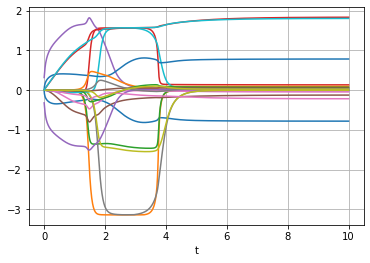

In [36]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [37]:
for i in range(coeff*N):  
    print(Y[-1][i])

-0.77840206086087
-9.633428573570986e-07
1.7540552965897063e-07
0.13514585811250623
-0.01894840001077274
-0.12213651636108105
-0.04346204878103268
-7.222557021848078e-08
-9.625214808467333e-08
0.05634885704797415
0.7856976102180298
0.09672622533596667
0.07396878663416528
1.8368431465240664
0.025444307029053564
0.05639483665211289
-0.21435193198495175
0.0329990364512622
0.026006577049862183
1.8068224396527737


In [38]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [39]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [40]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [41]:
psi = var_ansatz(start_point,psi_0)

In [42]:
psi_ground = eigenvec[:,0]


In [43]:
expt_value_u = np.zeros(len(time_domain))
energy = np.zeros(len(time_domain))

psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    for i in range(L+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))
    print(norm)

    expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
    energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)


0.9999954801092735
0.9999949975938202
0.9999872356582573
0.9999701456793784
0.9999433532136709
0.9999071010855541
0.999861858399673
0.9998081717899673
0.9997466038868729
0.9996777063174253
0.9996020076424945
0.99952000814772
0.9994321778995922
0.9993389563911201
0.9992407529686748
0.9991379476433587
0.9990308920919271
0.9989199107529639
0.9988053019743642
0.9986873391929283
0.9985662721385029
0.998442328059883
0.9983157129711518
0.9981866129168486
0.9980551952535113
0.9979216099439643
0.9977859908597644
0.997648457086229
0.9975091142239229
0.9973680556799617
0.99722536394231
0.9970811118301927
0.9969353637138766
0.9967881766973632
0.996639601757883
0.9964896848366176
0.9963384678755834
0.9961859897962815
0.9960322874163107
0.9958773963008981
0.9957213515469228
0.9955641884977655
0.9954059433879486
0.9952466539172325
0.9950863597544208
0.9949251029717718
0.994762928411423
0.9945998839857314
0.9944360209139405
0.9942713938979019
0.9941060612399906
0.9939400849065785
0.993773530540728
0.9

0.9928957931940185
0.9928996400765115
0.9929033478377807
0.992906922562084
0.9929103700355136
0.9929136957570982
0.9929169049502613
0.9929200025744557
0.9929229933368287
0.992925881703815
0.9929286719125626
0.9929313679821136
0.9929339737243046
0.992936492754326
0.9929389285009146
0.9929412842161743
0.9929435629849905
0.992945767734045
0.9929479012404264
0.9929499661398394
0.9929519649344134
0.992953900000133
0.9929557735938751
0.9929575878600994
0.992959344837167
0.9929610464633224
0.9929626945823715
0.9929642909490085
0.9929658372338772
0.9929673350283338
0.9929687858489422
0.9929701911417114
0.9929715522860917
0.9929728705987383
0.9929741473370578
0.9929753837025475
0.992976580843937
0.9929777398601509
0.992978861803093
0.9929799476802667
0.9929809984572423
0.9929820150599805
0.9929829983770124
0.992983949261494
0.9929848685331432
0.9929857569800502
0.9929866153603937
0.9929874444040466
0.992988244814091
0.9929890172682408
0.9929897624201792
0.9929904809008223
0.9929911733194998
0.9

0.9928992599416551
0.9928991166534212
0.992898974300417
0.9928988328774481
0.9928986923793323
0.9928985528009037
0.992898414137014
0.9928982763825254
0.9928981395323209
0.9928980035812965
0.9928978685243659
0.9928977343564572
0.9928976010725163
0.9928974686675069
0.9928973371364072
0.9928972064742123
0.9928970766759364
0.9928969477366101
0.9928968196512794
0.9928966924150113
0.9928965660228876
0.9928964404700087
0.9928963157514925
0.9928961918624771
0.9928960687981154
0.9928959465535794
0.9928958251240627
0.9928957045047705
0.9928955846909326
0.9928954656777972
0.9928953474606261
0.9928952300347036
0.9928951133953346
0.9928949975378384
0.9928948824575548
0.9928947681498458
0.9928946546100883
0.9928945418336806
0.9928944298160398
0.9928943185526024
0.9928942080388234
0.9928940982701785
0.9928939892421621
0.9928938809502875
0.9928937733900908
0.9928936665571229
0.9928935604469574
0.9928934550551869
0.9928933503774235
0.9928932464092997
0.9928931431464657
0.9928930405845952
0.992892938719

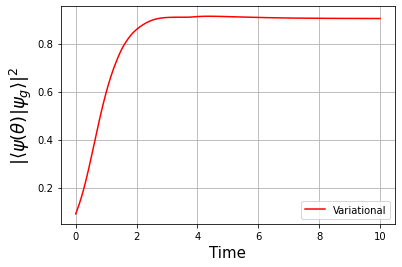

In [44]:
plt.plot(time_domain,expt_value_u, color = "red",label = "Variational")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.xlim(2.8,3)
#plt.ylim(0.99,1)

#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")

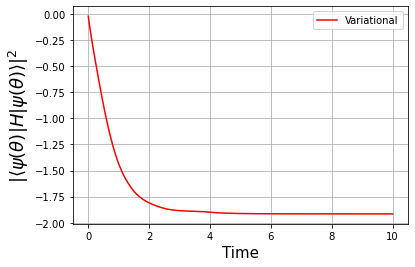

In [45]:
plt.plot(time_domain,energy, color = "red",label = "Variational")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.xlim(0,10)
#plt.ylim(-1.35,-1.25)

#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")

In [47]:
print(expt_value_u[-1])

0.9046453912273359


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
